In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import folium
from folium.plugins import MarkerCluster
from datetime import datetime
import seaborn as sns
import re

Please set this constant to false if you wish the cells not to plot graphs

In [2]:
PLOT_GRAPHS = False

In [3]:

nepal_file_path = input("Please paste the path to the Nepal dataset (excel file):")
senegal_file_path = input("Please paste the path to the Senegal dataset (excel file):")

NEPAL_PATH_NADAV = r"E:\Atuda\67814-Data-Science-Final-Project\Code\smallholder-productivity-analysis\data\raw\nepal_new_feature_names.xlsx"
SENEGAL_PATH_NADAV = r"E:\Atuda\67814-Data-Science-Final-Project\Code\smallholder-productivity-analysis\data\raw\senegal_new_feature_names.xlsx"

nepal_df = pd.read_excel(nepal_file_path.strip('"'))
senegal_df = pd.read_excel(senegal_file_path.strip('"'))

## 1. Initial Parsing of the Data
This phase includes removal of features that we from the start knew we would not use or would not be beneficial, and also coerces the remaining features's values to be their declared types

In [4]:

from collections import defaultdict

def parse_feature_metadata(col: str):
    parts = col.split('-', maxsplit=3)
    if len(parts) not in (3,4):
        return None
    qid, name, ftype = parts[:3]
    if not re.fullmatch(r'Q\d+|Q#', qid):
        return None
    dummy = parts[3] if len(parts)==4 else None
    return {"qid": qid, "name": name, "type": ftype, "dummy": dummy}


def fix_column_values(series: pd.Series, meta: dict) -> pd.Series:
    """
    Given a pandas Series and its parsed metadata,
    coerce its values to the right type:
      - continuous, ordinal, nominal → numeric (floats or ints; bad → NaN)
      - binary → 0/1 integers   (anything non‐zero → 1)
      - time   → pandas datetime (bad → NaT)
    """
    ftype = meta["type"]
    fname = meta["name"].lower()

    if ftype in ("continuous", "ordinal"):
        # numeric codes or measurements
        return pd.to_numeric(series, errors="coerce")
    if ftype == "nominal":
        return series.astype("category")
    if "binary" in ftype:
        # strings that are not '0': → 1, otherwise -> 0, floats/ints: non-zero → 1, zero or NaN → 0
        def to_binary(x):
            if pd.isna(x):
                return 0
            if isinstance(x, str):
                return x != '0'
            try:
                return 1 if float(x) != 0 else 0
            except:
                return 1
        return series.map(to_binary).astype(int)

    if ftype == "time":
        # Force everything to str so we have uniform input
        s = series.astype(str)
        # 0) special: End_Date holds a full datetime → extract only the time
        if "end_date" in fname:
            # parses strings like "4/27/2018 9:47:17 AM" into Timestamps
            dt = pd.to_datetime(s, errors="coerce")
            # grab Python datetime.time
            return dt.dt.time
        # 1) true date column → datetime64
        if "date" in fname:
            return pd.to_datetime(s, format="%Y-%m-%d", errors="coerce")

        # 2) survey‐length durations → timedelta64
        if "length" in fname:
            # strings like "00:21:14" → Timedelta
            return pd.to_timedelta(s, errors="coerce")

        # 3) the two pure clock‐time columns → Python time
        #    strings like "11:27:52" → Timestamp → .time()
        parsed = pd.to_datetime(s, format="%H:%M:%S", errors="coerce")
        return parsed.dt.time

    # otherwise leave it alone
    return series


def clean_survey_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Returns a copy of df in which:
      - all columns named Q<digits>-… have been coerced to their declared types
      - all other columns are left untouched (you can drop them later)
    """
    df = df.copy()
    for col in df.columns:
        meta = parse_feature_metadata(col)
        if meta is None:
            continue
        df[col] = fix_column_values(df[col], meta)
    return df


def drop_non_relevant_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove everything except Q<digits> columns:
    """
    keep = [col for col in df.columns if parse_feature_metadata(col) is not None]
    return df[keep]

import pandas as pd
from collections import defaultdict

def combine_dummy_columns(orig_df: pd.DataFrame) -> pd.DataFrame:
    """
    Combines your binary dummy columns into single categorical columns,
    but now *preserves* the option labels.

    For each (qid, type):
      - If there's exactly one dummy → just rename it to end in `-1`.
      - If there are many and it's one-hot (max 1 per row) → new column takes the option LABEL, or None.
      - Otherwise (multi-select) → new column is a list of the LABELS selected (possibly empty).
    """
    df = orig_df.copy()

    # 1) Gather metadata & group columns by (qid, type)
    meta_map   = {}               # col_name → {qid, qname, var_type, dummy_idx, label}
    buckets    = defaultdict(list)

    for col in df.columns:
        if "binary" not in col:
            continue
        m = parse_feature_metadata(col)
        qid        = m["qid"]
        qname      = m["name"]
        var_type   = m["type"]
        dummy_idx  = m["dummy"]
        
        subnames = qname.split(':')
        label      = subnames[-1] if len(subnames) > 1 else f"{qname}_{dummy_idx}"

        meta_map[col] = {
            "qid":       qid,
            "qname":     qname,
            "var_type":  var_type,
            "dummy_idx": dummy_idx,
            "label":     label
        }
        buckets[(qid, var_type)].append(col)

    to_drop  = []
    new_cols = {}

    # 2) Process each question group
    for (qid, var_type), cols in buckets.items():
        # sort by dummy_idx so labels stay in the right order
        cols_sorted   = sorted(cols, key=lambda c: meta_map[c]["dummy_idx"])
        labels_sorted = [meta_map[c]["label"] for c in cols_sorted]
        arr           = df[cols_sorted].fillna(0).astype(int).values

        # A) Single-dummy → just rename it to ...-1
        if len(cols_sorted) == 1:
            old = cols_sorted[0]
            new = f"{qid}-{meta_map[old]['qname']}-binary-1"
            df = df.rename(columns={old: new})
            continue
        

        new_type = "nominal" if var_type.endswith("nominal") else "ordinal"
        subnames = meta_map[cols[0]]['qname'].split(':')
        new_name = f"""{qid}-{':'.join(subnames[:-1]) 
                            if len(subnames) > 1
                            else subnames[0]}-{new_type}"""
        

        # B) One-hot? (no row has more than one “1”)
        if arr.sum(axis=1).max() <= 1:
            cat = []
            for row in arr:
                if row.sum() == 0:
                    cat.append(None)
                else:
                    cat.append(labels_sorted[row.argmax()])
            
            new_cols[new_name] = cat

        # C) Multi-select
        else:
            multi = []
            for row in arr:
                # collect all the labels whose dummy==1
                sel = [labels_sorted[i] for i, v in enumerate(row) if v == 1]
                multi.append(tuple(sel))
            new_cols[new_name] = multi

        to_drop.extend(cols_sorted)

    # 3) Drop old dummies & add the new columns
    if to_drop:
        df = df.drop(columns=to_drop)
        df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

    return df



In [5]:
# dropping non Q#... columns
nepal_df = drop_non_relevant_columns(nepal_df)
senegal_df = drop_non_relevant_columns(senegal_df)

# initial clean
nepal_df = clean_survey_dataframe(nepal_df)
senegal_df = clean_survey_dataframe(senegal_df)

# combine and remove dummy columns
nepal_df = combine_dummy_columns(nepal_df)
senegal_df = combine_dummy_columns(senegal_df)

## Create Productivity Metric Columns (Targets)

In [6]:
BIG_TO_SQM = 6772.63
HEC_TO_SQM = 10_000
XOF_TO_USD = 0.001871
NP_TO_USD = 0.008851

NPL_YEARLY_AGR_INCOME_COL = "Q108-What_is_your_households_yearly_income_from_agriculture_NPR-continuous"
SNGL_YEARLY_AGR_INCOME_COL = 'Q90-Yearly_income_agriculture_XOF-continuous'
NPL_OWND_CULTVTD_LAND_COL = "Q50-How_much_land_that_is_yours_do_you_cultivate_bigha-continuous"
SNGL_OWND_CULTVTD_LAND_COL = "Q60-Land_owned_cultivated_ha-continuous"
NPL_LEAS_CULTVTD_LAND_COL = "Q51-How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha-continuous"
SNGL_LEAS_CULTVTD_LAND_COL = "Q61-Land_rented_cultivated_ha-continuous"
NPL_VEG_HARVEST_PER_YEAR_COL = "Q62-How_much_VEGETABLES_do_you_harvest_per_year_from_this_plot_kilograms-continuous"
SNGL_VEG_HARVEST_PER_YEAR_COL = "Q71-VEG_harvest_per_year_kg-continuous"
NPL_SELF_REPORTED_FARM_LEVEL_COL = "Q112-Generally_speaking_how_would_you_define_your_farming-ordinal"
SNGL_SELF_REPORTED_FARM_LEVEL_COL = "Q94-Farming_level_relative-ordinal"


nepal_df['Q#-target1_yearly_income_from_agr_per_land_SQM-continuous'] = (NP_TO_USD * nepal_df[NPL_YEARLY_AGR_INCOME_COL]) / (BIG_TO_SQM * (nepal_df[NPL_OWND_CULTVTD_LAND_COL] + nepal_df[NPL_LEAS_CULTVTD_LAND_COL]))
senegal_df['Q#-target1_yearly_income_from_agr_per_land_SQM-continuous'] = (XOF_TO_USD * senegal_df[SNGL_YEARLY_AGR_INCOME_COL]) / (HEC_TO_SQM * (senegal_df[SNGL_OWND_CULTVTD_LAND_COL] + senegal_df[SNGL_LEAS_CULTVTD_LAND_COL]))

nepal_df['Q#-target2_yearly_income_from_agr_USD-continuous'] = NP_TO_USD * nepal_df[NPL_YEARLY_AGR_INCOME_COL]
senegal_df['Q#-target2_yearly_income_from_agr_USD-continuous'] = XOF_TO_USD * senegal_df[SNGL_YEARLY_AGR_INCOME_COL]

nepal_df['Q#-target3_veg_per_area-continuous'] = nepal_df[NPL_VEG_HARVEST_PER_YEAR_COL] / (BIG_TO_SQM * (nepal_df[NPL_OWND_CULTVTD_LAND_COL] + nepal_df[NPL_LEAS_CULTVTD_LAND_COL]))
senegal_df['Q#-target3_veg_per_area-continuous'] = senegal_df[SNGL_VEG_HARVEST_PER_YEAR_COL] / (HEC_TO_SQM * (senegal_df[SNGL_OWND_CULTVTD_LAND_COL] + senegal_df[SNGL_LEAS_CULTVTD_LAND_COL]))

nepal_df.rename(columns={NPL_SELF_REPORTED_FARM_LEVEL_COL: 'Q#-target4_self_farming_perception-ordinal'}, inplace=True)
senegal_df.rename(columns={SNGL_SELF_REPORTED_FARM_LEVEL_COL: 'Q#-target4_self_farming_perception-ordinal'}, inplace=True)

# defragment
nepal_df = nepal_df.copy()
senegal_df = senegal_df.copy()

target_cols = ['Q#-target1_yearly_income_from_agr_per_land_SQM-continuous',
               'Q#-target2_yearly_income_from_agr_USD-continuous',
               'Q#-target3_veg_per_area-continuous',
               'Q#-target4_self_farming_perception-ordinal']

# Univariate Analysis

## Analyze Datetime columns

Create mew datetime column

In [7]:


nepal_df['Q2-SurveyedDate-time'] = pd.to_datetime(nepal_df['Q2-SurveyedDate-time'], errors='coerce')

def create_datetime_col(df):
    # ensure your date column is datetime64
    df['Q2-SurveyedDate-time'] = pd.to_datetime(
        df['Q2-SurveyedDate-time'], format="%Y-%m-%d", errors='coerce'
    )

    # 1) build an all‐string “HH:MM:SS” series
    time_str = df['Q2-SurveyedTime-time'].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')[0]

    # 2) combine
    dt_strings = df['Q2-SurveyedDate-time'].dt.strftime('%Y-%m-%d') + ' ' + time_str

    # 3) parse into real timestamps
    df['Q2-Surveyed_Date_Time-time'] = pd.to_datetime(dt_strings, errors='coerce')

    print(df['Q2-Surveyed_Date_Time-time'].dtype)  # should be datetime64[ns]
    
create_datetime_col(nepal_df)
create_datetime_col(senegal_df)

datetime64[ns]
datetime64[ns]


Removed old one since already have DateTime column

In [8]:

nepal_df = nepal_df.drop(['Q2-SurveyedDate-time', 'Q2-SurveyedTime-time'], axis=1)
senegal_df = senegal_df.drop(['Q2-SurveyedDate-time', 'Q2-SurveyedTime-time'], axis=1)

Define function to analyze new datetime columns

In [9]:

def analyze_datetime(df, col):
    """
    Perform univariate analysis on a datetime64 column:
      - prints basic stats (min, max, missing)
      - plots counts per day, month, weekday, and hour-of-day
    """
    # Basic info
    series = df[col]
    if not series.dtype.name.startswith('datetime'):
        raise ValueError(f"Column {col!r} is not datetime dtype.")
    
    print(f"\n--- ANALYSIS OF {col.upper()} ---")
    print(f"Type: {series.dtype}")
    print(f"Missing: {series.isna().sum()} / {len(series)}")
    print(f"Range: {series.min()} → {series.max()}")
    
    # Extract time features
    df_temp = df.dropna(subset=[col]).copy()
    df_temp['date']    = df_temp[col].dt.date
    df_temp['month']   = df_temp[col].dt.to_period('M').astype(str)
    df_temp['weekday'] = df_temp[col].dt.day_name()
    df_temp['hour']    = df_temp[col].dt.hour
    
    # 1. Counts per day
    daily = df_temp.groupby('date').size()
    plt.figure()
    daily.plot(kind='bar')
    plt.title(f"Number of Records per Day ({col})")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Counts by month
    monthly = df_temp.groupby('month').size().sort_index()
    plt.figure()
    monthly.plot(kind='bar')
    plt.title(f"Counts by Month ({col})")
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 3. Counts by weekday
    # ensure Mon–Sun order
    weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    wd = df_temp['weekday'].value_counts().reindex(weekdays)
    plt.figure()
    wd.plot(kind='bar')
    plt.title(f"Counts by Weekday ({col})")
    plt.xlabel("Weekday")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    # 4. Distribution of hour of day
    plt.figure()
    sns.histplot(df_temp['hour'], bins=24, discrete=True, kde=False)
    plt.title(f"Survey Time of Day Distribution ({col})")
    plt.xlabel("Hour of Day")
    plt.ylabel("Count")
    plt.xticks(range(0,24))
    plt.tight_layout()
    plt.show()

    

Analyze new datetime columns

In [10]:
if PLOT_GRAPHS: 
    print("NEPAL DATA")
    analyze_datetime(nepal_df, 'Q2-Surveyed_Date_Time-time')
    print("SENEGAL DATA")
    analyze_datetime(senegal_df, 'Q2-Surveyed_Date_Time-time')

## Analyze Survey Length

Add Survey_Length column

In [11]:

# turn time → "HH:MM:SS" strings → Timedelta
nepal_df['Q#-SurveyLengthTime-time'] = (
    nepal_df['Q#-SurveyLengthTime-time']
      .astype(str)                # datetime.time → "HH:MM:SS"
      .pipe(pd.to_timedelta)      # parse into timedelta64[ns]
)

# first, make sure both your start‐ and end‐times are strings
senegal_df['Q2-Surveyed_Date_Time-time'] = senegal_df['Q2-Surveyed_Date_Time-time'].astype(str)
senegal_df['Q#-Surveyed_End_Date-time']   = senegal_df['Q#-Surveyed_End_Date-time'].astype(str)

# 1) Parse your “start” column as a real timestamp
senegal_df['start_dt'] = pd.to_datetime(
    senegal_df['Q2-Surveyed_Date_Time-time'],
    format='%Y-%m-%d %H:%M:%S'
)

# 2) Turn your “end time” (just HH:MM:SS) into a Timedelta
senegal_df['end_td'] = pd.to_timedelta(
    senegal_df['Q#-Surveyed_End_Date-time'].astype(str)
)

# 3) Build a full “end” timestamp by taking the date from start_dt and adding the time delta
senegal_df['end_dt'] = (
    senegal_df['start_dt'].dt.normalize()  # midnight of the start date
  + senegal_df['end_td']
)

senegal_df['Q#-SurveyLengthTime-time'] = senegal_df['end_dt'] - senegal_df['start_dt']

senegal_df.drop(columns=['start_dt', 'end_td', 'end_dt'], inplace=True)

Function to analyze Survey_Length column

In [12]:
from matplotlib.ticker import FuncFormatter

def analyze_survey_length(df, column='Q#-SurveyLengthTime-time', bins=30):
    """
    Analyze the distribution of survey lengths in a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the survey length column.
    column : str, default 'Survey_Length'
        Name of the timedelta column to analyze.
    bins : int, default 30
        Number of histogram bins.

    Outputs
    -------
    - Histogram of survey lengths (HH:MM:SS) distribution.
    - Printed mean and standard deviation of survey lengths.
    - Returns a tuple (mean_timedelta, std_timedelta).
    """
    # Ensure the column is timedelta64[ns]
    if not pd.api.types.is_timedelta64_dtype(df[column]):
        raise TypeError(f"Column '{column}' must be timedelta64[ns] dtype")

    # Compute statistics
    mean_td = df[column].mean()
    std_td = df[column].std()

    # Convert to total seconds for plotting
    secs = df[column].dt.total_seconds()

    # Plot histogram
    fig, ax = plt.subplots()
    ax.hist(secs, bins=bins)
    ax.set_title("Distribution of Survey Lengths")
    ax.set_xlabel("Survey Length (HH:MM:SS)")
    ax.set_ylabel("Frequency")

    # Formatter to convert seconds back to HH:MM:SS
    def sec_to_hhmmss(x, pos):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Print mean and std in HH:MM:SS
    mean_str = str(mean_td).split()[-1]
    std_str  = str(std_td).split()[-1]
    print(f"Mean survey length: {mean_str}")
    print(f"Std dev survey length: {std_str}")

    return mean_td, std_td

In [13]:
if PLOT_GRAPHS:
    print("NEPAL DATA")
    analyze_survey_length(nepal_df)
    print("SENEGAL DATA")
    analyze_survey_length(senegal_df)

Discovered data-entry glitch extreme value at one Senegalese survey

In [14]:
bad = senegal_df[ senegal_df['Q#-SurveyLengthTime-time'] < pd.Timedelta(0) ]
print(bad[['Q2-Surveyed_Date_Time-time','Q#-Surveyed_End_Date-time','Q#-SurveyLengthTime-time']])

    Q2-Surveyed_Date_Time-time Q#-Surveyed_End_Date-time  \
328        2018-04-27 14:18:09                  00:11:33   

    Q#-SurveyLengthTime-time  
328        -1 days +09:53:24  


Filling in this survey with median survey length

In [15]:
median_td = senegal_df.loc[ senegal_df['Q#-SurveyLengthTime-time'] >= pd.Timedelta(0), 'Q#-SurveyLengthTime-time' ].median()
mask = senegal_df['Q#-SurveyLengthTime-time'] < pd.Timedelta(0)
print(f"Found {mask.sum()} negative Survey_Length(s), filling with median = {median_td}")
senegal_df.loc[mask, 'Q#-SurveyLengthTime-time'] = median_td

Found 1 negative Survey_Length(s), filling with median = 0 days 00:31:58


Redefine survey analysis function by adding standard deviation markers

In [16]:
from matplotlib.ticker import FuncFormatter

def analyze_survey_length(df, column='Q#-SurveyLengthTime-time', bins=30, max_std=3):
    """
    Analyze the distribution of survey lengths in a DataFrame,
    and overlay vertical lines at mean ± n * std for n = 1..max_std.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the survey length column.
    column : str, default 'Survey_Length'
        Name of the timedelta column to analyze.
    bins : int, default 30
        Number of histogram bins.
    max_std : int, default 3
        How many standard-deviation multiples to draw lines for.

    Outputs
    -------
    - Histogram of survey lengths (HH:MM:SS) distribution with σ-lines.
    - Printed mean and standard deviation of survey lengths.
    - Returns a tuple (mean_timedelta, std_timedelta).
    """
    # 1) Type check
    if not pd.api.types.is_timedelta64_dtype(df[column]):
        raise TypeError(f"Column '{column}' must be timedelta64[ns] dtype")

    # 2) Compute statistics
    mean_td = df[column].mean()
    std_td  = df[column].std()

    mean_sec = mean_td.total_seconds()
    std_sec  = std_td.total_seconds()

    # 3) Build histogram
    secs = df[column].dt.total_seconds()
    fig, ax = plt.subplots(figsize=(8,4))
    ax.hist(secs, bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title("Distribution of Survey Lengths")
    ax.set_xlabel("Survey Length (HH:MM:SS)")
    ax.set_ylabel("Frequency")

    # Formatter: seconds → HH:MM:SS
    def sec_to_hhmmss(x, pos):
        h = int(x // 3600)
        m = int((x % 3600) // 60)
        s = int(x % 60)
        return f"{h:02d}:{m:02d}:{s:02d}"

    ax.xaxis.set_major_formatter(FuncFormatter(sec_to_hhmmss))
    plt.xticks(rotation=45)

    # 4) Overlay mean and std-bands
    #    use different linestyles/colors for clarity
    for n in range(0, max_std+1):
        # skip n=0 since that’s the mean line (draw it separately for legend clarity)
        if n == 0:
            ax.axvline(mean_sec, color='black', linestyle='-', linewidth=2,
                       label='Mean')
        else:
            for sign, label in [(+1, f'+{n}σ'), (-1, f'-{n}σ')]:
                x = mean_sec + sign * n * std_sec
                ax.axvline(x, linestyle='--' if n==1 else ':',
                           linewidth=1.5 if n==1 else 1,
                           label=label if sign>0 else None)
    # Only one -σ label needed, so we skip labeling the negative side

    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # 5) Print out
    mean_str = str(mean_td).split()[-1]
    std_str  = str(std_td).split()[-1]
    print(f"Mean survey length: {mean_str}")
    print(f"Std dev survey length: {std_str}")

    return mean_td, std_td

In [17]:
if PLOT_GRAPHS:
    print("SENEGAL DATA")
    analyze_survey_length(senegal_df)

Outliers defined as beyond 3 standard deviations, we swap outliers with median survey length

In [18]:
threshold = senegal_df['Q#-SurveyLengthTime-time'].mean() + 2*senegal_df['Q#-SurveyLengthTime-time'].std()
mask = senegal_df['Q#-SurveyLengthTime-time'] > threshold
print(f"Changed {mask.sum()} outlier survey lengths to median")
senegal_df.loc[mask, 'Q#-SurveyLengthTime-time'] = median_td

Changed 3 outlier survey lengths to median


Recheck survey length histogram

In [19]:
if PLOT_GRAPHS:
    print("SENEGAL DATA")
    analyze_survey_length(senegal_df)

## Analyze Locational Data

Since added Survey_Length column, took out others

In [20]:

nepal_df = nepal_df.drop(['Q#-SurveyedEndTime-time'], axis=1)
senegal_df = senegal_df.drop(['Q#-Surveyed_End_Date-time'], axis=1)

Showing missing columns in the Senegal dataset's Location_... columns

In [21]:
for column in ['Latitude', 'Longitude', 'Altitude', 'Accuracy']:
    print(f"missing values in Q1-Location_{column}: {senegal_df[f'Q1-Location_{column}-continuous'].isna().sum()}")
    print(f"missing values in {column}: {senegal_df[f'Q1-{column}-continuous'].isna().sum()}")


missing values in Q1-Location_Latitude: 335
missing values in Latitude: 0
missing values in Q1-Location_Longitude: 335
missing values in Longitude: 0
missing values in Q1-Location_Altitude: 335
missing values in Altitude: 0
missing values in Q1-Location_Accuracy: 335
missing values in Accuracy: 0


Removing Location_ columns from senegal data


In [22]:
senegal_df = senegal_df.drop(['Q1-Location_Latitude-continuous', 'Q1-Location_Longitude-continuous', 'Q1-Location_Altitude-continuous', 'Q1-Location_Accuracy-continuous'], axis=1)

Both are ok for nepal

In [23]:
for column in ['Latitude', 'Longitude', 'Altitude', 'Accuracy']:
    print(f"missing values in Location_{column}: {nepal_df[f'Q1-Location_{column}-continuous'].isna().sum()}")
    print(f"missing values in {column}: {nepal_df[f'Q1-{column}-continuous'].isna().sum()}")

missing values in Location_Latitude: 0
missing values in Latitude: 0
missing values in Location_Longitude: 0
missing values in Longitude: 0
missing values in Location_Altitude: 0
missing values in Altitude: 0
missing values in Location_Accuracy: 0
missing values in Accuracy: 0


Still removing from nepal Location_ columns for consistency between both datasets

In [24]:
nepal_df = nepal_df.drop(['Q1-Location_Latitude-continuous', 'Q1-Location_Longitude-continuous', 'Q1-Location_Altitude-continuous', 'Q1-Location_Accuracy-continuous'], axis=1)

Defining function to analyze locational columns

In [25]:

from folium.plugins import MarkerCluster

def lat_lon_hillshade_map(df, zoom_start=11):
    """
    Folium map with:
      • Default OpenStreetMap layer
      • ESRI World Hillshade (true terrain) layer
      • MarkerCluster of your points with Altitude pop-ups
      • LayerControl for toggling back and forth
    """
    # 1) Prepare & center
    df_map = df.dropna(subset=['Q1-Latitude-continuous','Q1-Longitude-continuous']).copy()
    center = [df_map['Q1-Latitude-continuous'].mean(), df_map['Q1-Longitude-continuous'].mean()]

    # 2) Build base map (OSM by default)
    m = folium.Map(location=center, zoom_start=zoom_start)

    # 3) Add ESRI World Hillshade as a second base layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/'
              'Elevation/World_Hillshade/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles © Esri — Source: USGS',
        name='Hillshade (ESRI)'
    ).add_to(m)

    # 4) Your markers (clustered)
    mc = MarkerCluster(name='Points').add_to(m)
    for idx, row in df_map.iterrows():
        folium.Marker(
            location=[row['Q1-Latitude-continuous'], row['Q1-Longitude-continuous']],
            popup=(
                f"<b>Index:</b> {idx}<br>"
                f"<b>Altitude:</b> {row.get('Q1-Altitude-continuous','N/A')} m"
            )
        ).add_to(mc)

    # 5) Toggle control
    folium.LayerControl(collapsed=False).add_to(m)

    return m


Analyze lat long data for nepal, both openstreetmap and hillshade for elevation

In [26]:
if PLOT_GRAPHS:
    nepal_map = lat_lon_hillshade_map(nepal_df)
    nepal_map   # in Jupyter this will render with two base‐layers to switch between


The same for Senegal

In [27]:
if PLOT_GRAPHS:
    print("SENEGAL DATA")
    senegal_map = lat_lon_hillshade_map(senegal_df)
    senegal_map


Check against google if the altitude column is accurate given the lat lot coordinates, plot accuracy also to see if there is some connection

In [28]:
import requests

def plot_altitude_error(df, lat_col='Q1-Latitude-continuous', lon_col='Q1-Longitude-continuous', alt_col='Q1-Altitude-continuous', accuracy_col='Q1-Accuracy-continuous', api_url='https://api.open-elevation.com/api/v1/lookup', batch_size=100, bins=30):
    '''
    Fetches true elevations and plots a combined view showing:
      - Histogram of altitude errors (recorded - true).
      - Median reported accuracy for each error bin overlaid as a line.

    Parameters:
    df (pd.DataFrame): DataFrame with latitude, longitude, recorded altitude, and accuracy columns.
    lat_col (str): Name of the latitude column.
    lon_col (str): Name of the longitude column.
    alt_col (str): Name of the recorded altitude column.
    accuracy_col (str): Name of the accuracy column.
    api_url (str): Elevation API endpoint.
    batch_size (int): Number of locations per API request.
    bins (int): Number of bins for error histogram and averaging.

    Returns:
    None. Displays a joint plot of error distribution and median accuracy per error bin.
    '''
    # Work on a copy
    df = df.copy()
    true_alts = []

    # Batch request loop to fetch true elevations
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        locations = '|'.join(f"{lat},{lon}" for lat, lon in zip(batch[lat_col], batch[lon_col]))
        resp = requests.get(api_url, params={'locations': locations})
        resp.raise_for_status()
        results = resp.json().get('results', [])
        if len(results) != len(batch):
            raise ValueError(f"Expected {len(batch)} results, got {len(results)}")
        true_alts.extend(r['elevation'] for r in results)

    # Compute errors and extract accuracy
    recorded = df[alt_col].values
    errors = recorded - np.array(true_alts)
    accuracies = df[accuracy_col].values

    # Prepare bins and compute median accuracy per bin
    bin_edges = np.linspace(errors.min(), errors.max(), bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    digitized = np.digitize(errors, bin_edges) - 1
    median_acc = [np.median(accuracies[digitized == i]) if np.any(digitized == i) else np.nan for i in range(bins)]

    # Create combined plot
    fig, ax1 = plt.subplots()

    # Histogram of errors
    ax1.hist(errors, bins=bin_edges, alpha=0.6)
    ax1.set_xlabel('Altitude Error (m)')
    ax1.set_ylabel('Frequency')
    ax1.axvline(0, color='k', linestyle='--')

    # Overlay median accuracy line on a twin y-axis
    ax2 = ax1.twinx()
    ax2.plot(bin_centers, median_acc, marker='o', linestyle='-')
    ax2.set_ylabel('Median Reported Accuracy')

    plt.title('Altitude Error Distribution with Median Accuracy per Error Bin')
    plt.show()

In [29]:
if PLOT_GRAPHS:
    plot_altitude_error(nepal_df)

In [30]:
if PLOT_GRAPHS:
    plot_altitude_error(senegal_df)

Except for a very few farmers in nepal, altitude is pretty similar all throughout, there is quite a lot of error, accuracy seems to have no helpful connection with this altitude error, will just keep the features for now

## Analyze All Other Features

Define a function to plot the marginal distributions of the remaining features, bar plots used for categorical features and histograms for numeric features

In [31]:
from collections import defaultdict

def plot_marginals(df: pd.DataFrame):
    # Group columns by question
    groups = defaultdict(list)
    for col in df.columns:
        meta = parse_feature_metadata(col)
        if meta:
            groups[meta["qid"]].append(col)

    for qid, cols in groups.items():
        meta0 = parse_feature_metadata(cols[0])
        ftype = meta0["type"]
        feat = meta0["name"].replace('_', ' ')

        plt.figure()
        if ftype == "binary":
            # ---- single‐select (<=2 columns) ----
            if len(cols) <= 2:
                # pick the “yes” column: if only one, use that; if two, look for '-1'
                if len(cols) == 1:
                    yes_col = cols[0]
                else:
                    yes_col = next(c for c in cols if c.endswith('-1'))
                ser = df[yes_col].fillna(0).astype(int)
                ser.value_counts().sort_index().plot(kind="bar", rot=0)
                plt.title(f"{qid} {feat} (binary yes/no)")
                plt.xlabel(feat)
                plt.ylabel("Count")

            # ---- multi‐select (>2 columns) ----
            else:
                counts = df[cols].fillna(0).astype(int).sum(axis=0)
                labels = [parse_feature_metadata(c)["name"].replace('_',' ')
                          for c in cols]
                pd.Series(counts.values, index=labels)\
                  .sort_values(ascending=False)\
                  .plot(kind="bar", rot=45)
                plt.title(f"{qid} {feat} (multi-select)")
                plt.xlabel(feat)
                plt.ylabel("Count")

        else:
            # continuous/ordinal/nominal
            ser = df[cols[0]]
            if pd.api.types.is_numeric_dtype(ser):
                plt.hist(ser.dropna(), bins='auto')
                plt.title(f"{qid} {feat} ({ftype})\n"
                          f"mean={ser.mean():.2f}, std={ser.std():.2f}")
            else:
                ser.value_counts().sort_index().plot(kind="bar", rot=0)
                plt.title(f"{qid} {feat} ({ftype})")
                plt.xlabel(feat)
                plt.ylabel("Count")

        plt.tight_layout()
        plt.show()

In [32]:
if PLOT_GRAPHS:
    plot_marginals(nepal_df)

In [33]:
if PLOT_GRAPHS:
    plot_marginals(senegal_df)

# Continuous & Discrete Missing Values

Get all discrete and continuous columns

In [34]:
non_cat_cols_nepal = []
non_cat_cols_senegal = []
for col in nepal_df.columns:
    meta_type = parse_feature_metadata(col)['type']
    if meta_type in ['continuous', 'discrete']:
        non_cat_cols_nepal.append(col)

for col in senegal_df.columns:

    meta_type = parse_feature_metadata(col)['type']
    
    if meta_type in ['continuous', 'discrete']:
        non_cat_cols_senegal.append(col)
    

Check how many missing values per column

In [35]:
missing_counts_nepal = nepal_df[non_cat_cols_nepal].isnull().sum()
print("Missing values per non-categorical column in nepal:")
print(missing_counts_nepal)

missing_counts_senegal = senegal_df[non_cat_cols_senegal].isnull().sum()
print("Missing values per non-categorical column in senegal:")
print(missing_counts_senegal)

Missing values per non-categorical column in nepal:
Q1-Latitude-continuous                                                                            0
Q1-Longitude-continuous                                                                           0
Q1-Altitude-continuous                                                                            0
Q1-Accuracy-continuous                                                                            0
Q5-AgeYears-continuous                                                                            0
Q50-How_much_land_that_is_yours_do_you_cultivate_bigha-continuous                                 0
Q51-How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha-continuous                      0
Q52-On_how_much_land_do_you_grow_vegetables_bigha-continuous                                      1
Q62-How_much_VEGETABLES_do_you_harvest_per_year_from_this_plot_kilograms-continuous               0
Q78-How_many_years_have_you_been_using_drip_irri

Check if missingness of How_many_children_do_you... columns in nepal are random

In [36]:
children_cols = ['Q102-How_many_children_do_you_have-continuous', 'Q103-How_many_children_do_you_plan_to_have_in_your_whole_live-continuous']
y_col = 'Q#-target2_yearly_income_from_agr_USD-continuous'

if PLOT_GRAPHS:
    for col in children_cols:

        mask_missing = nepal_df[col].isnull().values

        # Choose colors for each point
        colors = np.where(mask_missing, 'red', 'blue')

        plt.figure(figsize=(8,4))
        plt.scatter(nepal_df.index, nepal_df[y_col], c=colors, alpha=0.7)
        plt.xlabel("Index")
        plt.ylabel("Yearly Income from Agriculture (USD)")
        plt.title("Yearly Income from Agriculture (USD) vs. index\n\nRed = 'how many children' feature was missing")
        plt.show()

Missingness is uniformly spread throughout. We remove the columns because our coordinator
said we should

In [37]:
nepal_df = nepal_df.drop(columns=children_cols)


In [38]:

for col in children_cols:
    non_cat_cols_nepal.remove(col)

For the rest, fill missing values with median since very small amount of them and don't want to lose farmers

In [39]:
nepal_df[non_cat_cols_nepal] = nepal_df[non_cat_cols_nepal].fillna(nepal_df[non_cat_cols_nepal].median())
senegal_df[non_cat_cols_senegal] = senegal_df[non_cat_cols_senegal].fillna(senegal_df[non_cat_cols_senegal].median())

Recheck missing values in both datasets

In [40]:
# Check how many missing values per column
missing_counts_nepal = nepal_df[non_cat_cols_nepal].isnull().sum()
print("Missing values per non-categorical column in nepal:")
print(missing_counts_nepal)

missing_counts_senegal = senegal_df[non_cat_cols_senegal].isnull().sum()
print("Missing values per non-categorical column in senegal:")
print(missing_counts_senegal)

Missing values per non-categorical column in nepal:
Q1-Latitude-continuous                                                                           0
Q1-Longitude-continuous                                                                          0
Q1-Altitude-continuous                                                                           0
Q1-Accuracy-continuous                                                                           0
Q5-AgeYears-continuous                                                                           0
Q50-How_much_land_that_is_yours_do_you_cultivate_bigha-continuous                                0
Q51-How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha-continuous                     0
Q52-On_how_much_land_do_you_grow_vegetables_bigha-continuous                                     0
Q62-How_much_VEGETABLES_do_you_harvest_per_year_from_this_plot_kilograms-continuous              0
Q78-How_many_years_have_you_been_using_drip_irrigation_if

# Outliers

Check skew and kurtosis of features

In [41]:
def print_per_col_skew_and_kurtosis(df, cols):
    desc = pd.DataFrame(index=cols, columns=['skewness','kurtosis'])
    desc['skewness'] = df[cols].skew()
    desc['kurtosis'] = df[cols].kurtosis()
    print(desc)

print("For nepal dataset:")
print_per_col_skew_and_kurtosis(nepal_df, non_cat_cols_nepal)




For nepal dataset:
                                                     skewness    kurtosis
Q1-Latitude-continuous                               2.501469   11.458427
Q1-Longitude-continuous                             -2.078695    3.327960
Q1-Altitude-continuous                               7.738261   61.181298
Q1-Accuracy-continuous                               1.245955    1.722112
Q5-AgeYears-continuous                               0.011752   -0.698653
Q50-How_much_land_that_is_yours_do_you_cultivat...   0.380098   -0.503872
Q51-How_much_land_that_is_rented_or_leased_do_y...   2.428187    7.002975
Q52-On_how_much_land_do_you_grow_vegetables_big...   1.379596    1.564302
Q62-How_much_VEGETABLES_do_you_harvest_per_year...   7.498011   80.246841
Q78-How_many_years_have_you_been_using_drip_irr...  13.138456  180.751947
Q101-how_many_people_live_in_this_household-con...   1.779578    7.940154
Q106-Education_level_of_this_person_that_is_int...  -0.183514    0.424381
Q107-Education_leve

In [42]:
print("For senegal dataset:")
print_per_col_skew_and_kurtosis(senegal_df, non_cat_cols_senegal)

For senegal dataset:
                                                     skewness    kurtosis
Q1-Latitude-continuous                               0.651947   -1.027130
Q1-Longitude-continuous                              0.434510   -1.374106
Q1-Altitude-continuous                              -0.027704    1.898947
Q1-Accuracy-continuous                               2.523551    6.847364
Q5-Age-continuous                                    0.067253   -0.843279
Q#-Hope_total-continuous                             0.911953    1.005143
Q60-Land_owned_cultivated_ha-continuous              0.261807   -1.177306
Q61-Land_rented_cultivated_ha-continuous             4.403219   20.345663
Q62-Land_grow_vegetables_ha-continuous               0.228387   -1.165957
Q71-VEG_harvest_per_year_kg-continuous               2.712008   10.480210
Q84-Years_using_drip_irrigation-continuous           2.467766    5.748366
Q87-Household_size-continuous                        0.841336    1.153271
Q#-Education_year

A lot of features have very long and heavy tails, would like also a visual understanding, we plot qq plots aswell for the non-categorical columns

In [43]:
# Get QQ plots

import scipy.stats as stats

print("nepal qq plots")
if PLOT_GRAPHS:
    for col in non_cat_cols_nepal:
        plt.figure()
        stats.probplot(nepal_df[col].dropna(), dist="norm", plot=plt)
        plt.title(f"Q–Q plot for {col}")
        plt.show()

nepal qq plots


In [44]:
print("senegal qq plots")
if PLOT_GRAPHS:
    for col in non_cat_cols_senegal:
        plt.figure()
        stats.probplot(senegal_df[col].dropna(), dist="norm", plot=plt)
        plt.title(f"Q–Q plot for {col}")
        plt.show()

senegal qq plots


Very assymetric and kurtosis high, would like to classify outliers in a robust manner, taking into account the shape of the empirical distribution, we will use robust z scores calculated using the Qn scale

In [45]:
from statsmodels import robust

threshold = 3

def robust_z_scores(df, cols):

    outlier_counts = {}
    outlier_indices = {}
    robust_z_scores = {}

    for col in cols:
        # 1. Grab the non-null values as a 1D NumPy array
        data = df[col].dropna().values
        
        # 2. Compute Qn scale
        qn = robust.scale.qn_scale(data)

        # 3. Compute the column’s median
        med = np.median(data)

        # 4. Compute “robust z‐scores” relative to Qn
        #    (Note: unlike classical z, this is robust to heavy tails & skew)
        robust_z = (data - med) / qn
        robust_z_scores[col] = robust_z
        
        # 5. Flag outliers
        mask = np.abs(robust_z) > threshold
        
        # 6. Store counts and (optionally) original DataFrame indices
        outlier_counts[col] = int(mask.sum())
        # to get the original df indices:
        outlier_indices[col] = df[col].dropna().index[mask].tolist()

    # Convert to a nice summary DataFrame
    summary = pd.DataFrame.from_dict({
        'n_outliers': outlier_counts,
        'pct_outliers': {c: outlier_counts[c] / df[c].count() * 100 
                        for c in cols}
    }).T

    print("Outliers per column (using Qn):")
    print(summary)

    return outlier_indices, robust_z_scores

In [46]:
print("applied robust z-score outlier flagging to nepal:")
outlier_indices_nepal, robust_z_scores_nepal = robust_z_scores(nepal_df, non_cat_cols_nepal)

applied robust z-score outlier flagging to nepal:
Outliers per column (using Qn):
              Q1-Latitude-continuous  Q1-Longitude-continuous  \
n_outliers                 43.000000                48.000000   
pct_outliers               16.044776                17.910448   

              Q1-Altitude-continuous  Q1-Accuracy-continuous  \
n_outliers                  9.000000               11.000000   
pct_outliers                3.358209                4.104478   

              Q5-AgeYears-continuous  \
n_outliers                       0.0   
pct_outliers                     0.0   

              Q50-How_much_land_that_is_yours_do_you_cultivate_bigha-continuous  \
n_outliers                                           155.000000                   
pct_outliers                                          57.835821                   

              Q51-How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha-continuous  \
n_outliers                                            50.000000 

C:\Users\nadav\AppData\Local\Temp\ipykernel_26780\2071753757.py:23: RuntimeWarning: divide by zero encountered in divide
  robust_z = (data - med) / qn
C:\Users\nadav\AppData\Local\Temp\ipykernel_26780\2071753757.py:23: RuntimeWarning: invalid value encountered in divide
  robust_z = (data - med) / qn


In [47]:
print("applied robust z-score outlier flagging to senegal:")
outlier_indices_senegal, robust_z_scores_senegal = robust_z_scores(senegal_df, non_cat_cols_senegal)

applied robust z-score outlier flagging to senegal:
Outliers per column (using Qn):
              Q1-Latitude-continuous  Q1-Longitude-continuous  \
n_outliers                 72.000000               106.000000   
pct_outliers               21.492537                31.641791   

              Q1-Altitude-continuous  Q1-Accuracy-continuous  \
n_outliers                  5.000000               28.000000   
pct_outliers                1.492537                8.358209   

              Q5-Age-continuous  Q#-Hope_total-continuous  \
n_outliers                  0.0                 20.000000   
pct_outliers                0.0                  5.970149   

              Q60-Land_owned_cultivated_ha-continuous  \
n_outliers                                        0.0   
pct_outliers                                      0.0   

              Q61-Land_rented_cultivated_ha-continuous  \
n_outliers                                   33.000000   
pct_outliers                                  9.850746 

C:\Users\nadav\AppData\Local\Temp\ipykernel_26780\2071753757.py:23: RuntimeWarning: divide by zero encountered in divide
  robust_z = (data - med) / qn
C:\Users\nadav\AppData\Local\Temp\ipykernel_26780\2071753757.py:23: RuntimeWarning: invalid value encountered in divide
  robust_z = (data - med) / qn


Crosschecking with the QQ plots and marginal distributions of a lot of these features, many of these values classified as outliers make sense in terms of the data and should not be classified as such (especially in the ordinal columns), took a handful of columns frome ach dataset for which there could be outliers and only classified these outliers, to run analysis on them seperately (consider them a seperate population)

In [48]:
outlier_cols_nepal = ['Q62-How_much_VEGETABLES_do_you_harvest_per_year_from_this_plot_kilograms-continuous',
                      'Q78-How_many_years_have_you_been_using_drip_irrigation_if_no_zero-continuous',
                      'Q101-how_many_people_live_in_this_household-continuous',
                      'Q#-hope_total-continuous',
                      'Q#-positive_total-continuous',
                      'Q#-negative_total-continuous',
                      'Q#-Positive_Negative_Score-continuous',
                      'Q#-target1_yearly_income_from_agr_per_land_SQM-continuous',
                      'Q#-target2_yearly_income_from_agr_USD-continuous',
                      'Q#-target3_veg_per_area-continuous']

outlier_cols_senegal = ['Q#-Hope_total-continuous',
                        'Q71-VEG_harvest_per_year_kg-continuous',
                        'Q87-Household_size-continuous',
                        'Q90-Yearly_income_agriculture_XOF-continuous',
                        'Q91-Yearly_income_overall_XOF-continuous',
                        'Q92-Current_loan_amount_XOF-continuous',
                        'Q#-target1_yearly_income_from_agr_per_land_SQM-continuous',
                        'Q#-target2_yearly_income_from_agr_USD-continuous',
                        'Q#-target3_veg_per_area-continuous']

def highlight_outliers(df, outlier_cols, robust_z_scores):

    for col in outlier_cols:
        meta = parse_feature_metadata(col)
        col_z_scores = robust_z_scores[col]
        df[f"{meta['qid']}-is_outlier_high_{meta['name']}-binary-1"] = (col_z_scores > threshold).astype(int)
        df[f"{meta['qid']}-is_outlier_low_{meta['name']}-binary-1"] = (col_z_scores < -threshold).astype(int)


In [49]:
nepal_outliers = highlight_outliers(nepal_df, outlier_cols_nepal, robust_z_scores_nepal)
senegal_outliers = highlight_outliers(senegal_df, outlier_cols_senegal, robust_z_scores_senegal)




We do drop and quarantine the target outliers since the productivity metrics are what we are analyzing and this could affect the rest of this EDA

In [50]:
target_outlier_cols = ['Q#-is_outlier_high_target1_yearly_income_from_agr_per_land_SQM-binary-1',
                        'Q#-is_outlier_low_target1_yearly_income_from_agr_per_land_SQM-binary-1',
                        'Q#-is_outlier_high_target2_yearly_income_from_agr_USD-binary-1',
                        'Q#-is_outlier_low_target2_yearly_income_from_agr_USD-binary-1',
                        'Q#-is_outlier_high_target3_veg_per_area-binary-1',
                        'Q#-is_outlier_low_target3_veg_per_area-binary-1']


def seperate_target_outliers(df):

    target_outlier_mask = pd.Series(False, index=df.index)

    for col in target_outlier_cols:
        target_outlier_mask |= (df[col] == 1)

    outliers = df[target_outlier_mask].copy()

    df = df[~target_outlier_mask]

    return df, outliers

In [51]:
nepal_df, nepal_target_outliers = seperate_target_outliers(nepal_df)
senegal_df, senegal_target_outliers = seperate_target_outliers(senegal_df)

Get all categorical and binary columns

In [52]:
cat_cols_nepal = []
cat_cols_senegal = []
for col in nepal_df.columns:
    meta_type = parse_feature_metadata(col)['type']
    if meta_type not in ['continuous', 'discrete', 'time']:
        cat_cols_nepal.append(col)

for col in senegal_df.columns:
    meta_type = parse_feature_metadata(col)['type']
    if meta_type not in ['continuous', 'discrete', 'time']:
        cat_cols_senegal.append(col)

Check that none have an overly large amount of categories

In [53]:
unique_counts = nepal_df[cat_cols_nepal].nunique()
# 3. see which columns are OK (≤20) or not (>20)
ok      = unique_counts[ unique_counts <= 20 ]
too_many = unique_counts[ unique_counts  > 20 ]
bad = unique_counts[ unique_counts < 0 ]

print("Columns with ≤20 categories:\n", ok.sort_values(ascending=False))
print("\nColumns with >20 categories:\n", too_many.sort_values(ascending=False))
print("\nColumns with <0 categories:\n", bad)

Columns with ≤20 categories:
 Q105-main_sources_of_income-nominal                                       19
Q69-What_is_correct_for_you-nominal                                       16
Q53-What_type_of_crop_is_grown_on_this_plot-nominal                       14
Q73-Did_you_receive_anything_from_these_organizations-nominal             13
Q72-specify_the_names_of_organizations-nominal                            13
                                                                          ..
Q#-is_outlier_low_target1_yearly_income_from_agr_per_land_SQM-binary-1     1
Q#-is_outlier_high_target2_yearly_income_from_agr_USD-binary-1             1
Q#-is_outlier_low_target2_yearly_income_from_agr_USD-binary-1              1
Q#-is_outlier_high_target3_veg_per_area-binary-1                           1
Q#-is_outlier_low_target3_veg_per_area-binary-1                            1
Length: 105, dtype: int64

Columns with >20 categories:
 Q4-PhoneNumberAndIsZeroIfNone-nominal                            2

In [54]:
unique_counts = senegal_df[cat_cols_senegal].nunique()
# 3. see which columns are OK (≤20) or not (>20)
ok      = unique_counts[ unique_counts <= 20 ]
too_many = unique_counts[ unique_counts  > 20 ]
bad = unique_counts[ unique_counts < 0 ]

print("Columns with ≤20 categories:\n", ok.sort_values(ascending=False))
print("\nColumns with >20 categories:\n", too_many.sort_values(ascending=False))
print("\nColumns with <0 categories:\n", bad)

Columns with ≤20 categories:
 Q7-name_of_village-nominal                                                                        17
Q14-Hope_4_There_are_lots_of_ways_around_any_problem-ordinal                                       9
Q11-Hope_1_I_can_think_of_many_ways_to_get_out_of_a_jam-ordinal                                    8
Q16-Hope_6_I_can_think_of_many_ways_to_get_the_things_in_life_that_are_important_to_me-ordinal     8
Q12-Hope_2_I_energetically_pursue_my_goals-ordinal                                                 8
                                                                                                  ..
Q#-is_outlier_low_target1_yearly_income_from_agr_per_land_SQM-binary-1                             1
Q#-is_outlier_high_target2_yearly_income_from_agr_USD-binary-1                                     1
Q#-is_outlier_low_target2_yearly_income_from_agr_USD-binary-1                                      1
Q#-is_outlier_high_target3_veg_per_area-binary-1             

Only telephone, village and machinery columns have large amounts of categories which makes sense

# Constant Columns

We remove all remaining columns that have only a single value as this adds no new information

In [55]:
nepal_df = nepal_df.loc[:, nepal_df.nunique(dropna=False) > 1]
senegal_df = senegal_df.loc[:, senegal_df.nunique(dropna=False) > 1]

# Bivariate Analysis

Define the feature groups that we will be interested in throughout this project

In [56]:

geo_features_nepal = [
    "Q1-Latitude-continuous",
    "Q1-Longitude-continuous",
    "Q7-District-nominal",
    "Q8-WardNumber-nominal",
    "Q9-NameOfVillage-nominal",
    "Q1-Altitude-continuous",
    "Q1-Accuracy-continuous"
]

geo_features_senegal = [
    "Q1-Latitude-continuous",
    "Q1-Longitude-continuous",
    "Q6-Arrondissement-nominal",
    "Q7-name_of_village-nominal",
    "Q1-Altitude-continuous",
    "Q1-Accuracy-continuous"
]

feelings_features_nepal = [
    "Q30-To_what_extent_you_have_felt_this_way_during_the_past_week:_interested-ordinal",
    "Q31-To_what_extent_you_have_felt_this_way_during_the_past_week:_Distressed_worried-ordinal",
    "Q32-To_what_extent_you_have_felt_this_way_during_the_past_week:_Excited-ordinal",
    "Q33-To_what_extent_you_have_felt_this_way_during_the_past_week:_Upset-ordinal",
    "Q34-To_what_extent_you_have_felt_this_way_during_the_past_week:_Strong-ordinal",
    "Q35-To_what_extent_you_have_felt_this_way_during_the_past_week:_Guilty-ordinal",
    "Q36-To_what_extent_you_have_felt_this_way_during_the_past_week:_Scared-ordinal",
    "Q37-To_what_extent_you_have_felt_this_way_during_the_past_week:_Hostile-ordinal",
    "Q38-To_what_extent_you_have_felt_this_way_during_the_past_week:_Enthusiastic-ordinal",
    "Q39-To_what_extent_you_have_felt_this_way_during_the_past_week:_Proud-ordinal",
    "Q40-To_what_extent_you_have_felt_this_way_during_the_past_week:_Irritable-ordinal",
    "Q41-To_what_extent_you_have_felt_this_way_during_the_past_week:_Alert-ordinal",
    "Q42-To_what_extent_you_have_felt_this_way_during_the_past_week:_Ashamed-ordinal",
    "Q43-To_what_extent_you_have_felt_this_way_during_the_past_week:_Inspired-ordinal",
    "Q44-To_what_extent_you_have_felt_this_way_during_the_past_week:_Nervous-ordinal",
    "Q45-To_what_extent_you_have_felt_this_way_during_the_past_week:_Determined-ordinal",
    "Q46-To_what_extent_you_have_felt_this_way_during_the_past_week:_Attentive-ordinal",
    "Q47-To_what_extent_you_have_felt_this_way_during_the_past_week:_Jittery-ordinal",
    "Q48-To_what_extent_you_have_felt_this_way_during_the_past_week:_Active-ordinal",
    "Q49-To_what_extent_you_have_felt_this_way_during_the_past_week:_Afraid-ordinal"
]

character_features_senegal = [
    "Q24-Stand_up_in_face_of_opposition-ordinal",
    "Q25-Never_quit_task_before_done-ordinal",
    "Q26-Always_keep_promises-ordinal",
    "Q27-Always_finish_what_I_start-ordinal",
    "Q28-Leader_treats_everyone_equally-ordinal",
    "Q29-Always_busy_with_something_interesting-ordinal",
    "Q30-Strength_help_group_work_together-ordinal",
    "Q31-Must_stand_up_for_beliefs-ordinal",
    "Q32-Finish_things_despite_obstacles-ordinal",
    "Q33-Everyones_rights_equally_important-ordinal",
    "Q34-Excited_by_many_activities-ordinal",
    "Q35-Always_coming_up_with_new_ways-ordinal",
    "Q36-People_describe_me_as_wise-ordinal",
    "Q37-Promises_can_be_trusted-ordinal",
    "Q38-Give_everyone_a_chance-ordinal",
    "Q39-Effective_leader_treats_same-ordinal",
    "Q40-Extremely_grateful_person-ordinal",
    "Q41-Look_forward_to_each_new_day-ordinal",
    "Q42-Friends_say_I_have_many_ideas-ordinal",
    "Q43-Always_stand_up_for_beliefs-ordinal",
    "Q44-True_to_own_values-ordinal",
    "Q45-Think_through_consequences_before_acting-ordinal",
    "Q46-Have_lots_of_energy-ordinal",
    "Q47-Find_interest_in_any_situation-ordinal",
    "Q48-Thinking_things_through_is_part_of_me-ordinal",
    "Q49-Original_thinker-ordinal",
    "Q50-Mature_view_on_life-ordinal",
    "Q51-Feel_thankful_for_what_I_have-ordinal",
    "Q52-Always_weigh_pros_and_cons-ordinal",
    "Q53-Very_careful_person-ordinal",
    "Q54-Try_to_have_good_reasons_for_decisions-ordinal",
    "Q55-Always_make_careful_choices-ordinal",
    "Q56-Feel_profound_appreciation_daily-ordinal",
    "Q57-Awaken_with_excitement-ordinal",
    "Q58-Others_consider_me_wise-ordinal",
    "Q59-Worth_listening_to_everyones_opinion-ordinal"
]


demo_features_nepal = [
    "Q10-SexMale-binary-1",
    "Q11-Marital_Status_Single-nominal"
]

demo_features_senegal = [
    "Q86-Sex_male-binary-1"
]

# 3) The “Hope” ordinal items
hope_features_nepal = [
    "Q17-Hope_1_I_Can_Think_Of_Many_Ways_To_Get_Out_Of_A_Jam-ordinal",
    "Q18-Hope_2_I_energetically_pursue_my_goals-ordinal",
    "Q19-Hope_3_I_feel_tired_most_of_the_time-ordinal",
    "Q20-Hope_4_There_are_lots_of_ways_around_any_problem-ordinal",
    "Q21-Hope_5_I_am_easily_downed_being_at_a_low_position_brought_down_in_an_argument-ordinal",
    "Q22-Hope_6_I_can_think_of_many_ways_to_get_the_things_in_life_that_are_important_to_me-ordinal",
    "Q23-Hope_7_I_worry_about_my_health-ordinal",
    "Q24-Hope_8_Even_when_others_get_discouraged_I_know_I_can_find_a_way_to_solve_the_problem-ordinal",
    "Q25-Hope_9_My_past_experiences_have_prepared_me_well_for_my_future-ordinal",
    "Q26-Hope_10_I_have_been_pretty_successful_in_life-ordinal",
    "Q27-Hope_11_I_usually_find_myself_worrying_about_something-ordinal",
    "Q28-Hope_12_I_meet_the_goals_that_I_set_for_myself-ordinal"
]

hope_features_senegal = [
    "Q11-Hope_1_I_can_think_of_many_ways_to_get_out_of_a_jam-ordinal",
    "Q12-Hope_2_I_energetically_pursue_my_goals-ordinal",
    "Q13-Hope_3_I_feel_tired_most_of_the_time-ordinal",
    "Q14-Hope_4_There_are_lots_of_ways_around_any_problem-ordinal",
    "Q15-Hope_5_I_am_easily_downed_in_an_argument-ordinal",
    "Q16-Hope_6_I_can_think_of_many_ways_to_get_the_things_in_life_that_are_important_to_me-ordinal",
    "Q17-Hope_7_I_worry_about_my_health-ordinal",
    "Q18-Hope_8_Even_when_others_get_discouraged_I_know_I_can_find_a_way-ordinal",
    "Q19-Hope_9_My_past_experiences_have_prepared_me_well_for_my_future-ordinal",
    "Q20-Hope_10_Ive_been_pretty_successful_in_life-ordinal",
    "Q21-Hope_11_I_usually_find_myself_worrying_about_something-ordinal",
    "Q22-Hope_12_I_meet_the_goals_that_I_set_for_myself-ordinal"
]

# 4) Crop & fertilizer
crop_fertilizer_features_nepal = [
    "Q53-What_type_of_crop_is_grown_on_this_plot-nominal",
    "Q54-For_vegetables:_what_is_your_source_of_seeds-nominal",
    "Q55-For_Vegetables:_do_you_use_improved_and_or_variety_seeds:_yes-binary-1",
    "Q56-For_vegetables_do_you_use_seedlings-nominal",
    "Q57-If_you_self_prepare_seedlings_how:_Nursery-binary-1",
    "Q58-fertilizer_on_this_plot-nominal"
]

crop_fertilizer_features_senegal = [
    "Q63-CROP_Rice-nominal",
    "Q64-Seed_source_Selfprepared-nominal",
    "Q65-Variety_Imported-nominal",
    "Q66-Seedlings_Selfprepared-nominal",
    "Q67-Fertilizer_Chemical-nominal"
]


# 5) Pest control & machinery & weeding
plot_practice_features_nepal = [
    "Q63-What_is_the_main_use_of_produce_from_holding-nominal",
    "Q64-Do_you_use_machinery_or_and_equipment_on_the_plot-nominal",
    "Q65-Do_you_do_any_of_the_following-nominal"
]

plot_practice_features_senegal = [
    "Q69-Use_pesticide_or_herbicide-binary-1",
    "Q72-Sold_VEG_Trade-nominal",
    "Q73-Machinery_tractor-nominal",
    "Q74-Practice_cover_crops-nominal"
]

# 6) Soil analysis questions
soil_features_nepal = [
    "Q67-What_do_you_use_soil_analysis_for-nominal",
    "Q68-How_do_you_conduct_soil_analysis-nominal",
    "Q69-What_is_correct_for_you-nominal",
    "Q70-in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture-binary-1",
    "Q71-in_the_past_12_months_from_who_did_you_receive_info_on_agriculture-nominal",
    "Q72-specify_the_names_of_organizations-nominal",
    "Q73-Did_you_receive_anything_from_these_organizations-nominal"
]


soil_features_senegal = [
    "Q76-Received_agri_info_last_12m-binary-1",
    "Q77-Info_source_Govt-nominal",
    "Q78-Names_of_organizations-nominal",
    "Q79-Yes_drip_irrigation-nominal"
]

# 7) Plowing, sowing & irrigation
plow_irrigation_features_nepal = [
    "Q74-How_do_you_decide_to_plow-nominal",
    "Q75-How_do_you_decide_to_begin_sowing-nominal",
    "Q76-What_type_of_irrigation_do_you_use-nominal"
]


plow_irrigation_features_senegal = [
    "Q80-Plow_weather_self-nominal",
    "Q81-Sow_weather_self-nominal",
    "Q82-Irrigation_surface-nominal",
    "Q84-Years_using_drip_irrigation-continuous"
]

# 8) Self­-control items
self_control_features_nepal = [
    "Q80-SC_1_When_I_do_a_boring_job_I_think_about_the_less_boring_parts_of_the_job-ordinal",
    "Q81-SC_2_By_changing_my_way_of_thinking_I_am_often_able_to_change_my_feelings_about_almost_everything-ordinal",
    "Q82-SC_3_I_often_find_it_difficult_to_overcome_my_feelings_of_nervousness_and_tension_without_help-ordinal",
    "Q83-SC_4_When_I_am_feeling_depressed_I_try_to_think_about_pleasant_events-ordinal",
    "Q84-SC_5_I_cannot_help_thinking_about_mistakes_I_made-ordinal",
    "Q85-SC_6_I_usually_do_what_I_am_supposed_to_do_more_quickly_when_someone_is_pressuring_me-ordinal",
    "Q86-SC_7_When_I_am_faced_with_a_difficult_decision_I_prefer_to_postpone_it-ordinal",
    "Q87-SC_8_When_I_try_to_get_rid_of_a_bad_habit_for_example_smoking_stealing_i_first_try_to_find_out_why_i_have_the_habit-ordinal",
    "Q88-SC_9_If_I_smoked_two_packs_of_cigarettes_a_day_I_would_need_help_to_stop_smoking-ordinal",
    "Q89-SC_10_When_I_feel_down_I_try_to_act_cheerful_so_that_my_mood_will_change-ordinal",
    "Q90-SC_11_I_tend_to_postpone_unpleasant_tasks-ordinal",
    "Q91-SC_12_I_prefer_to_finish_a_job_that_I_have_to_do_before_I_start_doing_things_I_really_like-ordinal",
    "Q92-SC_13_When_I_feel_pain_I_try_not_to_think_about_it-ordinal",
    "Q93-SC_14_My_selfesteem_increases_when_I_am_able_to_overcome_a_bad_habit-ordinal",
    "Q94-SC_15_When_I_feel_that_I_am_too_impulsive_I_tell_myself_to_stop_and_think_before_I_do_anything-ordinal",
    "Q95-SC_16_Even_when_I_am_terribly_angry_at_someone_I_consider_my_actions_very_carefully-ordinal",
    "Q96-SC_17_When_I_need_to_make_a_decision_I_try_to_look_for_different_alternative-ordinal",
    "Q97-SC_18_Usually_I_first_do_the_thing_I_really_like_to_do_even_if_there_are_more_urgent_things_to_do-ordinal",
    "Q98-SC_19_When_I_am_faced_with_a_number_of_things_to_do_I_usually_plan_my_work-ordinal",
    "Q99-SC_20_When_I_am_tired_and_I_have_no_opportunity_to_sleep_I_try_not_to_think_about_it-ordinal"
]

# 9) Household & income & trust
household_features_nepal = [
    "Q100-Caste_bhramin-nominal",
    "Q101-how_many_people_live_in_this_household-continuous",
    "Q102-How_many_children_do_you_have-continuous",
    "Q103-How_many_children_do_you_plan_to_have_in_your_whole_live-continuous",
    "Q105-main_sources_of_income-nominal",
    "Q106-Education_level_of_this_person_that_is_interviewed._years_of_formal_education-continuous",
    "Q107-Education_level_of_your_wife_husband_How_many_years_of_formal_education-continuous",
    "Q110-Do_you_currently_have_a_loan__if_no_zero_if_yes_amount_of_money_loaned_NPR-continuous",
    "Q111-Generally_speaking_would_you_say_that_most_people_can_be_trusted_or_that_you_cant_be_too_careful_in_dealing_with_people-ordinal"
]

household_features_senegal = ['Q85-Group-nominal',
 'Q87-Household_size-continuous',
 'Q88-Own_business_income_source-nominal',
 'Q89-Primary_education-nominal',
 'Q#-Has_Education_Yes_No-binary-1',
 'Q#-Education_years-continuous',
 'Q92-Current_loan_amount_XOF-continuous',
 'Q93-Trust_most_people-ordinal']

hope_index_nepal = ['Q#-hope_total-continuous']
hope_index_senegal = ['Q#-Hope_total-continuous']

self_control_index_senegal = ['Q#-self_control_score-continuous']

positive_index_nepal = ['Q#-positive_total-continuous']

negative_index_nepal = ['Q#-negative_total-continuous']

avg_farming_practices_nepal = ['Q#-average_of_farming_practices-ordinal']


Plot scatter plots with LOESS between numeric / ordinal columns and the targets and boxplots for binary and nominal features against the targets for each of the above defined groups

In [57]:
import math
from statsmodels.nonparametric.smoothers_lowess import lowess
BINARY = 1
SINGLE_DUMMY = 2
ONE_HOT = 3
MULTI_SELECT = 4


def robust_loess(x, y, **kwargs):
    fitted = lowess(endog=y, exog=x, frac=0.6667, it=3)
    plt.plot(fitted[:, 0], fitted[:, 1], **kwargs)

# 3) pairplot function

def plot_pairplots(df, expl_feats, target_feats):

    # 2) for each target, plot *only* expl → target
    for tgt in target_feats:
        tmeta = parse_feature_metadata(tgt)
        if not tmeta:
            continue
        tname = f"{tmeta['qid']}_{tmeta['name']}"

        # assemble data
        tmp = df[expl_feats].copy()
        tmp[tname] = df[tgt]
        tmp = tmp.dropna()
        if tmp.shape[0] < 2:
            continue

        # i) compute grid shape
        n = len(expl_feats)
        ncols = int(math.ceil(math.sqrt(n)))
        nrows = int(math.ceil(n / ncols))

        # ii) create subplots grid
        fig, axes = plt.subplots(nrows, ncols,
                                 figsize=(ncols * 4, nrows * 3),
                                 squeeze=False)
        axes = axes.flatten()

        # iii) plot each explanatory feature
        for i, exp in enumerate(expl_feats):
            ax = axes[i]
            meta = parse_feature_metadata(exp)
            expl_type = meta.get('type', None)

            if expl_type in ['continuous', 'discrete', 'ordinal']:
                x = tmp[exp]
                y = tmp[tname]

                # if this is ordinal (labels), convert to ordered categorical codes
                if expl_type == 'ordinal' or pd.api.types.is_categorical_dtype(x):
                    cat = pd.Categorical(x, ordered=True)
                    x_codes = cat.codes
                    # scatter & LOESS on codes
                    ax.scatter(x_codes, y, alpha=0.6)
                    fitted = lowess(endog=y, exog=x_codes, frac=0.6667, it=3)
                    ax.plot(fitted[:, 0], fitted[:, 1], color='r')
                    # relabel x-ticks with the category names
                    ax.set_xticks(range(len(cat.categories)))
                    ax.set_xticklabels(cat.categories,
                                       rotation=45, ha='right', fontsize=8)
                else:
                    # purely numeric
                    ax.scatter(x, y, alpha=0.6)
                    fitted = lowess(endog=y, exog=x, frac=0.6667, it=3)
                    ax.plot(fitted[:, 0], fitted[:, 1], color='r')

            elif expl_type in ['nominal', 'binary']:

                # detect multi-select (list entries) vs. single-select (scalars)
                is_multi = tmp[exp].apply(lambda x: isinstance(x, (list, tuple))).any()
                if is_multi:
                    # --- multi-select nominal: explode lists so each label gets its own box ---
                    df_expl = tmp[[exp, tname]].explode(exp)
                    df_expl = df_expl.dropna(subset=[exp])
                    sns.boxplot(x=df_expl[exp].astype(str),
                                y=df_expl[tname],
                                ax=ax)
                else:
                    levels = tmp[exp].astype(str).value_counts().index
                    if len(levels) <= 10:
                        sns.boxplot(x=tmp[exp].astype(str), y=tmp[tname], ax=ax)
                        #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
                        #make x ticks wrap like done for the xlabel below
                    else:
                        top_levels = tmp[exp].astype(str).value_counts().nlargest(10).index
                        tmp2 = tmp[tmp[exp].astype(str).isin(top_levels)]
                        sns.boxplot(x=tmp2[exp].astype(str), y=tmp2[tname], ax=ax)
                        #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
                        #make x ticks wrap like done for the xlabel below

                orig_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
                wrapped_labels = ["\n".join([lab[i:i+30] for i in range(0, len(lab), 30)]) for lab in orig_labels]
                ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=8)

            # per-axis label
            wrapped_label = "\n".join([exp[i:i+30] for i in range(0, len(exp), 30)])
            ax.set_xlabel(wrapped_label, fontsize=8, labelpad=8)
            ax.set_ylabel("")

        # turn off leftover axes
        for ax in axes[n:]:
            ax.set_visible(False)

        # tidy and title
        plt.tight_layout()
        plt.suptitle(f"Explanatory Features vs {tname}", y=1.02)
        plt.show()


# 4) heatmap function

def plot_heatmaps(df, expl_feats, target_feats, method='pearson'):
    # 1) subset to numeric explanatory + numeric targets
    sub = df[expl_feats + target_feats].copy()
    # 2) coerce any object/nominal into codes
    for c in sub.columns:
        if not pd.api.types.is_numeric_dtype(sub[c]):
            sub[c] = sub[c].astype("category").cat.codes
    # 3) compute corr
    corr = sub.corr(method=method).loc[expl_feats, target_feats]
    plt.figure(figsize=(len(target_feats)*0.5+3, len(expl_feats)*0.3+3))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
    plt.title("Correlation heatmap: explanatory vs target", pad=20)
    plt.show()

def plot_group_heatmap(df, features, method='pearson'):

    sub = df[features].copy()
    # coerce nominal into codes
    for c in sub.columns:
        if not pd.api.types.is_numeric_dtype(sub[c]):
            sub[c] = sub[c].astype("category").cat.codes
    corr = sub.corr(method=method)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="viridis", center=0)
    plt.title("Correlation heatmap: group", pad=20)
    plt.show()


## Geography & Location

In [58]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, geo_features_nepal, target_cols)


NEPAL DATA


In [59]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, geo_features_nepal, target_cols)
    plot_group_heatmap(nepal_df, geo_features_nepal)

NEPAL DATA, PEARSON CORR


In [60]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, geo_features_nepal, target_cols, 'spearman')
    plot_group_heatmap(nepal_df, geo_features_nepal, 'spearman')

NEPAL DATA, SPEARMAN CORR


In [61]:
nepal_df["Q7-District-nominal"].value_counts()

Q7-District-nominal
jhapa    234
illam      2
6          1
Name: count, dtype: int64

In [62]:
print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, geo_features_senegal, target_cols)


SENEGAL DATA


In [63]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, geo_features_senegal, target_cols)
    plot_group_heatmap(senegal_df, geo_features_senegal)

SENEGAL DATA, PEARSON CORR


In [64]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, geo_features_senegal, target_cols, 'spearman')
    plot_group_heatmap(senegal_df, geo_features_senegal, 'spearman')

SENEGAL DATA, SPEARMAN CORR


### Check Visually on Map

In [65]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

def map_targets_on_map(
    df,
    lon_col,
    lat_col,
    target_cols,
    basemap=True,
    figsize=(8, 8),
    cmap='viridis',
    marker_size=50
):
    """
    For each target variable, plot its spatial distribution on a map.

    Parameters:
    - df: pandas.DataFrame containing data
    - lon_col, lat_col: names of longitude and latitude columns
    - target_cols: list of target variable names to map
    - basemap: whether to include a background map (default True)
    - figsize: size of the matplotlib figure
    - cmap: colormap for target values
    - marker_size: size of plotted points
    """
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df.copy(),
        geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
        crs="EPSG:4326"
    )
    # Project to Web Mercator for basemap
    gdf = gdf.to_crs(epsg=3857)

    for target in target_cols:
        fig, ax = plt.subplots(figsize=figsize)
        gdf.plot(
            ax=ax,
            column=target,
            cmap=cmap,
            legend=True,
            markersize=marker_size
        )
        if basemap:
            # Attempt Stamen terrain; fallback to OSM if unavailable
            try:
                provider = ctx.providers.Stamen.Terrain
            except Exception:
                provider = ctx.providers.OpenStreetMap.Mapnik
            ctx.add_basemap(ax, source=provider)
        ax.set_axis_off()
        ax.set_title(f"Spatial distribution of {target}")
        plt.tight_layout()
        plt.show()

In [66]:
if PLOT_GRAPHS:
    map_targets_on_map(nepal_df, 'Q1-Longitude-continuous', 'Q1-Latitude-continuous', target_cols)

In [67]:
if PLOT_GRAPHS:
    map_targets_on_map(senegal_df, 'Q1-Longitude-continuous', 'Q1-Latitude-continuous', target_cols)

## Demographic Data

In [68]:
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, demo_features_nepal, target_cols)

In [69]:
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, demo_features_senegal, target_cols)


## Hope Data

In [70]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, hope_features_nepal, target_cols)


NEPAL DATA


In [71]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, hope_features_nepal, target_cols)
    plot_group_heatmap(nepal_df, hope_features_nepal)

NEPAL DATA, PEARSON CORR


In [72]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, hope_features_nepal, target_cols, method='spearman')
    plot_group_heatmap(nepal_df, hope_features_nepal, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [73]:
print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, hope_features_senegal, target_cols)


SENEGAL DATA


In [74]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, hope_features_senegal, target_cols)
    plot_group_heatmap(senegal_df, hope_features_senegal)

SENEGAL DATA, PEARSON CORR


In [75]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, hope_features_senegal, target_cols, method='spearman')
    plot_group_heatmap(senegal_df, hope_features_senegal, method='spearman')

SENEGAL DATA, SPEARMAN CORR


## Crop & Fertilizer Data

In [76]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, crop_fertilizer_features_nepal, target_cols)


NEPAL DATA


In [77]:
nepal_df["Q53-What_type_of_crop_is_grown_on_this_plot-nominal"].value_counts()

Q53-What_type_of_crop_is_grown_on_this_plot-nominal
(_rice, _fruit, _maize, _other_cereals)             93
(_rice, _maize, _other_cereals)                     71
(_rice, _other_cereals)                             31
(_rice, _millet, _maize, _other_cereals)            13
(_rice, _fruit, _millet, _maize, _other_cereals)    11
(_rice, _maize)                                      7
(_rice, _maize, _other_cereals, _other)              3
(_rice, _maize, _other)                              2
(_rice, _fruit, _maize, _other_cereals, _other)      1
(_rice, _fruit, _maize, _other)                      1
(_rice, _fruit, _other_cereals)                      1
(_rice, _millet, _maize, _other_cereals, _other)     1
(_rice, _millet, _maize)                             1
(_maize, _other_cereals)                             1
Name: count, dtype: int64

In [78]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, crop_fertilizer_features_nepal, target_cols)
    plot_group_heatmap(nepal_df, crop_fertilizer_features_nepal)

NEPAL DATA, PEARSON CORR


In [79]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, crop_fertilizer_features_nepal, target_cols, 'spearman')
    plot_group_heatmap(nepal_df, crop_fertilizer_features_nepal, 'spearman')

NEPAL DATA, SPEARMAN CORR


In [80]:
print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, crop_fertilizer_features_senegal, target_cols)


SENEGAL DATA


In [81]:
senegal_df["Q63-CROP_Rice-nominal"].value_counts()

Q63-CROP_Rice-nominal
(CROP_Vegetables_3,)                 234
(CROP_Fruit_2, CROP_Vegetables_3)     44
Name: count, dtype: int64

In [82]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, crop_fertilizer_features_senegal, target_cols)
    plot_group_heatmap(senegal_df, crop_fertilizer_features_senegal)

SENEGAL DATA, PEARSON CORR


In [83]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, crop_fertilizer_features_senegal, target_cols, method='spearman')
    plot_group_heatmap(senegal_df, crop_fertilizer_features_senegal, method='spearman')

SENEGAL DATA, SPEARMAN CORR


## Pest Control & Machinery & Weeding

In [84]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, plot_practice_features_nepal, target_cols)


NEPAL DATA


In [85]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, plot_practice_features_nepal, target_cols)
    plot_group_heatmap(nepal_df, plot_practice_features_nepal)

NEPAL DATA, PEARSON CORR


In [86]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, plot_practice_features_nepal, target_cols, method='spearman')
    plot_group_heatmap(nepal_df, plot_practice_features_nepal, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [87]:
print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, plot_practice_features_senegal, target_cols)


SENEGAL DATA


In [88]:
senegal_df["Q74-Practice_cover_crops-nominal"].value_counts()

Q74-Practice_cover_crops-nominal
(Practice_crop_rotation_4,)                        256
(Practice_manuring_3, Practice_crop_rotation_4)     19
(Practice_manuring_3,)                               3
Name: count, dtype: int64

In [89]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, plot_practice_features_senegal, target_cols)
    plot_group_heatmap(senegal_df, plot_practice_features_senegal)

SENEGAL DATA, PEARSON CORR


In [90]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, plot_practice_features_senegal, target_cols, method='spearman')
    plot_group_heatmap(senegal_df, plot_practice_features_senegal, method='spearman')

SENEGAL DATA, SPEARMAN CORR


## Soil Analysis

In [91]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, soil_features_nepal, target_cols)


NEPAL DATA


In [92]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, soil_features_nepal, target_cols)
    plot_group_heatmap(nepal_df, soil_features_nepal)

NEPAL DATA, PEARSON CORR


In [93]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, soil_features_nepal, target_cols, method='spearman')
    plot_group_heatmap(nepal_df, soil_features_nepal, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [94]:
print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, soil_features_senegal, target_cols)


SENEGAL DATA


In [95]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, soil_features_senegal, target_cols)
    plot_group_heatmap(senegal_df, soil_features_senegal)

SENEGAL DATA, PEARSON CORR


In [96]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, soil_features_senegal, target_cols, method='spearman')
    plot_group_heatmap(senegal_df, soil_features_senegal, method='spearman')

SENEGAL DATA, SPEARMAN CORR


## Plowing, Sowing & Irrigation

In [97]:
nepal_df["Q76-What_type_of_irrigation_do_you_use-nominal"].value_counts()

Q76-What_type_of_irrigation_do_you_use-nominal
(_surface_irrigation, _drip.Sprinklers, _Sprinklers, _Pump_treadle)    135
(_surface_irrigation, _Pump_treadle)                                    66
(_drip.Sprinklers, _Sprinklers, _Pump_treadle)                          28
(_Pump_treadle,)                                                         4
(_drip.Sprinklers, _Drip_irrigation, _Sprinklers, _Pump_treadle)         3
(_drip.Sprinklers, _Drip_irrigation, _Pump_treadle)                      1
Name: count, dtype: int64

In [98]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, plow_irrigation_features_nepal, target_cols)
    plot_group_heatmap(nepal_df, plow_irrigation_features_nepal)

NEPAL DATA, PEARSON CORR


In [99]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, plow_irrigation_features_nepal, target_cols, method='spearman')
    plot_group_heatmap(nepal_df, plow_irrigation_features_nepal, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [100]:
print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, plow_irrigation_features_senegal, target_cols)


SENEGAL DATA


In [101]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, plow_irrigation_features_senegal, target_cols)
    plot_group_heatmap(senegal_df, plow_irrigation_features_senegal)

SENEGAL DATA, PEARSON CORR


In [102]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, plow_irrigation_features_senegal, target_cols, method='spearman')
    plot_group_heatmap(senegal_df, plow_irrigation_features_senegal, method='spearman')

SENEGAL DATA, SPEARMAN CORR


## Self-control Items

In [103]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, self_control_features_nepal, target_cols)


NEPAL DATA


In [104]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, plow_irrigation_features_senegal, target_cols)
    plot_group_heatmap(senegal_df, plow_irrigation_features_senegal)

SENEGAL DATA, PEARSON CORR


In [105]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, plow_irrigation_features_senegal, target_cols, method='spearman')
    plot_group_heatmap(senegal_df, plow_irrigation_features_senegal, method='spearman')

SENEGAL DATA, SPEARMAN CORR


## Household & Income & Trust

In [106]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, household_features_nepal, target_cols)


NEPAL DATA


In [107]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, household_features_nepal, target_cols)
    plot_group_heatmap(nepal_df, household_features_nepal)

NEPAL DATA, PEARSON CORR


In [108]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, household_features_nepal, target_cols, method='spearman')
    plot_group_heatmap(nepal_df, household_features_nepal, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [109]:
print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, household_features_senegal, target_cols)


SENEGAL DATA


In [110]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, household_features_senegal, target_cols)
    plot_group_heatmap(senegal_df, household_features_senegal)

SENEGAL DATA, PEARSON CORR


In [111]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, household_features_senegal, target_cols, method='spearman')
    plot_group_heatmap(senegal_df, household_features_senegal, method='spearman')

SENEGAL DATA, SPEARMAN CORR


In [112]:
hope_index_nepal = ['Q#-hope_total-continuous']
hope_index_senegal = ['Q#-Hope_total-continuous']

self_control_index_nepal = ['Q#-self_control_score-continuous']

positive_index_nepal = ['Q#-positive_total-continuous']

negative_index_nepal = ['Q#-negative_total-continuous']

avg_farming_practices_nepal = ['Q#-average_of_farming_practices-ordinal']

In [113]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, self_control_index_nepal, target_cols)

NEPAL DATA


In [114]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, self_control_index_senegal, target_cols)


NEPAL DATA, PEARSON CORR


In [115]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, self_control_index_senegal, target_cols, method='spearman')


NEPAL DATA, SPEARMAN CORR


In [116]:

print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, hope_index_nepal, target_cols)

NEPAL DATA


In [117]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, hope_index_nepal, target_cols)

NEPAL DATA, PEARSON CORR


In [118]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, hope_index_nepal, target_cols, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [119]:

print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, hope_index_senegal, target_cols)

SENEGAL DATA


In [120]:
print("SENEGAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, hope_index_senegal, target_cols)

SENEGAL DATA, PEARSON CORR


In [121]:
print("SENEGAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(senegal_df, hope_index_senegal, target_cols, method='spearman')

SENEGAL DATA, SPEARMAN CORR


In [122]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, positive_index_nepal, target_cols)

NEPAL DATA


In [123]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, positive_index_nepal, target_cols)

NEPAL DATA, PEARSON CORR


In [124]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, positive_index_nepal, target_cols, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [125]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, negative_index_nepal, target_cols)

NEPAL DATA


In [126]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, negative_index_nepal, target_cols)

NEPAL DATA, PEARSON CORR


In [127]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, negative_index_nepal, target_cols, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [128]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, avg_farming_practices_nepal, target_cols)

NEPAL DATA


In [129]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, avg_farming_practices_nepal, target_cols)

NEPAL DATA, PEARSON CORR


In [130]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, avg_farming_practices_nepal, target_cols, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [131]:
print("NEPAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(nepal_df, feelings_features_nepal, target_cols)

NEPAL DATA


In [132]:
print("NEPAL DATA, PEARSON CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, feelings_features_nepal, target_cols)

NEPAL DATA, PEARSON CORR


In [133]:
print("NEPAL DATA, SPEARMAN CORR")
if PLOT_GRAPHS:
    plot_heatmaps(nepal_df, feelings_features_nepal, target_cols, method='spearman')

NEPAL DATA, SPEARMAN CORR


In [134]:
print("SENEGAL DATA")
if PLOT_GRAPHS:
    plot_pairplots(senegal_df, character_features_senegal, target_cols)

SENEGAL DATA


## Productivity Metrics Heatmap

In [135]:
if PLOT_GRAPHS:
    plot_group_heatmap(nepal_df, target_cols)

In [136]:
if PLOT_GRAPHS:
    plot_group_heatmap(senegal_df, target_cols)

# Second Clean

Change phone number column to just binary yes no if he has a phone number

In [137]:

nepal_df['Q4-PhoneNumberAndIsZeroIfNone-nominal'] = (nepal_df['Q4-PhoneNumberAndIsZeroIfNone-nominal'] == 0).astype(int)
senegal_df['Q4-Phone_Number-nominal'] = (senegal_df['Q4-Phone_Number-nominal'] == 0).astype(int)

In [138]:
nepal_df.rename(columns={'Q4-PhoneNumberAndIsZeroIfNone-nominal' : 'Q4-HasPhoneNumber-binary-1'}, inplace=True)
senegal_df.rename(columns={'Q4-Phone_Number-nominal' : 'Q4-HasPhoneNumber-binary-1'}, inplace=True)


Scale all numeric columns and one hot encode all categorical columns, and deal with missing values in categorical columns by adding a 'missing' category

In [139]:
from sklearn.preprocessing import StandardScaler

def scale_numeric_columns(df):
    df = df.copy()
    # Get non-categorical numeric columns
    cols_to_scale = [col for col in df.columns if parse_feature_metadata(col)["type"] in ['continuous', 'discrete']]

    for col in cols_to_scale:
        median = df[col].median()
        # this returns a new Series (up-cast to float64) and assigns it back
        df[col] = df[col].fillna(median)
    
    scaler = StandardScaler()
    df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

    return df

def one_hot_encode_columns(df):
    df = df.copy()
    cols_to_dummies = []
    cols_to_dummies_prefixes = []
    for col in df.columns:
        meta = parse_feature_metadata(col)
        if meta["type"] in ['ordinal', 'nominal']:
            # add it to columns to one hot encode along with its question number
            cols_to_dummies_prefixes.append(f"{meta['qid']}-{meta['name']}")
            cols_to_dummies.append((col, meta["type"]))

    # deal with missing by adding a 'Missing' category
    for col, _ in cols_to_dummies:
        df[col] = df[col].astype('category').cat.add_categories('Missing')
        df[col] = df[col].fillna('Missing')
    
    col_names_to_dummies, _ = zip(*cols_to_dummies) 
    col_names_to_dummies = list(col_names_to_dummies)
    # applying prefix to dummies according to our feature name format
    dummies = pd.get_dummies(df[col_names_to_dummies], prefix_sep='_', prefix=cols_to_dummies_prefixes, columns=col_names_to_dummies, dtype=int)
    
    # applying postfix to dummies according to our feature name format
    rename_map = {}
    for orig, type in cols_to_dummies:
        # find all dummy cols that start with "<orig's qid>-<orig's name>"
        group = [c for c in dummies.columns if c.startswith(f"{parse_feature_metadata(orig)['qid']}-{parse_feature_metadata(orig)['name']}")]
        # enumerate them 1,2,3…
        for i, col_name in enumerate(group, start=1):
            rename_map[col_name] = f"{col_name}-binary_{type}-{i}"
            
    dummies = dummies.rename(columns=rename_map)
    df_other = df.drop(columns=col_names_to_dummies)
    final_df = pd.concat([df_other, dummies], axis=1)
    
    return final_df



In [140]:
nepal_df = one_hot_encode_columns(nepal_df)
nepal_df = scale_numeric_columns(nepal_df)


In [141]:
senegal_df = one_hot_encode_columns(senegal_df)
senegal_df = scale_numeric_columns(senegal_df)


# Multivariate Analysis

In [142]:
def convert_group_to_dummies(df, group : list):
    dummy_group = []
    for orig in group:
        meta = parse_feature_metadata(orig)
        if meta['type'] not in ['ordinal', 'nominal']:
            if orig in df.columns:
                dummy_group.append(orig)    
        else:    
            for col in df.columns:
                if col.startswith(f"{meta['qid']}-{meta['name']}"):
                    dummy_group.append(col)
                
    return dummy_group

In [143]:
groups = {'Geographic Features': (geo_features_nepal, geo_features_senegal),
          'Demographic Features': (demo_features_nepal, demo_features_senegal),
          'Hope Features': (hope_features_nepal, hope_features_senegal),
          'Crop & Fertilizer Features':(crop_fertilizer_features_nepal, crop_fertilizer_features_senegal),
          'Plot Practice Features': (plot_practice_features_nepal, plot_practice_features_senegal),
          'Soil Analysis Faetures': (soil_features_nepal, soil_features_senegal),
          'Plow & Irrigation': (plow_irrigation_features_nepal, plow_irrigation_features_senegal),
          'Self-control Features': (self_control_features_nepal, None),
          'Household Features': (household_features_nepal, household_features_senegal)}

In [144]:
from skbio.stats.distance import permanova, DistanceMatrix
from sklearn.preprocessing import OneHotEncoder
from gower import gower_matrix          # pip install gower
# X_enc = result of your pipeline's fit_transform

def transform(df, X_features, Y_features):
    # — X side —
    X_clean = df[X_features].astype(float).copy()
    X_enc   = X_clean.values

    # --- drop constant cols from X ---
    mask_x   = np.nanvar(X_enc, axis=0) > 0
    X_enc  = X_enc[:, mask_x]

    # — Y side: impute, then drop any col with std=0 before standardizing —
    Y_df    = df[Y_features].copy().fillna(df[Y_features].median())
    stds    = Y_df.std(ddof=0)
    keep    = stds > 0
    Y_df    = Y_df.loc[:, keep]
    Y_enc   = (Y_df - Y_df.mean()) / stds[keep]

    return X_enc, Y_enc


def convert_to_dist_matrices(X_enc, Y_enc):
    
    DX = DistanceMatrix(gower_matrix(X_enc))
    DY = DistanceMatrix(gower_matrix(Y_enc))
    return DX, DY


In [145]:
from skbio.stats.distance import mantel

def mantel_test(DX, DY):
    mantel_r, mantel_p, _ = mantel(DX, DY, method='spearman', permutations=999)
    print(f"Mantel ρ = {mantel_r:.3f},  p = {mantel_p:.4f}")


In [146]:
import dcor

def distance_covariance_test(X_enc, Y_enc):
    dcov_p, dcov_stat = dcor.independence.distance_covariance_test(
        X_enc, Y_enc, num_resamples=999)

    print(f"dCov statistic = {dcov_stat:.4f},  p = {dcov_p:.4f}\n")



In [147]:
Y_features = convert_group_to_dummies(nepal_df, target_cols)
for key, value in groups.items():
    print(f"Mantel and dCov tests on the {key}:")
    X_feats = convert_group_to_dummies(nepal_df, value[0])
    X_enc, Y_enc = transform(nepal_df, X_feats, Y_features)

    # no need to re-drop X here, we do both in convert_to_dist_matrices
    DX, DY = convert_to_dist_matrices(X_enc, Y_enc)

    mantel_test(DX, DY)
    distance_covariance_test(X_enc, Y_enc)   # still runs on raw arrays

Mantel and dCov tests on the Geographic Features:
Mantel ρ = 0.006,  p = 0.8370
dCov statistic = 16.8197,  p = 0.0010

Mantel and dCov tests on the Demographic Features:
Mantel ρ = 0.032,  p = 0.4660
dCov statistic = 1.2470,  p = 0.2790

Mantel and dCov tests on the Hope Features:
Mantel ρ = 0.039,  p = 0.0270
dCov statistic = 17.6668,  p = 0.0010

Mantel and dCov tests on the Crop & Fertilizer Features:
Mantel ρ = 0.375,  p = 0.0010
dCov statistic = 48.0609,  p = 0.0010

Mantel and dCov tests on the Plot Practice Features:
Mantel ρ = 0.278,  p = 0.0010
dCov statistic = 37.0397,  p = 0.0010

Mantel and dCov tests on the Soil Analysis Faetures:
Mantel ρ = 0.256,  p = 0.0010
dCov statistic = 52.9662,  p = 0.0010

Mantel and dCov tests on the Plow & Irrigation:
Mantel ρ = 0.466,  p = 0.0010
dCov statistic = 78.7722,  p = 0.0010

Mantel and dCov tests on the Self-control Features:
Mantel ρ = 0.027,  p = 0.2090
dCov statistic = 23.3776,  p = 0.0010

Mantel and dCov tests on the Household Fe

In [148]:
Y_features = convert_group_to_dummies(senegal_df, target_cols)
for key in groups.keys():
    if 'Self-control' in key:
        continue
    print(f"Mantel and dCov tests on the {key}:")
    X_features = convert_group_to_dummies(senegal_df, groups[key][1])
    X_enc, Y_enc = transform(senegal_df, X_features, Y_features)
    DX, DY = convert_to_dist_matrices(X_enc, Y_enc)
    mantel_test(DX, DY)
    distance_covariance_test(X_enc, Y_enc)

Mantel and dCov tests on the Geographic Features:
Mantel ρ = 0.067,  p = 0.0010
dCov statistic = 44.3842,  p = 0.0010

Mantel and dCov tests on the Demographic Features:
Mantel ρ = 0.006,  p = 0.7240
dCov statistic = 1.6979,  p = 0.0080

Mantel and dCov tests on the Hope Features:
Mantel ρ = 0.148,  p = 0.0010
dCov statistic = 31.5106,  p = 0.0010

Mantel and dCov tests on the Crop & Fertilizer Features:
Mantel ρ = 0.018,  p = 0.3090
dCov statistic = 7.1696,  p = 0.0010

Mantel and dCov tests on the Plot Practice Features:
Mantel ρ = 0.450,  p = 0.0010
dCov statistic = 89.4700,  p = 0.0010

Mantel and dCov tests on the Soil Analysis Faetures:
Mantel ρ = 0.036,  p = 0.1040
dCov statistic = 0.3561,  p = 0.2190

Mantel and dCov tests on the Plow & Irrigation:
Mantel ρ = 0.073,  p = 0.0010
dCov statistic = 14.2895,  p = 0.0010

Mantel and dCov tests on the Household Features:
Mantel ρ = 0.101,  p = 0.0010
dCov statistic = 30.6547,  p = 0.0010



# Dimensionality Reduction Analysis

In [149]:
from sklearn.decomposition import PCA

In [150]:
def plot_cumulative_explained_variance_for_group_for_pca(df, group_name, group_features):
    # Perform PCA with additional components
    pca_full = PCA(n_components=min(len(group_features),10))  # Analyze up to 10 components
    pca_full_result = pca_full.fit_transform(df[group_features])
    
    # Cumulative explained variance
    cumulative_variance = pca_full.explained_variance_ratio_.cumsum()
    
    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.title("Cumulative Explained Variance by PCA Components")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(True)
    plt.show()

In [151]:
print("NEPAL")
if PLOT_GRAPHS:
    for key, value in groups.items():
        for target in target_cols[:-1]:
            print(f"PCA of {key}, and then coloring by {target}")
            X_features = convert_group_to_dummies(nepal_df, value[0])

            pca_2d = PCA(n_components=2)
            pca_2d_result = pca_2d.fit_transform(nepal_df[X_features])
            #kmeans = KMeans(n_clusters=groups_k[key], random_state=42)
            #kmeans_result = kmeans.fit_predict(nepal_df[X_features])
            #kmeans_labels = kmeans.labels_
            plt.figure(figsize=(10, 8))
            plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=nepal_df[target], cmap='viridis', alpha=0.6)
            plt.title(f"PCA of {key}, and then coloring by {target}")
            plt.xlabel("Principal Component 1")
            plt.ylabel("Principal Component 2")
            name = parse_feature_metadata(target)['name']
            plt.colorbar(label=f"{name}")
            plt.grid(True)
            plt.show()
            
            #for target in target_features:
                
            #    print_cluster_info_for_target(nepal_df, target, kmeans_labels)

        plot_cumulative_explained_variance_for_group_for_pca(nepal_df, key, X_features)

NEPAL


In [152]:
print("SENEGAL")
if PLOT_GRAPHS:
    for key in groups.keys():
        if 'Demographic' in key or 'Self-control' in key:
                continue
        for target in target_cols[:-1]:
            
            print(f"PCA of {key}, and then coloring by {target}") 
            X_features = convert_group_to_dummies(senegal_df, groups[key][1])

            pca_2d = PCA(n_components=2)
            pca_2d_result = pca_2d.fit_transform(senegal_df[X_features])
            #kmeans = KMeans(n_clusters=groups_k[key], random_state=42)
            #kmeans_result = kmeans.fit_predict(senegal_df[X_features])
            #kmeans_labels = kmeans.labels_

            plt.figure(figsize=(10, 8))
            plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=senegal_df[target], cmap='viridis', alpha=0.6)
            plt.title(f"PCA of {key}, and then coloring by {target}")
            plt.xlabel("Principal Component 1")
            plt.ylabel("Principal Component 2")
            name = parse_feature_metadata(target)['name']
            plt.colorbar(label=f"{name}")
            plt.grid(True)
            plt.show()
            
            #for target in target_features:
                
            #    print_cluster_info_for_target(senegal_df, target, kmeans_labels)

            plot_cumulative_explained_variance_for_group_for_pca(senegal_df, key, X_features)

SENEGAL


In [153]:
from sklearn.decomposition import KernelPCA

In [154]:
def plot_cumulative_explained_variance_for_group_for_kpca(df, group_name, group_features):
    num_of_components = min(len(group_features),10)
    
    # Perform PCA with additional components
    kpca_full = KernelPCA(
                            n_components=num_of_components,     # how many principal axes you want
                            kernel="rbf",       # "rbf", "poly", "sigmoid", "cosine", etc.
                            gamma=0.1,          # only for RBF / polynomial kernels
                            fit_inverse_transform=False,  # True if you want to map back to X-space
                            random_state=0
                        )
    kpca_full_result = kpca_full.fit_transform(df[group_features])
    pca_on_kpca = PCA(n_components=num_of_components).fit(kpca_full_result)
    
    
    # Cumulative explained variance
    cumulative_variance = pca_on_kpca.explained_variance_ratio_.cumsum()
    
    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.title("Cumulative Explained Variance by PCA on KPCA Components")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.grid(True)
    plt.show()

In [155]:
print("NEPAL")
if PLOT_GRAPHS:
    for key, value in groups.items():
        print(f"PCA on {key} -> KPCA on PCA")
        X_features = convert_group_to_dummies(nepal_df, groups[key][0])

        # 2. Fit KernelPCA
        kpca_2d = KernelPCA(
            n_components=2,     # how many principal axes you want
            kernel="rbf",       # "rbf", "poly", "sigmoid", "cosine", etc.
            gamma=0.1,          # only for RBF / polynomial kernels
            fit_inverse_transform=False,  # True if you want to map back to X-space
            random_state=0
        )
        kpca_2d_result = kpca_2d.fit_transform(nepal_df[X_features])
        #kmeans = KMeans(n_clusters=groups_k[key], random_state=42)
        #kmeans_result = kmeans.fit_predict(nepal_df[X_features])
        #kmeans_labels = kmeans.labels_

        plt.figure(figsize=(10, 8))
        plt.scatter(kpca_2d_result[:, 0], kpca_2d_result[:, 1], cmap='viridis', alpha=0.6)
        plt.title(f"KPCA Visualization on {key}")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.grid(True)
        plt.show()
        
        #for target in target_features:
            
        #    print_cluster_info_for_target(nepal_df, target, kmeans_labels)

        plot_cumulative_explained_variance_for_group_for_kpca(nepal_df, key, X_features)

NEPAL


In [156]:
if PLOT_GRAPHS:
    for key, value in groups.items():
        if 'Demographic' in key or 'Self-control' in key:
            continue
        
        print(f"PCA on {key} -> KPCA on PCA")
        X_features = convert_group_to_dummies(senegal_df, groups[key][1])

        # 2. Fit KernelPCA
        kpca_2d = KernelPCA(
            n_components=2,     # how many principal axes you want
            kernel="rbf",       # "rbf", "poly", "sigmoid", "cosine", etc.
            gamma=0.1,          # only for RBF / polynomial kernels
            fit_inverse_transform=False,  # True if you want to map back to X-space
            random_state=0
        )
        kpca_2d_result = kpca_2d.fit_transform(senegal_df[X_features])
        #kmeans = KMeans(n_clusters=groups_k[key], random_state=42)
        #kmeans_result = kmeans.fit_predict(senegal_df[X_features])
        #kmeans_labels = kmeans.labels_

        plt.figure(figsize=(10, 8))
        plt.scatter(kpca_2d_result[:, 0], kpca_2d_result[:, 1], cmap='viridis', alpha=0.6)
        plt.title(f"KPCA Visualization on {key}")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.colorbar(label="Cluster")
        plt.grid(True)
        plt.show()
        
        #for target in target_features:
            
        #    print_cluster_info_for_target(senegal_df, target, kmeans_labels)

        plot_cumulative_explained_variance_for_group_for_kpca(senegal_df, key, X_features)

# Clustering Analysis

In [157]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [158]:
def print_cluster_info_for_target(df, target_feature, kmeans_labels):
    target_name = parse_feature_metadata(target_feature)['name']
    for cluster_id in np.unique(kmeans_labels):
        indices = np.where(kmeans_labels == cluster_id)
        avg_label = np.mean(np.array(df[target_feature])[indices])
        print(f"Cluster {cluster_id}:\nAverage {target_name} = {avg_label:.2f}\n")

In [159]:
def plot_k_inertias(df, group_features):
    inertias = []
    K = range(1,11)
    X_scaled = StandardScaler().fit_transform(df[group_features])
    
    for k in K:
        km = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
        inertias.append(km.inertia_)
    
    plt.plot(K, inertias, '-o')
    plt.xlabel('k'); plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

In [160]:
def plot_k_sillouhettes(df, group_features):
    scores = []
    X_scaled = StandardScaler().fit_transform(df[group_features])
    
    for k in range(2,11):
        km = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
        labels = km.labels_
        scores.append(silhouette_score(X_scaled, labels))
    
    plt.plot(range(2,11), scores, '-o')
    plt.xlabel('k'); plt.ylabel('Avg. Silhouette Score')
    plt.title('Silhouette Method for Optimal k')
    plt.show()

In [161]:
if PLOT_GRAPHS:
    target_features = convert_group_to_dummies(senegal_df, target_cols)
    for key in groups.keys():
        if 'Self-control' in key:
            continue
        print(f"Group is: {key}")
        X_features = convert_group_to_dummies(senegal_df, groups[key][1])
        
        plot_k_inertias(senegal_df, X_features)
        
        plot_k_sillouhettes(senegal_df, X_features)
    
    

In [162]:
if PLOT_GRAPHS:
    target_features = convert_group_to_dummies(nepal_df, target_cols)
    for key, value in groups.items():
        print(f"Group is: {key}")
        X_features = convert_group_to_dummies(nepal_df, value[0])
        
        plot_k_inertias(nepal_df, X_features)
        
        plot_k_sillouhettes(nepal_df, X_features)
    
    

In [163]:
groups_k = {'Geographic Features': 2,
          'Demographic Features': 2,
          'Hope Features': 2,
          'Crop & Fertilizer Features': 3,
          'Plot Practice Features': 10,
          'Soil Analysis Faetures': 4,
          'Plow & Irrigation': 3,
          'Self-control Features': 2,
          'Household Features': 2}

In [164]:
# 2) Clustering functions
def cluster_kmeans(df, feature_cols, n_clusters=3, random_state=42):
    """
    Run K-Means on df[feature_cols].
    Returns: (labels array, fitted KMeans model)
    """
    X = df[feature_cols].to_numpy()
    # explicitly set n_init (old default was 10; new “auto” uses smarter init logic)
    km = KMeans(n_clusters=n_clusters,
                n_init="auto",          # ← explicitly match the old default
                random_state=random_state)
    labels = km.fit_predict(X)
    return labels, km

def cluster_agglomerative(df, feature_cols, n_clusters=3):
    """
    Run AgglomerativeClustering on df[feature_cols].
    Returns: (labels array, fitted AgglomerativeClustering model)
    """
    X = df[feature_cols].to_numpy()
    ag = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ag.fit_predict(X)
    return labels, ag

# 3) Profiling function
def profile_clusters(df, labels, profiling_features):
    """
    Attach `labels` as df['cluster'], then return:
    - cluster sizes (Series)
    - mean of productivity_metrics per cluster (DataFrame)
    """
    n = len(profiling_features)
    ncols = int(math.ceil(math.sqrt(n)))
    nrows = int(math.ceil(n / ncols))
    
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols * 4, nrows * 3),
                             squeeze=False)
    axes = axes.flatten()

    
    tmp = df.copy()
    tmp['cluster'] = labels

    for i, feat in enumerate(profiling_features):
        ax = axes[i]
        sns.boxplot(x=tmp['cluster'].astype(str), y=tmp[feat], ax=ax)
        
        orig_labels = [lbl.get_text() for lbl in ax.get_xticklabels()]
        wrapped_labels = ["\n".join([lab[i:i+30] for i in range(0, len(lab), 30)]) for lab in orig_labels]
        
        pos = np.arange(len(wrapped_labels))
        ax.set_xticks(pos)
        ax.set_xticklabels(wrapped_labels, rotation=45,
                        ha='right', fontsize=8)

        # per-axis label
        wrapped_label = "\n".join([feat[i:i+30] for i in range(0, len(feat), 30)])
        ax.set_xlabel(wrapped_label, fontsize=8, labelpad=8)
        ax.set_ylabel("")

    # turn off leftover axes
    for ax in axes[n:]:
        ax.set_visible(False)

    # tidy and title
    plt.tight_layout()
    plt.show()


In [165]:
def cluster_and_profile(df, country_key, group_name, profiling_feats, cluster_fn):
    
    cols = groups[group_name][0 if country_key == 'nepal' else 1]
    if not cols:
        print(f"Clustering group {group_name} doesnt exist in this country")
        return  # do nothing for groups missing in this country
    cols = convert_group_to_dummies(df, cols)
    labels, model = cluster_fn(df, cols, n_clusters=3)
    print(f"\nClustering by: {group_name}")
    profile_clusters(df, labels, profiling_feats)

In [166]:
import warnings

# scikit‐learn KMeans n_init warning
warnings.filterwarnings(
    "ignore",
    message=".*KMeans is known to have a memory leak.*",
    module="sklearn.cluster._kmeans"
)

# matplotlib FixedFormatter warning
warnings.filterwarnings(
    "ignore",
    message="FixedFormatter should only be used together with FixedLocator"
)

In [167]:
if PLOT_GRAPHS:
    for country_key, df in [('nepal', nepal_df), ('senegal', senegal_df)]:
        target_features = convert_group_to_dummies(df, target_cols)
        print(f"\n===== {country_key.upper()} =====")
        for method_name, cluster_fn in [
                ('K-Means', cluster_kmeans),
                ('Agglomerative', cluster_agglomerative)
            ]:
            print(f"\n--- {method_name} Clustering by Feature‐Group ---")
            for group_name in groups.keys():
                cluster_and_profile(df, country_key, group_name, target_features, cluster_fn)


# Proof of Concept of Main Method

In [168]:
df = nepal_df.copy()

In [169]:
for col in df.columns:
    if 'farming_practice' in col:
        print(col)

Q#-average_of_farming_practices_0.0-binary_ordinal-1
Q#-average_of_farming_practices_0.25-binary_ordinal-2
Q#-average_of_farming_practices_0.5-binary_ordinal-3
Q#-average_of_farming_practices_0.75-binary_ordinal-4
Q#-average_of_farming_practices_1.0-binary_ordinal-5
Q#-average_of_farming_practices_Missing-binary_ordinal-6


In [170]:


# Method 1: if all column names are strings:
df.columns = df.columns.str.replace('-', '_')
df.columns = df.columns.str.replace('#', '0')

In [171]:
df['XM'] = df['Q70_in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture_binary_1'] * df['Q0_self_control_score_continuous']

In [172]:
# 2) Reconstruct the ordinal “average_of_farming_practices” score from your dummies

bins = [
    'Q0_average_of_farming_practices_0.0_binary_1',
    'Q0_average_of_farming_practices_0.25_binary_2',
    'Q0_average_of_farming_practices_0.5_binary_3',
    'Q0_average_of_farming_practices_0.75_binary_4',
    'Q0_average_of_farming_practices_1.0_binary_5',
]
missing = 'Q0_average_of_farming_practices_Missing_binary_6'


# Method A: dot-product (quick when there’s exactly one “1” per row in bins)
weights = [0.0, 0.25, 0.5, 0.75, 1.0]
df['Q0_average_of_farming_practices'] = df[bins].dot(weights)

# set missing to NaN
df.loc[df[missing] == 1, 'Q0_average_of_farming_practices'] = np.nan


KeyError: "None of [Index(['Q0_average_of_farming_practices_0.0_binary_1',\n       'Q0_average_of_farming_practices_0.25_binary_2',\n       'Q0_average_of_farming_practices_0.5_binary_3',\n       'Q0_average_of_farming_practices_0.75_binary_4',\n       'Q0_average_of_farming_practices_1.0_binary_5'],\n      dtype='object')] are in the [columns]"

In [ ]:
plot_df = df.copy()
plot_df = plot_df.rename(columns={'Q70_in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture_binary_1':
                                  'Q70-in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture-binary-1',
                                  'Q0_self_control_score_continuous': 'Q#-self_control_score-continuous',
                                  'Q0_hope_total_continuous': 'Q#-hope_total-continuous',
                                  'XM': 'Q#-moderation_term-continuous',
                                  'Q0_average_of_farming_practices': 'Q#-average_of_farming_practices-continuous'}
                        )

In [ ]:
# — or — using sklearn
scaler = StandardScaler()
df['Q70_in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture_binary_1'] = scaler.fit_transform(df[['Q70_in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture_binary_1']])

In [ ]:
df['XM'] = df['Q70_in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture_binary_1'] * df['Q0_self_control_score_continuous']

In [ ]:
demo_model_desc = """
# Structural paths
Q0_average_of_farming_practices ~ a*Q70_in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture_binary_1 + b*Q0_self_control_score_continuous + c*Q0_hope_total_continuous + d*XM
"""

In [ ]:
from semopy import Model, calc_stats
sem = Model(demo_model_desc)

sem.fit(df)

# 2) Global SEM fit on train
stats = calc_stats(sem)
# extract scalars
chi2_scaler  = float(stats['chi2'])
cfi   = float(stats['CFI'])
tli   = float(stats['TLI'])
rmsea = float(stats['RMSEA'])
aic   = float(stats['AIC'])
bic   = float(stats['BIC'])

fit_df = pd.DataFrame({
    'Statistic': ['Chi-square (p>0.05)', 'CFI (>=0.95)', 'TLI (>=0.95)', 'RMSEA (<=0.05)', 'AIC', 'BIC'],
    'Value':     [chi2_scaler, cfi, tli, rmsea, aic, bic]
})

KeyError: 'Variables Q0_average_of_farming_practices are missing from data.'

In [ ]:
print(fit_df)

             Statistic         Value
0  Chi-square (p>0.05)  3.347592e-07
1         CFI (>=0.95)  1.074407e+00
2         TLI (>=0.95)  1.104169e+00
3       RMSEA (<=0.05)  0.000000e+00
4                  AIC  1.000000e+01
5                  BIC  2.734030e+01


In [ ]:

# 2) Inspect to a DataFrame
params_df = sem.inspect()  # default list mode
# 3) Keep only regression rows
reg = params_df[params_df['op'] == '~']

# 4) Helper to extract both Estimate and p-value
def extract(lval, rval):
    mask = (reg['lval'] == lval) & (reg['rval'] == rval)
    return {
        'Estimate': reg.loc[mask, 'Estimate'].item(),
        'p-value':  reg.loc[mask, 'p-value'].item()
    }

# 5) Extract each path
a = extract(
    'Q0_average_of_farming_practices',
    'Q70_in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture_binary_1'
)
b = extract(
    'Q0_average_of_farming_practices',
    'Q0_self_control_score_continuous'
)
c = extract(
    'Q0_average_of_farming_practices',
    'Q0_hope_total_continuous'
)
d = extract(
    'Q0_average_of_farming_practices',
    'XM'
)

# 6) Compute effects (only estimates)
info     = a['Estimate']
sc       = b['Estimate']
hope  = c['Estimate']
mod  = d['Estimate']

# 7) Summarize (just the estimates)
effects_df = pd.DataFrame({
    'Effect':   ['information', 'self-control', 'hope', 'self-control moderation of impact of information on farming practices'],
    'Estimate': [info,    sc,   hope,     mod]
})

print(effects_df)

pval_df = pd.DataFrame([
    {'Effect': 'a (info→adopt)', 'p-value': a['p-value']},
    {'Effect': 'b (self-control→adopt)',   'p-value': b['p-value']},
    {'Effect': 'c (hope→adopt)',    'p-value': c['p-value']},
    {'Effect': 'd (moderation term→adopt)', 'p-value': d['p-value']},
])

print(pval_df)


                                              Effect  Estimate
0                                        information  0.088208
1                                       self-control  0.040899
2                                               hope  0.053371
3  self-control moderation of impact of informati...  0.025540
                      Effect       p-value
0             a (info→adopt)  4.012346e-13
1     b (self-control→adopt)  2.737855e-03
2             c (hope→adopt)  8.891729e-05
3  d (moderation term→adopt)  2.054419e-02


Very similar results to what our coordinator got when she tested the exact same model

![alt text](image.png)

Non-linear association between each of hope, self-control, moderation term and the adoption of technologies 

C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\3686559844.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels, rotation=45, ha='right', fontsize=8)
C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\3686559844.py:53: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if expl_type == 'ordinal' or pd.api.types.is_categorical_dtype(x):


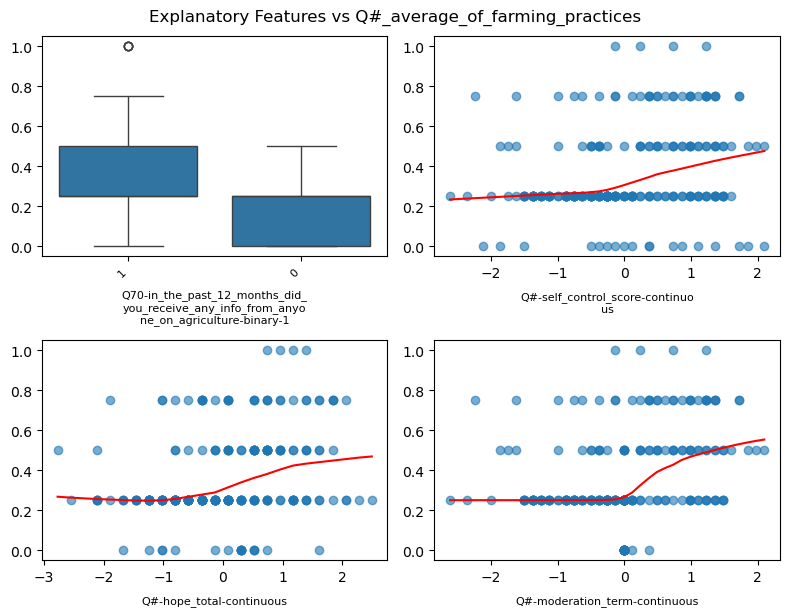

In [ ]:
plot_pairplots(plot_df, ['Q70-in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture-binary-1',
                    'Q#-self_control_score-continuous',
                    'Q#-hope_total-continuous',
                    'Q#-moderation_term-continuous'], ['Q#-average_of_farming_practices-continuous'])

Now we apply GAMs

In [ ]:
from scipy.sparse import csr_matrix, csc_matrix
# re-introduce the .A alias so pygam’s internal code works
csr_matrix.A = property(lambda self: self.toarray())
csc_matrix.A = property(lambda self: self.toarray())

In [ ]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from functools import reduce
from operator import add

def linear_vs_gam_cv(y, X_df):
    X = X_df.values
    y_arr = y.values
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    rmse_lin, rmse_gam = [], []

    # build the combined smooth terms
    terms = reduce(add, (s(i) for i in range(X.shape[1])))

    for tr, va in kf.split(X):
        X_tr, X_va = X[tr], X[va]
        y_tr, y_va = y_arr[tr], y_arr[va]

        # linear RMSE
        lr = LinearRegression().fit(X_tr, y_tr)
        rmse_lin.append(np.sqrt(mean_squared_error(y_va, lr.predict(X_va))))

        # GAM RMSE
        gam = LinearGAM(terms).gridsearch(X_tr, y_tr)
        rmse_gam.append(np.sqrt(mean_squared_error(y_va, gam.predict(X_va))))

    # final GAM fit for edfs
    gam_full = LinearGAM(terms).fit(X, y_arr)
    stats   = gam_full.statistics_

    # extract per‐term edf if available, else fallback
    if 'edof_per_term' in stats:
        edfs = stats['edof_per_term']
    elif 'edof' in stats:
        # spread the total edf equally (or you could choose np.nan)
        p    = X_df.shape[1]
        edfs = [stats['edof'] / p] * p
    else:
        edfs = [np.nan] * X_df.shape[1]

    return np.mean(rmse_lin), np.mean(rmse_gam), edfs

In [ ]:
# diagnostics
diag = []
# Diagnostics for M ~ X1 + X2
lin_rmse_m, gam_rmse_m, edfs_m = linear_vs_gam_cv(df['Q0_average_of_farming_practices'],
                                                  df[['Q70_in_the_past_12_months_did_you_receive_any_info_from_anyone_on_agriculture_binary_1',
                                                      'Q0_self_control_score_continuous',
                                                      'Q0_hope_total_continuous',
                                                      'XM']])
diag.append({
    'Equation': 'Y ~ info + sc + hope + mod',
    'Linear_RMSE': lin_rmse_m,
    'GAM_RMSE':    gam_rmse_m,
    'edf_info':      edfs_m[0],
    'edf_sc':      edfs_m[1],
    'edf_hope':     edfs_m[2],
    'edf_mod':      edfs_m[3]
})

diag_df = pd.DataFrame(diag)
print(diag_df)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 18% (2 of 11) |####                    

                     Equation  Linear_RMSE  GAM_RMSE  edf_info    edf_sc  \
0  Y ~ info + sc + hope + mod     0.189909  0.188498  7.325351  7.325351   

   edf_hope   edf_mod  
0  7.325351  7.325351  


In [ ]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from functools import reduce
from operator import add
import matplotlib.pyplot as plt

def linear_vs_gam_cv(y, X_df, plot_feature=None):
    """
    Runs 5-fold CV comparing linear vs. GAM, returns (rmse_lin, rmse_gam, edfs),
    and then plots for one feature the scatter + linear fit + GAM fit.
    
    Parameters
    ----------
    y : pd.Series
    X_df : pd.DataFrame
    plot_feature : str or None
        Name of column in X_df to plot.  If None, you must have exactly one column,
        otherwise it will default to the first column.
    """
    X = X_df.values
    y_arr = y.values
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    rmse_lin, rmse_gam = [], []

    # build the combined smooth terms
    #terms = reduce(add, (s(i, n_splines=40, spline_order=3) for i in range(X.shape[1])))
    terms = s(0, n_splines=20) #+ f(0)  # spline + low‐order poly

    # 2) Super‐fine λ grid down to almost zero
    lam_grid = np.concatenate([
        np.logspace(-8, -2, 10),    # super‐wiggly end
        np.logspace(-2, 1, 5)       # plus some smoother end
    ])

    # 5-fold CV
    for tr, va in kf.split(X):
        X_tr, X_va = X[tr], X[va]
        y_tr, y_va = y_arr[tr], y_arr[va]

        # linear RMSE
        lr = LinearRegression().fit(X_tr, y_tr)
        rmse_lin.append(np.sqrt(mean_squared_error(y_va, lr.predict(X_va))))

        # GAM RMSE
        gam = LinearGAM(terms).gridsearch(X_tr, y_tr, lam=lam_grid)
        rmse_gam.append(np.sqrt(mean_squared_error(y_va, gam.predict(X_va))))

    # fit full models
    gam_full = LinearGAM(terms, lam=lam_grid[-1]).fit(X, y_arr)
    lr_full  = LinearRegression().fit(X, y_arr)

    # extract per‐term edf if available
    stats = gam_full.statistics_
    if 'edof_per_term' in stats:
        edfs = stats['edof_per_term']
    elif 'edof' in stats:
        p    = X_df.shape[1]
        edfs = [stats['edof']/p]*p
    else:
        edfs = [np.nan]*X_df.shape[1]

    # —— now the plotting —— 
    # pick which column to plot
    if plot_feature is None:
        if X_df.shape[1] == 1:
            j = 0
        else:
            j = 0
            print(f"No plot_feature specified; defaulting to first column: '{X_df.columns[j]}'")
    else:
        j = X_df.columns.get_loc(plot_feature)

    x = X[:, j]
    x_min, x_max = x.min(), x.max()
    x_grid = np.linspace(x_min, x_max, 200)

    # construct a grid for all features (hold others at their median)
    X_grid = np.tile(np.median(X, axis=0), (len(x_grid), 1))
    X_grid[:, j] = x_grid

    y_lin = lr_full.predict(X_grid)
    y_gam = gam_full.predict(X_grid)

    plt.figure(figsize=(8, 5))
    plt.scatter(x, y_arr, alpha=0.3, label='Data')
    plt.plot(x_grid, y_lin, label='Linear fit', linewidth=2)
    plt.plot(x_grid, y_gam, label='GAM fit', linewidth=2)
    plt.xlabel(X_df.columns[j])
    plt.ylabel(y.name if hasattr(y, 'name') else 'y')
    plt.title(f"Linear vs GAM fit for '{X_df.columns[j]}'")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return np.mean(rmse_lin), np.mean(rmse_gam), edfs


In [ ]:
target_cols

['Q#-target1_yearly_income_from_agr_per_land_SQM-continuous',
 'Q#-target2_yearly_income_from_agr_USD-continuous',
 'Q#-target3_veg_per_area-continuous',
 'Q#-target4_self_farming_perception-ordinal']

In [ ]:
for col in df.columns:
    if 'hope' in col:
        print(col)

Q0_hope_total_continuous


In [ ]:
# diagnostics
diag = []
# Diagnostics for M ~ X1 + X2
lin_rmse_m, gam_rmse_m, edfs_m = linear_vs_gam_cv(df['Q#-target1_yearly_income_from_agr_per_land_SQM-continuous'],
                                                  df[['Q#-hope_total-continuous']])
diag.append({
    'Equation': 'Y ~ hope',
    'Linear_RMSE': lin_rmse_m,
    'GAM_RMSE':    gam_rmse_m,
    'edf_hope':      edfs_m[0]
})

diag_df = pd.DataFrame(diag)
print(diag_df)

KeyError: 'Q#-target1_yearly_income_from_agr_per_land_SQM-continuous'

In [ ]:
for col in df.columns:
    if "target3" in col:
        print(col)

Q0_target3_veg_per_area_continuous


In [ ]:
df.columns

Index(['Q0_SurveyLengthTime_time', 'Q1_Latitude_continuous',
       'Q1_Longitude_continuous', 'Q1_Altitude_continuous',
       'Q1_Accuracy_continuous', 'Q4_HasPhoneNumber_binary_1',
       'Q5_AgeYears_continuous', 'Q10_SexMale_binary_1',
       'Q50_How_much_land_that_is_yours_do_you_cultivate_bigha_continuous',
       'Q51_How_much_land_that_is_rented_or_leased_do_you_cultivate_bigha_continuous',
       ...
       'Q113_dislike_not_knowing_what_is_going_to_happen__totally_agree_binary_1',
       'Q113_dislike_not_knowing_what_is_going_to_happen_dislike_not_knowing_what_is_going_to_happen_3_binary_2',
       'Q113_dislike_not_knowing_what_is_going_to_happen_dislike_not_knowing_what_is_going_to_happen_4_binary_3',
       'Q113_dislike_not_knowing_what_is_going_to_happen_dislike_not_knowing_what_is_going_to_happen_5_binary_4',
       'Q113_dislike_not_knowing_what_is_going_to_happen_dislike_not_knowing_what_is_going_to_happen_6_binary_5',
       'Q113_dislike_not_knowing_what_is_going

# Test Visualizations of SEM

In [ ]:


np.random.seed(42)
n = 500

# Simulate latent variables
motivation = np.random.normal(0, 1, n)
anxiety = np.random.normal(0, 1, n)

# Observed indicators (with some added noise)
M1 = 0.8 * motivation + np.random.normal(0, 0.2, n)
M2 = 0.9 * motivation + np.random.normal(0, 0.2, n)
M3 = 0.85 * motivation + np.random.normal(0, 0.2, n)

A1 = 0.9 * anxiety + np.random.normal(0, 0.2, n)
A2 = 0.8 * anxiety + np.random.normal(0, 0.2, n)
A3 = 0.85 * anxiety + np.random.normal(0, 0.2, n)

# Academic performance is influenced by both
academic_perf = 0.7 * motivation - 0.5 * anxiety + np.random.normal(0, 0.3, n)

# Create a DataFrame
df = pd.DataFrame({
    'M1': M1, 'M2': M2, 'M3': M3,
    'A1': A1, 'A2': A2, 'A3': A3,
    'AcademicPerformance': academic_perf
})



In [ ]:
model_desc = """
# Measurement model
Motivation =~ M1 + M2 + M3
Anxiety =~ A1 + A2 + A3

# Structural model
AcademicPerformance ~ Motivation + Anxiety
"""


In [ ]:
from semopy import Model

model = Model(model_desc)
model.fit(df)

# See parameter estimates
estimates = model.inspect()
print(estimates)


                   lval  op                 rval  Estimate  Std. Err  \
0                    M1   ~           Motivation  1.000000         -   
1                    M2   ~           Motivation  1.158976  0.018538   
2                    M3   ~           Motivation  1.077037  0.017565   
3                    A1   ~              Anxiety  1.000000         -   
4                    A2   ~              Anxiety  0.876403  0.014242   
5                    A3   ~              Anxiety  0.918097  0.014149   
6   AcademicPerformance   ~           Motivation  0.873513  0.020674   
7   AcademicPerformance   ~              Anxiety -0.551940  0.016591   
8               Anxiety  ~~              Anxiety  0.794745  0.052667   
9               Anxiety  ~~           Motivation -0.045126  0.031421   
10           Motivation  ~~           Motivation  0.594609  0.040297   
11                   A1  ~~                   A1  0.036922  0.004242   
12                   A2  ~~                   A2  0.048026  0.00

In [ ]:
from semopy import calc_stats
stats = calc_stats(model)
print(stats)


       DoF  DoF Baseline       chi2  chi2 p-value  chi2 Baseline       CFI  \
Value   12            21  18.751205      0.094712    5736.446702  0.998819   

            GFI     AGFI       NFI       TLI     RMSEA        AIC        BIC  \
Value  0.996731  0.99428  0.996731  0.997933  0.033578  31.924995  99.358725   

         LogLik  
Value  0.037502  


In [ ]:
import graphviz
print(graphviz.__version__)   # your python binding
from semopy.plot import semplot
# now semplot() should run without the ModuleNotFoundError


0.20.3


In [ ]:
import os, shutil
print("PATH =", os.environ.get("PATH", ""))  
print("dot found at:", shutil.which("dot"))

PATH = e:\Anaconda3\envs\smallholder-env;E:\Anaconda3\envs\smallholder-env;E:\Anaconda3\envs\smallholder-env\Library\mingw-w64\bin;E:\Anaconda3\envs\smallholder-env\Library\usr\bin;E:\Anaconda3\envs\smallholder-env\Library\bin;E:\Anaconda3\envs\smallholder-env\Scripts;E:\Anaconda3\envs\smallholder-env\bin;E:\Anaconda3\condabin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6\libnvvp;C:\Program Files\Alacritty;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\Program Files\NVIDIA Corporation\Nsight Compute 2022.1.1;C:\Strawberry\c\bin;C:\Strawberry\perl\site\bin;C:\Strawberry\perl\bin;C:\Program Files (x86)\MiKTeX 2.9\miktex\bin;C:\Program Files (x86)\LyX 2.3\Perl\bin;C:\WINDOWS\system3

In [ ]:
# 3. Import and call semplot
from semopy.plot import semplot
# should not raise an error
# semplot will:
#  - draw latent variables as circles, observed as boxes
#  - draw regression arrows (~) and optionally covariances (~~)
#  - annotate edges with (standardized) estimates if desired
g = semplot(model,
            filename="sem_model.png",
            plot_covs=False,    # set True to show covariances (~~)
            std_ests=True,      # show standardized estimates on arrows
            show=True)          # open/view the image after rendering

# Visualizations nearing main method

In [ ]:
# 0. pip install what you need:
#    pip install semopy pygam scipy

import numpy as np
import pandas as pd
from semopy import Model

# 1) Simulate data & fit a standard SEM to get factor scores
np.random.seed(42)
n = 400
# latent vars
mot = np.random.normal(size=n)
anx = np.random.normal(size=n)
# indicators
df = pd.DataFrame({
    'M1': 0.8*mot + np.random.normal(scale=0.2,size=n),
    'M2': 0.9*mot + np.random.normal(scale=0.2,size=n),
    'M3': 0.85*mot+ np.random.normal(scale=0.2,size=n),
    'A1': 0.9*anx + np.random.normal(scale=0.2,size=n),
    'A2': 0.8*anx + np.random.normal(scale=0.2,size=n),
    'A3': 0.85*anx+ np.random.normal(scale=0.2,size=n),
})
# outcome
df['AcademicPerformance'] = 0.7*mot - 0.5*anx + np.random.normal(scale=0.3, size=n)

# fit SEM just to get factor scores
desc = """
  Motivation =~ M1 + M2 + M3
  Anxiety    =~ A1 + A2 + A3
  AcademicPerformance ~ Motivation + Anxiety
"""
sem = Model(desc)
sem.fit(df)
fs = sem.predict_factors(df)
# fs is a DataFrame with columns 'Motivation' and 'Anxiety'
y = df['AcademicPerformance'].values

# ──────────────────────────────────────────────────────────────────────────────
# 2. PIECEWISE STEP #1: Fit each structural equation separately with a GAM
from pygam import LinearGAM, s, l

# In our simple model the only endogenous var is AcademicPerformance,
# with two parents (Motivation, Anxiety).  So we fit a GAM:
X = fs[['Motivation','Anxiety']].values
gam_ap = LinearGAM(s(0) + s(1)).fit(X, y)

# If you had other endogenous nodes, you'd fit one model per node here.
# e.g. if Anxiety were predicted by something else, you'd fit that too.

# ──────────────────────────────────────────────────────────────────────────────
# 3. PIECEWISE STEP #2: List the d-separation claims
#    These are all pairs of variables *not* directly connected by an arrow,
#    conditioning on their “parents.”
#
# In this simple two-arrow model, the only non-adjacent pair is
#   Motivation  _||_  Anxiety
# (they share no path between them in the diagram).
#
# So we test their marginal independence:

from scipy.stats import pearsonr, chi2

r, p_indep = pearsonr(fs['Motivation'], fs['Anxiety'])
print(f"Test M _||_ A:  r = {r:.3f}, p = {p_indep:.3g}")

# You could also test residual correlations between equations if you had more.

# ──────────────────────────────────────────────────────────────────────────────
# 4. PIECEWISE STEP #3: Combine with Fisher’s C
#    C = -2 * Σ log(p_i),   df = 2k,   p_overall = 1 - χ²_cdf(C, df)

p_values = [p_indep]  # add more p’s if you have more independence tests
C = -2 * np.sum(np.log(p_values))
df_fisher = 2 * len(p_values)
p_overall = 1 - chi2.cdf(C, df_fisher)

print(f"Fisher's C = {C:.3f}, df = {df_fisher}, p = {p_overall:.3g}")

# If p_overall > .05, piecewise SEM gives no evidence against the model.

# ──────────────────────────────────────────────────────────────────────────────
# 5. (Optional) Inspect each GAM’s summary
print(gam_ap.summary())


Test M _||_ A:  r = -0.108, p = 0.0301
Fisher's C = 7.007, df = 2, p = 0.0301
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     21.4628
Link Function:                     IdentityLink Log Likelihood:                                 -1517.3297
Number of Samples:                          400 AIC:                                             3079.5851
                                                AICc:                                            3082.3845
                                                GCV:                                                 0.099
                                                Scale:                                              0.0895
                                                Pseudo R-Squared: 

C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\1609559100.py:83: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam_ap.summary())


In [ ]:
from scipy.sparse import csr_matrix, csc_matrix
# re-introduce the .A alias so pygam’s internal code works
csr_matrix.A = property(lambda self: self.toarray())
csc_matrix.A = property(lambda self: self.toarray())

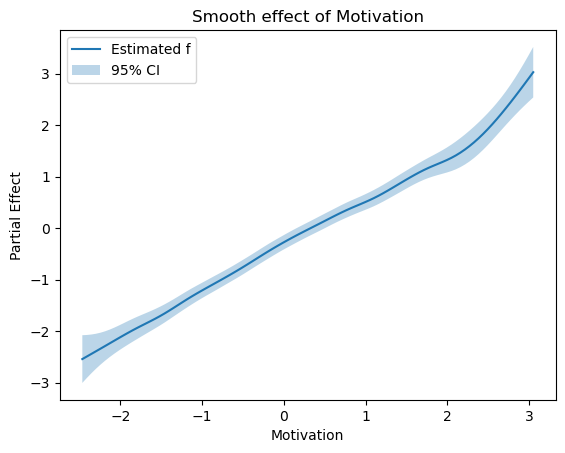

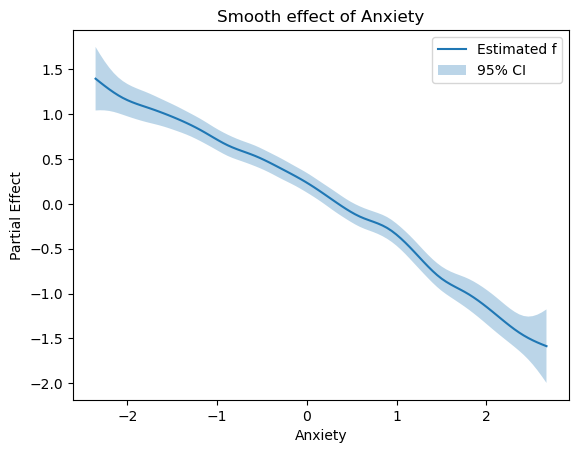

In [ ]:
import matplotlib.pyplot as plt

terms = ['Motivation','Anxiety']
for i, name in enumerate(terms):
    # 1) grid of values for term i
    XX = gam_ap.generate_X_grid(term=i)

    # 2) get partial dependence AND confidence band in one call
    pdp, ci = gam_ap.partial_dependence(term=i, X=XX, width=0.95)

    # 3) plot
    plt.figure()
    plt.plot(XX[:, i], pdp, label='Estimated f')
    plt.fill_between(
        XX[:, i],
        ci[:, 0],   # lower bound
        ci[:, 1],   # upper bound
        alpha=0.3,
        label='95% CI'
    )
    plt.title(f"Smooth effect of {name}")
    plt.xlabel(name)
    plt.ylabel("Partial Effect")
    plt.legend()
    plt.show()




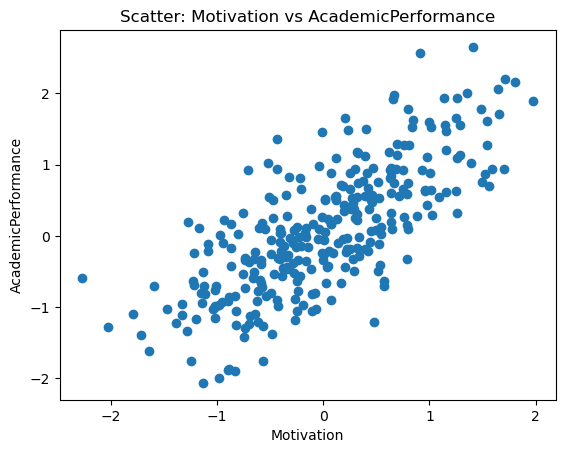

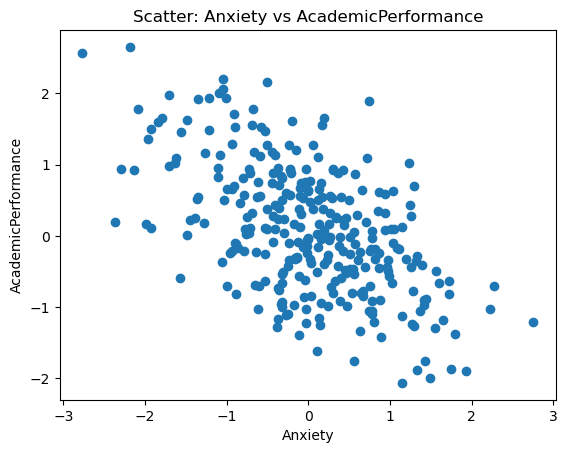

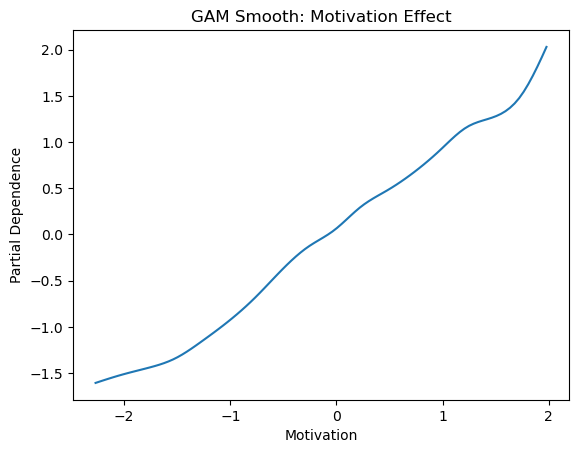

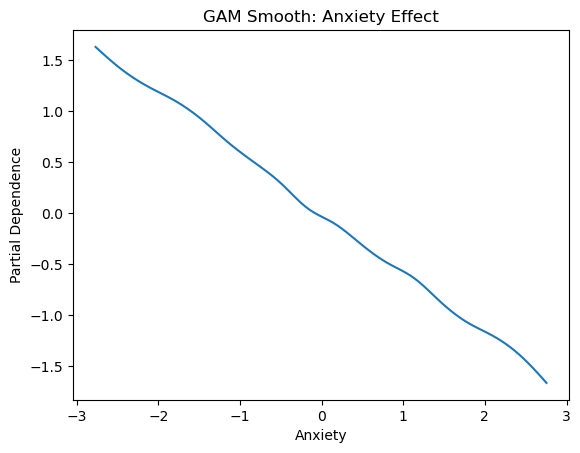

      Feature  AverageMarginalEffect
0  Motivation               0.861317
1     Anxiety              -0.598973
meadiajn anx: -0.6043821336830693


In [ ]:
import numpy as np
import pandas as pd
from semopy import Model
from pygam import LinearGAM, s
import matplotlib.pyplot as plt

# 1) Simulate a dummy dataset
np.random.seed(0)
n = 300
mot = np.random.normal(size=n)
anx = np.random.normal(size=n)
df = pd.DataFrame({
    'M1': 0.8*mot + np.random.normal(scale=0.2, size=n),
    'M2': 0.9*mot + np.random.normal(scale=0.2, size=n),
    'M3': 0.85*mot+ np.random.normal(scale=0.2, size=n),
    'A1': 0.9*anx + np.random.normal(scale=0.2, size=n),
    'A2': 0.8*anx + np.random.normal(scale=0.2, size=n),
    'A3': 0.85*anx+ np.random.normal(scale=0.2, size=n),
    'AcademicPerformance': 0.7*mot - 0.5*anx + np.random.normal(scale=0.3, size=n)
})

# 2) Define & fit the SEM
model_desc = """
  Motivation =~ M1 + M2 + M3
  Anxiety    =~ A1 + A2 + A3
  AcademicPerformance ~ Motivation + Anxiety
"""
sem = Model(model_desc)
sem.fit(df)

# 3) Extract factor scores
fs = sem.predict_factors(df)
X = fs[['Motivation','Anxiety']].values
y = df['AcademicPerformance'].values

# 4) Fit a GAM for the structural part
gam = LinearGAM(s(0) + s(1)).fit(X, y)

# 5) Prepare grids and partial‐dependence
grid_mot = np.linspace(fs['Motivation'].min(), fs['Motivation'].max(), 100)
grid_anx = np.linspace(fs['Anxiety'].min(),    fs['Anxiety'].max(),    100)

X_mot = np.column_stack([grid_mot, np.repeat(fs['Anxiety'].mean(), len(grid_mot))])
X_anx = np.column_stack([np.repeat(fs['Motivation'].mean(), len(grid_anx)), grid_anx])

pd_mot = gam.partial_dependence(term=0, X=X_mot)
pd_anx = gam.partial_dependence(term=1, X=X_anx)

# 6) Plot raw data vs. latent scores
plt.figure()
plt.scatter(fs['Motivation'], y)
plt.xlabel('Motivation')
plt.ylabel('AcademicPerformance')
plt.title('Scatter: Motivation vs AcademicPerformance')
plt.show()

plt.figure()
plt.scatter(fs['Anxiety'], y)
plt.xlabel('Anxiety')
plt.ylabel('AcademicPerformance')
plt.title('Scatter: Anxiety vs AcademicPerformance')
plt.show()

# 7) Plot the GAM smooth functions
plt.figure()
plt.plot(grid_mot, pd_mot)
plt.xlabel('Motivation')
plt.ylabel('Partial Dependence')
plt.title('GAM Smooth: Motivation Effect')
plt.show()

plt.figure()
plt.plot(grid_anx, pd_anx)
plt.xlabel('Anxiety')
plt.ylabel('Partial Dependence')
plt.title('GAM Smooth: Anxiety Effect')
plt.show()

# 8) Approximate derivatives & compute AMEs (unchanged)
deriv_mot = np.gradient(pd_mot, grid_mot)
deriv_anx = np.gradient(pd_anx, grid_anx)
ame_mot = deriv_mot.mean()
ame_anx = deriv_anx.mean()

ame_df = pd.DataFrame({
    'Feature': ['Motivation', 'Anxiety'],
    'AverageMarginalEffect': [ame_mot, ame_anx]
})
print(ame_df)

print(f"meadiajn anx: {np.median(deriv_anx)}")

# Main Method Found Thank God

In [ ]:
import numpy as np
import pandas as pd
from semopy import Model, calc_stats
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, chi2
from functools import reduce
from operator import add

# 0) Simulate and split data
np.random.seed(42)
n = 300
X1 = np.random.normal(size=n)
X2 = np.random.normal(size=n)
M  = 0.5*np.sin(X1) + 0.3*X2**2 + np.random.normal(0,0.1,n)
Y  = 0.7*M + 0.2*X1 + 0.1*np.log(np.abs(X2)+1) + np.random.normal(0,0.1,n)
df    = pd.DataFrame(dict(X1=X1, X2=X2, M=M, Y=Y))
train = df.sample(frac=0.7, random_state=1)
test  = df.drop(train.index)

# 1) Fit initial SEM on train
model_desc = """
M ~ X1 + X2
Y ~ M + X1 + X2
"""
sem = Model(model_desc)
sem.fit(train)

# 2) Global SEM fit on train
stats = calc_stats(sem)
# extract scalars
chi2_scaler  = float(stats['chi2'])
cfi   = float(stats['CFI'])
tli   = float(stats['TLI'])
rmsea = float(stats['RMSEA'])
aic   = float(stats['AIC'])
bic   = float(stats['BIC'])

fit_df = pd.DataFrame({
    'Statistic': ['Chi-square (p>0.05)', 'CFI (>=0.95)', 'TLI (>=0.95)', 'RMSEA (<=0.05)', 'AIC', 'BIC'],
    'Value':     [chi2_scaler, cfi, tli, rmsea, aic, bic]
})

# 3) Cross-validated RMSE vs. GAM for non-linearity diagnostics
def linear_vs_gam_cv(y, X_df):
    X = X_df.values
    y_arr = y.values
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    rmse_lin, rmse_gam = [], []

    # build the combined smooth terms
    terms = reduce(add, (s(i) for i in range(X.shape[1])))

    for tr, va in kf.split(X):
        X_tr, X_va = X[tr], X[va]
        y_tr, y_va = y_arr[tr], y_arr[va]

        # linear RMSE
        lr = LinearRegression().fit(X_tr, y_tr)
        rmse_lin.append(np.sqrt(mean_squared_error(y_va, lr.predict(X_va))))

        # GAM RMSE
        gam = LinearGAM(terms).gridsearch(X_tr, y_tr)
        rmse_gam.append(np.sqrt(mean_squared_error(y_va, gam.predict(X_va))))

    # final GAM fit for edfs
    gam_full = LinearGAM(terms).fit(X, y_arr)
    stats   = gam_full.statistics_

    # extract per‐term edf if available, else fallback
    if 'edof_per_term' in stats:
        edfs = stats['edof_per_term']
    elif 'edof' in stats:
        # spread the total edf equally (or you could choose np.nan)
        p    = X_df.shape[1]
        edfs = [stats['edof'] / p] * p
    else:
        edfs = [np.nan] * X_df.shape[1]

    return np.mean(rmse_lin), np.mean(rmse_gam), edfs

# diagnostics
diag = []
# Diagnostics for M ~ X1 + X2
lin_rmse_m, gam_rmse_m, edfs_m = linear_vs_gam_cv(train['M'], train[['X1','X2']])
diag.append({
    'Equation': 'M ~ X1,X2',
    'Linear_RMSE': lin_rmse_m,
    'GAM_RMSE':    gam_rmse_m,
    'edf_X1':      edfs_m[0],
    'edf_X2':      edfs_m[1]
})
# Diagnostics for Y ~ M,X1,X2
lin_rmse_y, gam_rmse_y, edfs_y = linear_vs_gam_cv(train['Y'], train[['M','X1','X2']])
diag.append({
    'Equation': 'Y ~ M,X1,X2',
    'Linear_RMSE': lin_rmse_y,
    'GAM_RMSE':    gam_rmse_y,
    'edf_M':       edfs_y[0],
    'edf_X1':      edfs_y[1],
    'edf_X2':      edfs_y[2]
})

diag_df = pd.DataFrame(diag)

# 4) Correct d-separation test: test only exogenous pair X1 ⟂ X2
r12, p12 = pearsonr(train['X1'], train['X2'])
C = -2*np.log(p12)
p_fish = 1 - chi2.cdf(C, 2)
dsep_df = pd.DataFrame({
    'Test': ['X1 ⟂ X2'],
    'r':     [r12],
    'p-value': [p12],
    'Fisher_C': [C],
    'Fisher_p': [p_fish]
})

# 5) Compute final GAM AMEs on train
def compute_ame(gam, term, grid, means):
    X = np.column_stack([
        grid if i == term else np.repeat(means[i], grid.size)
        for i in range(len(means))
    ])
    f = gam.partial_dependence(term=term, X=X)
    d = np.gradient(f, grid)
    return d.mean()

# Fit GAMs
gam_m = LinearGAM(s(0) + s(1)).fit(train[['X1','X2']], train['M'])
gam_y = LinearGAM(s(0) + s(1) + s(2)).fit(train[['M','X1','X2']], train['Y'])

# Grids and means
grid_X1 = np.linspace(train.X1.min(), train.X1.max(), 200)
grid_X2 = np.linspace(train.X2.min(), train.X2.max(), 200)
grid_M  = np.linspace(train.M.min(),  train.M.max(),  200)
mean_MX = [train.M.mean(), train.X1.mean(), train.X2.mean()]
mean_X  = [train.X1.mean(), train.X2.mean()]

ame_results = {
    'Path': ['M ~ X1', 'M ~ X2', 'Y ~ M', 'Y ~ X1', 'Y ~ X2'],
    'Train_AME': [
        compute_ame(gam_m, 0, grid_X1, mean_X),
        compute_ame(gam_m, 1, grid_X2, mean_X),
        compute_ame(gam_y, 0, grid_M, mean_MX),
        compute_ame(gam_y, 1, grid_X1, mean_MX),
        compute_ame(gam_y, 2, grid_X2, mean_MX),
    ]
}

ame_train_df = pd.DataFrame(ame_results)

# 6) Validate AMEs on test set
# Fit same GAMs on test
gam_m_t = LinearGAM(s(0) + s(1)).fit(test[['X1','X2']], test['M'])
gam_y_t = LinearGAM(s(0) + s(1) + s(2)).fit(test[['M','X1','X2']], test['Y'])

ame_results['Test_AME'] = [
    compute_ame(gam_m_t, 0, grid_X1, mean_X),
    compute_ame(gam_m_t, 1, grid_X2, mean_X),
    compute_ame(gam_y_t, 0, grid_M, mean_MX),
    compute_ame(gam_y_t, 1, grid_X1, mean_MX),
    compute_ame(gam_y_t, 2, grid_X2, mean_MX),
]
ame_full_df = pd.DataFrame(ame_results)

# Display all results
print("SEM Global Fit")
print(fit_df)
print("GAM Diagnostics (AIC & edf)")
print(diag_df)
print("D-separation Residual Test & Fisher's C")
print(dsep_df)
print("Average Marginal Effects: Train vs Test")
print(ame_full_df)


C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\3438924327.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  chi2_scaler  = float(stats['chi2'])
C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\3438924327.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  cfi   = float(stats['CFI'])
C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\3438924327.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tli   = float(stats['TLI'])
C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\3438924327.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rmsea = float(stats['RMSEA'])
C:\Users\nadav\AppData\Loc

SEM Global Fit
             Statistic      Value
0  Chi-square (p>0.05)   0.000063
1         CFI (>=0.95)   1.003816
2         TLI (>=0.95)   1.010175
3       RMSEA (<=0.05)   0.000000
4                  AIC  13.999999
5                  BIC  37.429752
GAM Diagnostics (AIC & edf)
      Equation  Linear_RMSE  GAM_RMSE     edf_X1     edf_X2     edf_M
0    M ~ X1,X2     0.399807  0.098230  10.284292  10.284292       NaN
1  Y ~ M,X1,X2     0.103257  0.099995   9.897982   9.897982  9.897982
D-separation Residual Test & Fisher's C
      Test         r   p-value  Fisher_C  Fisher_p
0  X1 ⟂ X2 -0.080592  0.244905  2.813766  0.244905
Average Marginal Effects: Train vs Test
     Path  Train_AME  Test_AME
0  M ~ X1   0.115361  0.146613
1  M ~ X2  -0.051154 -0.002528
2   Y ~ M   0.628561  0.817706
3  Y ~ X1   0.200574  0.186789
4  Y ~ X2  -0.030593 -0.006018


In [ ]:
import numpy as np
import pandas as pd
from semopy import Model, calc_stats
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from pygam import LinearGAM, s
import networkx as nx
import matplotlib.pyplot as plt

# 1. Generate dummy data
np.random.seed(0)
n = 300

# Latent psychological constructs (Hope, Risk)
# Simulate latent factors
hope_latent = np.random.normal(0, 1, n)
risk_latent = np.random.normal(0, 1, n)

# Manifest indicators (with noise)
data = pd.DataFrame({
    'hope1': 0.8 * hope_latent + np.random.normal(0, 0.5, n),
    'hope2': 0.9 * hope_latent + np.random.normal(0, 0.5, n),
    'hope3': 0.7 * hope_latent + np.random.normal(0, 0.5, n),
    'risk1': 0.6 * risk_latent + np.random.normal(0, 0.5, n),
    'risk2': 0.8 * risk_latent + np.random.normal(0, 0.5, n),
    'risk3': 0.7 * risk_latent + np.random.normal(0, 0.5, n),
})

# Outcomes
# Initial bivariate associations
data['prod1'] = 1.2 * hope_latent + np.random.normal(0, 1, n)
data['prod2'] = -0.8 * risk_latent + np.random.normal(0, 1, n)

# 2. SEM specification (CFA + regressions)
model_desc = """
# Measurement models for latent constructs
Hope =~ hope1 + hope2 + hope3
Risk =~ risk1 + risk2 + risk3

# Structural regressions (initially both paths)
prod1 ~ Hope
prod2 ~ Risk
"""

# 3. Fit SEM with LASSO penalty to select edges
sem = Model(model_desc)
# semopy allows penalized fitting; here we use LASSO on regression paths
np.int = int
from semopy import create_regularization

all_names = sem.parameters.keys()                  # all model parameters
regr_names = [n for n in all_names if '~' in n]       # filter to regressions only

reg = create_regularization(model=sem, regularization='l1-thresh', c=0.1, param_names=regr_names)
sem.fit(data, obj='MLW', regularization=reg)

# 4. In-sample fit indices
stats = calc_stats(sem)
print("In-sample fit indices:")
print(stats[['chi2', 'chi2 p-value', 'DoF', 'RMSEA', 'CFI', 'TLI', 'AIC']])

# 5. K-fold CV for SEM predictive power
kf = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_out = {y: [] for y in ['prod1','prod2']}

for train_idx, test_idx in kf.split(data):
    train_df = data.iloc[train_idx]
    test_df = data.iloc[test_idx]

    sem_cv = Model(model_desc)
    # Build the L1 penalty for this sem_cv instance
    reg_cv = create_regularization(
        model=sem_cv,
        regularization='l1-thresh',
        c=0.1,
        param_names=regr_names
    )
    sem_cv.fit(train_df, obj='MLW', regularization=reg_cv)
    # After fitting sem_cv on train_df:
    # 1. Estimate latent scores for the test set
    factors_test = sem_cv.predict_factors(test_df)
    # This yields columns ["Hope", "Risk"] corresponding to your two latent constructs

    # 2. Merge the factor scores into test_df
    test_aug = test_df.join(factors_test)

    # 3. Now build predictions using latent factors instead of missing ones
    coef_df = sem_cv.inspect()
    preds = {}
    for y in ['prod1','prod2']:
        regr = coef_df[(coef_df['op']=='~') & (coef_df['lval']==y)]
        if '1' in regr['rval'].values:
            intercept = regr.loc[regr['rval']=='1','Estimate'].iloc[0]
            regr = regr[regr['rval']!='1']
        else:
            intercept = 0.0
        coefs = regr.set_index('rval')['Estimate']
        # Now `coefs.index` will include "Hope" or "Risk"
        preds[y] = test_aug[coefs.index].dot(coefs) + intercept

    # then compute per-fold RMSE
    for y in preds:
        rmse_out[y].append(
            root_mean_squared_error(test_df[y], preds[y])
        )

# After the loop
print({y: np.mean(vals) for y, vals in rmse_out.items()})

from pygam.utils import gen_edge_knots  # public utility :contentReference[oaicite:12]{index=12}

# 6. If fit & CV OK, refine each surviving arrow with GAM
# Get regression edges from sem.inspect()
params = sem.inspect()
surviving = params[(params['op'] == '~') & (np.abs(params['Estimate']) > 1e-3)]
results = {}

for _, row in surviving.iterrows():
    parent = row['rval']
    child = row['lval']
    X = data[[parent]].values
    # Partial out other parents
    other_parents = surviving[surviving['lval'] == child]['rval'].tolist()
    other_parents.remove(parent)
    if other_parents:
        lm = LinearRegression().fit(data[other_parents], data[child])
        y_star = data[child] - lm.predict(data[other_parents])
    else:
        y_star = data[child].values

    # Linear vs. GAM
    lin = LinearRegression().fit(X, y_star)
    rss_lin = ((y_star - lin.predict(X))**2).sum()
    k_lin = 2  # intercept + slope
    gam = LinearGAM(s(0, n_splines=5)).fit(X, y_star)
    rss_gam = ((y_star - gam.predict(X))**2).sum()
    k_gam = gam.statistics_['edof']
    aic_lin = len(y_star)*np.log(rss_lin/len(y_star)) + 2*k_lin
    aic_gam = len(y_star)*np.log(rss_gam/len(y_star)) + 2*k_gam

    if aic_gam + 2 < aic_lin:
        # Nonlinear wins
        # Suppose X is your one-dimensional feature array for this term:
        edge_min, edge_max = gen_edge_knots(X.flatten(), dtype='numerical')
        n_splines = gam.terms[0].info['n_splines']  # from SplineTerm info :contentReference[oaicite:13]{index=13}

        knots = np.linspace(edge_min, edge_max, n_splines)
        deriv = gam.partial_derivative(X)
        avg_effects = [
            deriv[(X[:,0]>=knots[i]) & (X[:,0]<knots[i+1])].mean()
            for i in range(len(knots)-1)
        ]
        results[f"{parent}->{child}"] = {
            'type': 'GAM',
            'knots': knots.tolist(),
            'avg_effects': avg_effects
        }
    else:
        # Keep linear
        results[f"{parent}->{child}"] = {
            'type': 'linear',
            'beta': lin.coef_[0]
        }

print("Edge refinements:")
print(results)

# 7. Plot SEM graph
G = nx.DiGraph()
for edge, info in results.items():
    p, c = edge.split('->')
    label = ""
    if info['type'] == 'linear':
        label = f"{info['beta']:.2f}"
    else:
        label = "GAM"
    G.add_edge(p, c, label=label)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()


In-sample fit indices:
            chi2  chi2 p-value  DoF    RMSEA       CFI       TLI        AIC
Value  24.945185      0.162354   19  0.03235  0.995498  0.993365  33.833699


ValueError: Input contains NaN.

In-sample fit indices:
            chi2  chi2 p-value  DoF     RMSEA       CFI       TLI        AIC
Value  23.859808      0.201585   19  0.029248  0.996429  0.994738  33.840935
CV RMSE: {'prod1': np.float64(2.2508456956427625), 'prod2': np.float64(0.8783966787672449)}
Edge refinements:
{'Hope->prod1': {'type': 'GAM', 'knots': [-2.8827914184063403, -1.5903240889894525, -0.29785675957256474, 0.9946105698443231, 2.287077899261211], 'avg_effects': [np.float64(5.383240595456474), np.float64(4.666042159852257), np.float64(4.370400877065564), np.float64(4.482371009543537)]}, 'Risk->prod2': {'type': 'linear', 'beta': np.float64(-1.4461820798780696)}}


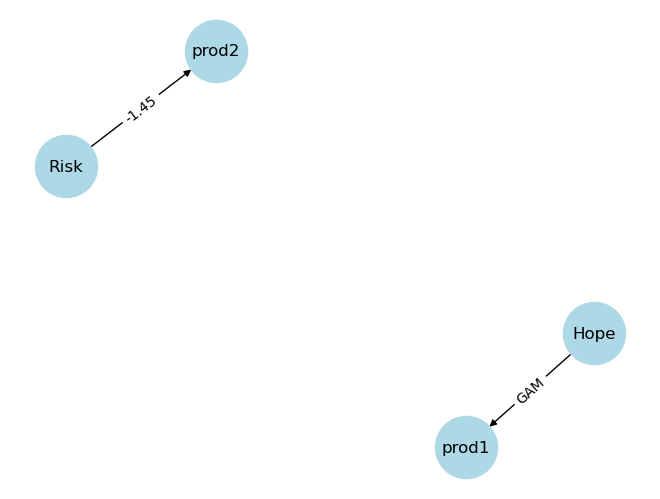

In [ ]:
import numpy as np
import pandas as pd

# Restore np.int for semopy compatibility (NumPy ≥1.24)
np.int = int

from semopy import Model, calc_stats, create_regularization
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s
from pygam.utils import gen_edge_knots
import networkx as nx
import matplotlib.pyplot as plt

# 1. Generate dummy data
np.random.seed(0)
n = 300
hope_latent = np.random.normal(size=n)
risk_latent = np.random.normal(size=n)

data = pd.DataFrame({
    'hope1': 0.8 * hope_latent + np.random.normal(scale=0.5, size=n),
    'hope2': 0.9 * hope_latent + np.random.normal(scale=0.5, size=n),
    'hope3': 0.7 * hope_latent + np.random.normal(scale=0.5, size=n),
    'risk1': 0.6 * risk_latent + np.random.normal(scale=0.5, size=n),
    'risk2': 0.8 * risk_latent + np.random.normal(scale=0.5, size=n),
    'risk3': 0.7 * risk_latent + np.random.normal(scale=0.5, size=n),
})
data['prod1'] = 1.2 * hope_latent**3 + np.random.normal(scale=1, size=n)
data['prod2'] = -0.8 * risk_latent + np.random.normal(scale=1, size=n)

# 2. SEM specification
model_desc = """
Hope =~ hope1 + hope2 + hope3
Risk =~ risk1 + risk2 + risk3

prod1 ~ Hope
prod2 ~ Risk
"""

# 3. Fit SEM with L1-threshold penalty
sem = Model(model_desc)
all_params  = list(sem.parameters.keys())
regr_params = [p for p in all_params if '~' in p]

reg = create_regularization(
    model=sem,
    regularization='l1-thresh',
    c=0.1,
    param_names=regr_params
)
sem.fit(data, obj='MLW', regularization=reg)

# 4. In-sample fit indices
stats = calc_stats(sem)
print("In-sample fit indices:")
print(stats[['chi2','chi2 p-value','DoF','RMSEA','CFI','TLI','AIC']])

# 5. 5-fold CV for true out-of-sample RMSE
kf = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_out = {y: [] for y in ['prod1','prod2']}

for train_idx, test_idx in kf.split(data):
    train_df = data.iloc[train_idx]
    test_df  = data.iloc[test_idx]

    # (a) fit penalized SEM on train fold
    sem_cv = Model(model_desc)
    reg_cv = create_regularization(
        model=sem_cv,
        regularization='l1-thresh',
        c=0.1,
        param_names=regr_params
    )
    sem_cv.fit(train_df, obj='MLW', regularization=reg_cv)

    # (b) estimate factor scores on hold-out and merge
    f_test       = sem_cv.predict_factors(test_df)
    f_test.index = test_df.index
    test_aug     = pd.concat([test_df, f_test], axis=1)

    # (c) build out-of-sample preds using inspect()
    coef_df = sem_cv.inspect()
    preds   = {}
    for y in ['prod1','prod2']:
        regr = coef_df[(coef_df['op']=='~') & (coef_df['lval']==y)]
        # extract intercept
        if '1' in set(regr['rval']):
            intercept = regr.loc[regr['rval']=='1','Estimate'].iloc[0]
            regr      = regr[regr['rval']!='1']
        else:
            intercept = 0.0
        coefs = regr.set_index('rval')['Estimate']
        preds[y] = test_aug[coefs.index].dot(coefs) + intercept

    # (d) compute RMSE for this fold
    for y, y_pred in preds.items():
        y_true = test_aug[y]
        mse    = mean_squared_error(y_true, y_pred)
        rmse_out[y].append(np.sqrt(mse))

# report average CV-RMSE
print("CV RMSE:", {y: np.mean(v) for y, v in rmse_out.items()})

# 6. GAM-based edge refinement on the full dataset
# first augment the full data with its factor scores
f_full        = sem.predict_factors(data)
f_full.index  = data.index
data_aug_full = pd.concat([data, f_full], axis=1)

params    = sem.inspect()
# only structural regressions on prod1 and prod2:
surviving = params[
    (params['op']=='~') &
    (params['lval'].isin(['prod1','prod2'])) &
    (params['Estimate'].abs()>1e-3)
]
results = {}

for _, row in surviving.iterrows():
    parent, child = row['rval'], row['lval']
    X = data_aug_full[[parent]].values

    # partial-out other structural parents (none in this simple model)
    others = list(surviving[surviving['lval']==child]['rval'])
    others.remove(parent)
    if others:
        lm     = LinearRegression().fit(data_aug_full[others], data_aug_full[child])
        y_star = data_aug_full[child] - lm.predict(data_aug_full[others])
    else:
        y_star = data_aug_full[child].values

    # Linear vs GAM
    lin     = LinearRegression().fit(X, y_star)
    rss_lin = ((y_star - lin.predict(X))**2).sum()
    k_lin   = 2

    gam     = LinearGAM(s(0, n_splines=5)).fit(X, y_star)
    rss_gam = ((y_star - gam.predict(X))**2).sum()
    k_gam   = gam.statistics_['edof']

    aic_lin = len(y_star)*np.log(rss_lin/len(y_star)) + 2*k_lin
    aic_gam = len(y_star)*np.log(rss_gam/len(y_star)) + 2*k_gam

    if aic_gam + 2 < aic_lin:
        emin, emax   = gen_edge_knots(X.flatten(), dtype='numerical')
        n_spl        = gam.terms[0].info['n_splines']
        knots        = np.linspace(emin, emax, n_spl)
        # 2) choose a small step for finite differences
        eps = (emax - emin) / 200.0

        # 3) flatten X for vectorized prediction
        X_flat = X.flatten()

        # 4) compute +eps and –eps predictions
        pred_plus  = gam.predict((X_flat + eps).reshape(-1, 1))
        pred_minus = gam.predict((X_flat - eps).reshape(-1, 1))

        # 5) approximate derivative
        deriv = (pred_plus - pred_minus) / (2 * eps)

        # 6) average effects over each knot interval
        avg_effects = [
            deriv[(X_flat >= knots[i]) & (X_flat < knots[i+1])].mean()
            for i in range(len(knots)-1)
        ]
        results[f"{parent}->{child}"] = {
            'type': 'GAM',
            'knots': knots.tolist(),
            'avg_effects': avg_effects
        }
    else:
        results[f"{parent}->{child}"] = {
            'type': 'linear',
            'beta': lin.coef_[0]
        }

print("Edge refinements:")
print(results)

# 7. Plot SEM graph
G = nx.DiGraph()
for edge, info in results.items():
    p, c = edge.split('->')
    lbl  = f"{info['beta']:.2f}" if info['type']=='linear' else "GAM"
    G.add_edge(p, c, label=lbl)

pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G,'label'))
plt.show()



In-sample fit indices:
             chi2  chi2 p-value  DoF     RMSEA       CFI       TLI        AIC
Value  117.188037  9.451271e-10   39  0.063385  0.984441  0.978058  53.531248
CV RMSE: {'prod1': np.float64(0.6345478170602673), 'prod2': np.float64(0.42336653404164926)}
Edge refinements:
{'Motivation->prod1': {'type': 'GAM', 'knots': [-1.6587677609933926, -0.7850702409598015, 0.08862727907378964, 0.9623247991073807, 1.836022319140972], 'avg_effects': [np.float64(1.5119378647315784), np.float64(1.7384336346134182), np.float64(1.7163444047859395), np.float64(1.4937190051204097)]}, 'Hope->prod1': {'type': 'linear', 'beta': np.float64(1.138671428512716)}, 'Risk->prod2': {'type': 'linear', 'beta': np.float64(-1.3779927298875925)}, 'Motivation->prod2': {'type': 'linear', 'beta': np.float64(1.0266703724567774)}}


C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\1622841917.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


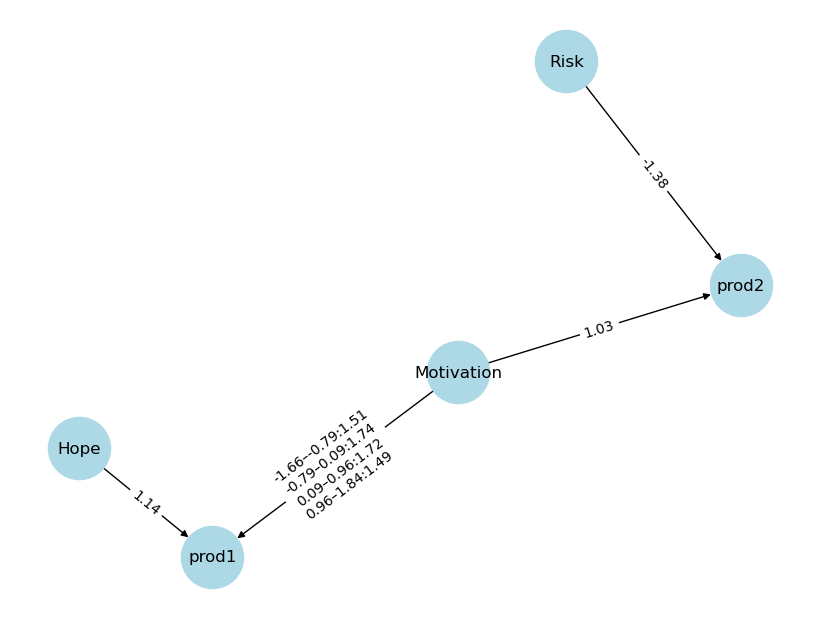

In [ ]:
import numpy as np
import pandas as pd

# Restore np.int for semopy compatibility (NumPy ≥1.24)
np.int = int

from semopy import Model, calc_stats, create_regularization
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s
from pygam.utils import gen_edge_knots
import networkx as nx
import matplotlib.pyplot as plt

# 1. Generate dummy data (more complex)
np.random.seed(0)
n = 500

# Three correlated latent factors: Hope, Risk, Motivation
# Base draws
base       = np.random.multivariate_normal(
    mean=[0,0,0],
    cov=[[1,  0.5, 0.3],
         [0.5,1,   0.2],
         [0.3,0.2, 1  ]],
    size=n
)
hope_lat, risk_lat, mot_lat = base.T

# Manifest indicators with differing loadings & noise
data = pd.DataFrame({
    # Hope indicators
    'hope1': 0.7*hope_lat + np.random.normal(0,0.3,n),
    'hope2': 0.8*hope_lat + np.random.normal(0,0.3,n),
    'hope3': 0.6*hope_lat + np.random.normal(0,0.3,n),
    # Risk indicators
    'risk1': 0.5*risk_lat + np.random.normal(0,0.4,n),
    'risk2': 0.9*risk_lat + np.random.normal(0,0.4,n),
    'risk3': 0.7*risk_lat + np.random.normal(0,0.4,n),
    # Motivation indicators (cross‐loading subtlety)
    'mot1': 0.6*mot_lat + 0.1*hope_lat + np.random.normal(0,0.3,n),
    'mot2': 0.8*mot_lat + 0.2*risk_lat + np.random.normal(0,0.3,n),
    'mot3': 0.7*mot_lat + np.random.normal(0,0.3,n),
})

# Outcomes with mixed effects
# prod1 driven nonlinearly by Motivation and linearly by Hope
data['prod1'] = 1.5 * np.sin(mot_lat) + 0.5 * hope_lat + np.random.normal(0,0.5,n)
# prod2 driven linearly by Risk and Motivation
data['prod2'] = -0.7 * risk_lat + 0.8 * mot_lat + np.random.normal(0,0.5,n)

# 2. SEM specification (CFA + structural complexity)
model_desc = """
# Measurement models
Hope       =~ hope1 + hope2 + hope3
Risk       =~ risk1 + risk2 + risk3
Motivation =~ mot1   + mot2   + mot3

# Structural regressions
Motivation ~ Hope + Risk       # Motivation is downstream of both
prod1      ~ Motivation + Hope # allows direct & indirect Hope→prod1
prod2      ~ Risk + Motivation # allows both Risk→prod2 paths

# Covariances among exogenous latents
Hope ~~ Risk
"""

# 3. Fit SEM with L1-threshold penalty
sem = Model(model_desc)
all_params  = list(sem.parameters.keys())
regr_params = [p for p in all_params if '~' in p]

reg = create_regularization(
    model=sem,
    regularization='l1-thresh',
    c=0.1,
    param_names=regr_params
)
sem.fit(data, obj='MLW', regularization=reg)

# 4. In-sample fit indices
stats = calc_stats(sem)
print("In-sample fit indices:")
print(stats[['chi2','chi2 p-value','DoF','RMSEA','CFI','TLI','AIC']])

# 5. 5-fold CV for true out-of-sample RMSE
kf = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_out = {y: [] for y in ['prod1','prod2']}

for train_idx, test_idx in kf.split(data):
    train_df = data.iloc[train_idx]
    test_df  = data.iloc[test_idx]

    sem_cv = Model(model_desc)
    reg_cv = create_regularization(
        model=sem_cv,
        regularization='l1-thresh',
        c=0.1,
        param_names=regr_params
    )
    sem_cv.fit(train_df, obj='MLW', regularization=reg_cv)

    # factor‐score imputation on holdout
    f_test       = sem_cv.predict_factors(test_df)
    f_test.index = test_df.index
    test_aug     = pd.concat([test_df, f_test], axis=1)

    coef_df = sem_cv.inspect()
    preds   = {}
    for y in ['prod1','prod2']:
        regr = coef_df[(coef_df['op']=='~') & (coef_df['lval']==y)]
        if '1' in set(regr['rval']):
            intercept = regr.loc[regr['rval']=='1','Estimate'].iloc[0]
            regr      = regr[regr['rval']!='1']
        else:
            intercept = 0.0
        coefs     = regr.set_index('rval')['Estimate']
        preds[y]  = test_aug[coefs.index].dot(coefs) + intercept

    for y, y_pred in preds.items():
        y_true = test_aug[y]
        mse    = mean_squared_error(y_true, y_pred)
        rmse_out[y].append(np.sqrt(mse))

print("CV RMSE:", {y: np.mean(vals) for y, vals in rmse_out.items()})

# 6. GAM-based edge refinement on the full dataset
# first augment with full-data factor scores
f_full        = sem.predict_factors(data)
f_full.index  = data.index
data_aug_full = pd.concat([data, f_full], axis=1)

params    = sem.inspect()
surviving = params[
    (params['op']=='~') &
    (params['lval'].isin(['prod1','prod2'])) &
    (params['Estimate'].abs()>1e-3)
]
results = {}

for _, row in surviving.iterrows():
    parent, child = row['rval'], row['lval']
    X = data_aug_full[[parent]].values

    # no other parents in this simple model
    y_star = data_aug_full[child].values

    # fit linear & GAM
    lin     = LinearRegression().fit(X, y_star)
    rss_lin = ((y_star - lin.predict(X))**2).sum()
    k_lin   = 2

    gam     = LinearGAM(s(0, n_splines=5)).fit(X, y_star)
    rss_gam = ((y_star - gam.predict(X))**2).sum()
    k_gam   = gam.statistics_['edof']

    aic_lin = len(y_star)*np.log(rss_lin/len(y_star)) + 2*k_lin
    aic_gam = len(y_star)*np.log(rss_gam/len(y_star)) + 2*k_gam

    if aic_gam + 2 < aic_lin:
        # finite-difference derivative + build intervals
        emin, emax = gen_edge_knots(X.flatten(), dtype='numerical')
        n_spl      = gam.terms[0].info['n_splines']
        knots      = np.linspace(emin, emax, n_spl)

        eps     = (emax - emin) / 200.0
        Xf      = X.flatten()
        p_plus  = gam.predict((Xf + eps).reshape(-1,1))
        p_minus = gam.predict((Xf - eps).reshape(-1,1))
        deriv   = (p_plus - p_minus) / (2*eps)

        avg_eff = [
            deriv[(Xf >= knots[i]) & (Xf < knots[i+1])].mean()
            for i in range(len(knots)-1)
        ]
        results[f"{parent}->{child}"] = {
            'type': 'GAM',
            'knots': knots.tolist(),
            'avg_effects': avg_eff
        }
    else:
        results[f"{parent}->{child}"] = {
            'type': 'linear',
            'beta': lin.coef_[0]
        }

print("Edge refinements:")
print(results)

# 7. Plot SEM graph with detailed GAM labels
plt.figure(figsize=(8,6))
G = nx.DiGraph()
for edge, info in results.items():
    p, c = edge.split('->')
    if info['type'] == 'linear':
        label = f"{info['beta']:.2f}"
    else:
        # build "k0–k1:eff0" lines
        segs = []
        knots = info['knots']
        for i, eff in enumerate(info['avg_effects']):
            segs.append(f"{knots[i]:.2f}–{knots[i+1]:.2f}:{eff:.2f}")
        label = "\n".join(segs)

    G.add_edge(p, c, label=label)

pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.tight_layout()
plt.show()


In-sample fit indices:
             chi2  chi2 p-value  DoF     RMSEA       CFI       TLI        AIC
Value  112.691781  4.416059e-09   39  0.061536  0.984394  0.977991  53.549233
CV RMSE: {'prod1': np.float64(0.6377836689308648), 'prod2': np.float64(0.4250774196721957)}
Edge refinements:
{'Motivation->prod1': {'type': 'GAM', 'knots': [-1.6624281622667554, -0.7870873438169563, 0.08825347463284272, 0.9635942930826418, 1.8389351115324408], 'avg_effects': [np.float64(1.5124419328974426), np.float64(1.7370752723739586), np.float64(1.7162781224307708), np.float64(1.4947175558925334)]}, 'Hope->prod1': {'type': 'GAM', 'knots': [-2.034932779353929, -1.015356495296935, 0.004219788760059018, 1.0237960728170532, 2.043372356874047], 'avg_effects': [np.float64(0.6865609785510414), np.float64(0.47353209828566795), np.float64(0.5941613527958576), np.float64(0.9289681851323446)]}, 'Risk->prod2': {'type': 'linear', 'beta': np.float64(-1.3772948929540476)}, 'Motivation->prod2': {'type': 'linear', 'beta':

C:\Users\nadav\AppData\Local\Temp\ipykernel_30444\1813181619.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


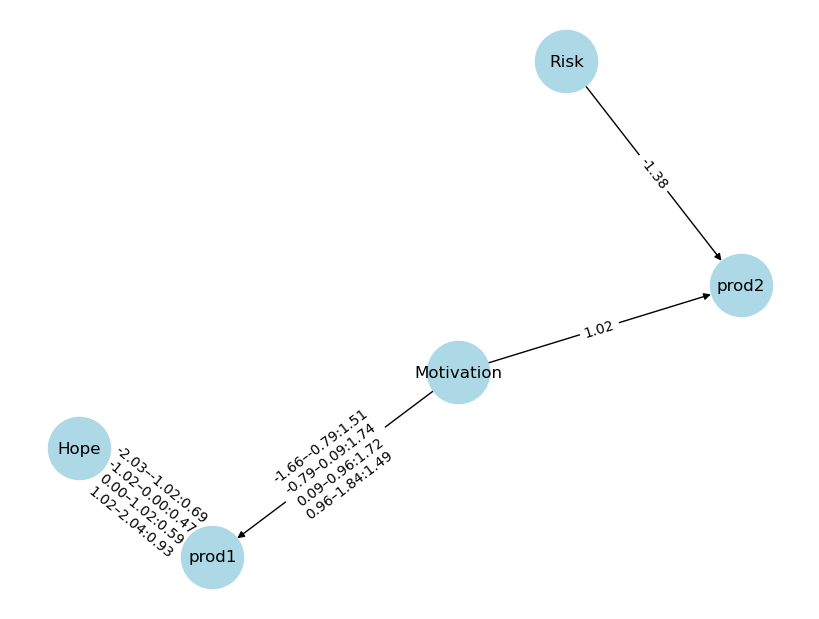

In [ ]:
import numpy as np
import pandas as pd

# Restore np.int for semopy compatibility (NumPy ≥1.24)
np.int = int

from semopy import Model, calc_stats, create_regularization
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from pygam import LinearGAM, s
from pygam.utils import gen_edge_knots
import networkx as nx
import matplotlib.pyplot as plt

# 1. Generate mixed continuous + ordinal dummy data
np.random.seed(0)
n = 500

# Three correlated latents
base       = np.random.multivariate_normal(
    mean=[0,0,0],
    cov=[[1,  0.5, 0.3],
         [0.5,1,   0.2],
         [0.3,0.2, 1  ]],
    size=n
)
hope_lat, risk_lat, mot_lat = base.T

# Start building DataFrame
data = pd.DataFrame()

# a) Ordinal Hope indicators (1–5 Likert)
for i, loading in enumerate([0.7, 0.8, 0.6], start=1):
    cont = loading * hope_lat + np.random.normal(0, 0.3, n)
    # cut into 5 bins, label 1–5
    data[f'hope{i}'] = pd.qcut(cont, 5, labels=False) + 1

# b) Continuous Risk indicators
data['risk1'] = 0.5 * risk_lat + np.random.normal(0, 0.4, n)
data['risk2'] = 0.9 * risk_lat + np.random.normal(0, 0.4, n)
data['risk3'] = 0.7 * risk_lat + np.random.normal(0, 0.4, n)

# c) Continuous Motivation with slight cross‐loading
data['mot1'] = 0.6 * mot_lat + 0.1 * hope_lat + np.random.normal(0,0.3,n)
data['mot2'] = 0.8 * mot_lat + 0.2 * risk_lat + np.random.normal(0,0.3,n)
data['mot3'] = 0.7 * mot_lat + np.random.normal(0,0.3,n)

# d) Outcomes
data['prod1'] = 1.5 * np.sin(mot_lat) + 0.5 * hope_lat + np.random.normal(0,0.5,n)
data['prod2'] = -0.7 * risk_lat   + 0.8 * mot_lat + np.random.normal(0,0.5,n)

# 2. SEM specification (same structure)
model_desc = """
Hope       =~ hope1 + hope2 + hope3
Risk       =~ risk1 + risk2 + risk3
Motivation =~ mot1   + mot2   + mot3

Motivation ~ Hope + Risk
prod1      ~ Motivation + Hope
prod2      ~ Risk + Motivation

Hope ~~ Risk
"""

# Then later, when you fit:
sem = Model(model_desc)
# … build your l1-thresh regularizer as before …
sem.fit(data, obj='WLS', regularization=reg)


# 3. Fit SEM with L1-threshold penalty
sem = Model(model_desc)
all_params  = list(sem.parameters.keys())
regr_params = [p for p in all_params if '~' in p]

reg = create_regularization(
    model=sem,
    regularization='l1-thresh',
    c=0.1,
    param_names=regr_params
)
sem.fit(data, obj='MLW', regularization=reg)

# 4. In-sample fit indices
stats = calc_stats(sem)
print("In-sample fit indices:")
print(stats[['chi2','chi2 p-value','DoF','RMSEA','CFI','TLI','AIC']])

# 5. 5-fold CV for true out-of-sample RMSE
kf = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_out = {y: [] for y in ['prod1','prod2']}

for train_idx, test_idx in kf.split(data):
    train_df = data.iloc[train_idx]
    test_df  = data.iloc[test_idx]

    sem_cv = Model(model_desc)
    reg_cv = create_regularization(
        model=sem_cv,
        regularization='l1-thresh',
        c=0.1,
        param_names=regr_params
    )
    sem_cv.fit(train_df, obj='MLW', regularization=reg_cv)

    # factor‐score imputation on holdout
    f_test       = sem_cv.predict_factors(test_df)
    f_test.index = test_df.index
    test_aug     = pd.concat([test_df, f_test], axis=1)

    coef_df = sem_cv.inspect()
    preds   = {}
    for y in ['prod1','prod2']:
        regr = coef_df[(coef_df['op']=='~') & (coef_df['lval']==y)]
        if '1' in set(regr['rval']):
            intercept = regr.loc[regr['rval']=='1','Estimate'].iloc[0]
            regr      = regr[regr['rval']!='1']
        else:
            intercept = 0.0
        coefs     = regr.set_index('rval')['Estimate']
        preds[y]  = test_aug[coefs.index].dot(coefs) + intercept

    for y, y_pred in preds.items():
        y_true = test_aug[y]
        mse    = mean_squared_error(y_true, y_pred)
        rmse_out[y].append(np.sqrt(mse))

print("CV RMSE:", {y: np.mean(vals) for y, vals in rmse_out.items()})

# 6. GAM-based edge refinement on the full dataset
# first augment with full-data factor scores
f_full        = sem.predict_factors(data)
f_full.index  = data.index
data_aug_full = pd.concat([data, f_full], axis=1)

params    = sem.inspect()
surviving = params[
    (params['op']=='~') &
    (params['lval'].isin(['prod1','prod2'])) &
    (params['Estimate'].abs()>1e-3)
]
results = {}

for _, row in surviving.iterrows():
    parent, child = row['rval'], row['lval']
    X = data_aug_full[[parent]].values

    # no other parents in this simple model
    y_star = data_aug_full[child].values

    # fit linear & GAM
    lin     = LinearRegression().fit(X, y_star)
    rss_lin = ((y_star - lin.predict(X))**2).sum()
    k_lin   = 2

    gam     = LinearGAM(s(0, n_splines=5)).fit(X, y_star)
    rss_gam = ((y_star - gam.predict(X))**2).sum()
    k_gam   = gam.statistics_['edof']

    aic_lin = len(y_star)*np.log(rss_lin/len(y_star)) + 2*k_lin
    aic_gam = len(y_star)*np.log(rss_gam/len(y_star)) + 2*k_gam

    if aic_gam + 2 < aic_lin:
        # finite-difference derivative + build intervals
        emin, emax = gen_edge_knots(X.flatten(), dtype='numerical')
        n_spl      = gam.terms[0].info['n_splines']
        knots      = np.linspace(emin, emax, n_spl)

        eps     = (emax - emin) / 200.0
        Xf      = X.flatten()
        p_plus  = gam.predict((Xf + eps).reshape(-1,1))
        p_minus = gam.predict((Xf - eps).reshape(-1,1))
        deriv   = (p_plus - p_minus) / (2*eps)

        avg_eff = [
            deriv[(Xf >= knots[i]) & (Xf < knots[i+1])].mean()
            for i in range(len(knots)-1)
        ]
        results[f"{parent}->{child}"] = {
            'type': 'GAM',
            'knots': knots.tolist(),
            'avg_effects': avg_eff
        }
    else:
        results[f"{parent}->{child}"] = {
            'type': 'linear',
            'beta': lin.coef_[0]
        }

print("Edge refinements:")
print(results)

# 7. Plot SEM graph with detailed GAM labels
plt.figure(figsize=(8,6))
G = nx.DiGraph()
for edge, info in results.items():
    p, c = edge.split('->')
    if info['type'] == 'linear':
        label = f"{info['beta']:.2f}"
    else:
        # build "k0–k1:eff0" lines
        segs = []
        knots = info['knots']
        for i, eff in enumerate(info['avg_effects']):
            segs.append(f"{knots[i]:.2f}–{knots[i+1]:.2f}:{eff:.2f}")
        label = "\n".join(segs)

    G.add_edge(p, c, label=label)

pos = nx.spring_layout(G, seed=0)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.tight_layout()
plt.show()


# Step 1: Initial EDA Seeding

In [ ]:
# nepal_df_cat = combine_dummy_columns(nepal_df)
# senegal_df_cat = combine_dummy_columns(senegal_df)

# nepal_df = pd.concat([nepal_df_cat, nepal_df.loc[:, ~nepal_df.columns.isin(nepal_df_cat.columns)]], axis=1)
# senegal_df = pd.concat([senegal_df_cat, senegal_df.loc[:, ~senegal_df.columns.isin(senegal_df_cat.columns)]], axis=1)


In [227]:
# eda_pairs_nepal = [
#     ('X1', 'Y'),
#     ('X2', 'Y'),
#     ...
# ]
# eda_pairs_senegal = [
#     ('X1', 'Y'),
#     ('X2', 'Y'),
#     ...
# ]
eda_pairs_nepal = []
eda_pairs_senegal = []

eda_sig_lin_nepal = []
eda_sig_lin_senegal = []

eda_candidate_nl_nepal = []
eda_candidate_nl_senegal = []

eda_sig_nl_nepal = []
eda_sig_nl_senegal = []

In [228]:
def get_one_hot_encoded_cols(df, cat_col_meta):
    dummy_group = []
    for col in df.columns:
        if 'binary' in parse_feature_metadata(col)['type'] and col.startswith(f"{cat_col_meta['qid']}-{cat_col_meta['name']}"):
            dummy_group.append(col)
    return dummy_group

In [229]:

from scipy.stats import pearsonr

def pairwise_pearson_lin_sig_test(
    df,
    pairs,
    lin_pairs,
    candidate_nl_pairs,
    alpha_lin=0.05
):

    for (X, Y) in pairs:

        x = df[X].values
        y = df[Y].values
        # If either side is constant (zero variance), pearsonr is invalid → skip to NL
        if np.all(x == x[0]) or np.all(y == y[0]):
            candidate_nl_pairs.append((X, Y))
            continue

        try:
            r, p_val = pearsonr(x, y)
        except Exception:
            # Numerical issues? Treat as not significant
            print(f"Numerical issues computing pearson for the pair {(X, Y)}, treating as linearly not significant...")
            p_val = 1.0

        if p_val < alpha_lin:
            lin_pairs.append((X, Y))
        else:
            candidate_nl_pairs.append((X, Y))



In [230]:
import dcor
from statsmodels.stats.multitest import multipletests

def pairwise_dcov_nl_sig_test(
    df,
    pairs,
    nl_pairs,
    alpha_nl=0.05
):

    dcov_pvals = []

    for (X, Y) in pairs:

        X_block = df[X].values.reshape(-1, 1)  # shape (n, 1)
        Y_block = df[Y].values.reshape(-1, 1)  # shape (n, 1)

        # Now run dCov test on (X_block, Y_block)
        try:
            p_val, stat = dcor.independence.distance_covariance_test(
                X_block, Y_block, num_resamples=200
            )
        except Exception:
            print(f"Issues with dCov test for the pair {(X, Y)}, treating as not significant...")
            p_val = 1.0

        dcov_pvals.append(p_val)

    # FDR‐correct the dCov p‐values across all tested pairs
    reject_mask, pvals_fdr, *_ = multipletests(dcov_pvals, alpha=alpha_nl, method="fdr_bh")

    for idx, (X, Y) in enumerate(pairs):
        if reject_mask[idx]:
            nl_pairs.append((X, Y))

In [231]:
# # run Pearson on every EDA pair, no FDR here since EDA is trusted and was verified by coordinator
# pairwise_pearson_lin_sig_test(nepal_df, eda_pairs_nepal, eda_sig_lin_nepal, eda_candidate_nl_nepal)
# pairwise_pearson_lin_sig_test(senegal_df, eda_pairs_senegal, eda_sig_lin_senegal, eda_candidate_nl_senegal)

# # we only run dCov on the subset where pearson was not significant, run FDR here
# pairwise_dcov_nl_sig_test(nepal_df, eda_candidate_nl_nepal, eda_sig_nl_nepal)
# pairwise_dcov_nl_sig_test(senegal_df, eda_candidate_nl_senegal, eda_sig_nl_senegal)

### Step 1 POC

In [263]:
# ── 1) SET RANDOM SEED ──────────────────────────────────────────────────────────────
np.random.seed(42)

# ── 2) DEFINE SAMPLE SIZE ──────────────────────────────────────────────────────────
n = 200  # number of “farmers” / observations

# ── 3) CONTINUOUS FEATURES ─────────────────────────────────────────────────────────
# Q1: age (continuous, uniform 18–65)
age = np.random.uniform(18, 65, size=n).round(1)

# Q2: farm_size (continuous, log‐normal)
farm_size = np.exp(np.random.normal(2.0, 0.5, size=n)).round(2)  # e.g. hectares

# Q3: annual_rainfall (continuous, normal around 1000 mm ± 200)
rainfall = np.random.normal(1000, 200, size=n).clip(min=200).round(1)

# Q4: fertilizer_use (continuous, roughly linear relationship with rainfall + noise)
fertilizer = (0.05 * rainfall + np.random.normal(0, 5, size=n)).clip(min=0).round(2)

# Q5: education_years (ordinal, 0–20 but treat as continuous for now)
edu_years = np.random.choice(np.arange(0, 21), size=n, p=np.linspace(1, 2, 21) / np.sum(np.linspace(1, 2, 21)))

# ── 4) BINARY_NOMINAL FEATURES (ONE‐HOT ENCODED) ─────────────────────────────────────
# Q6: region (3 levels → 3 binary_nominal dummies)
regions = np.random.choice([1, 2, 3], size=n, p=[0.3, 0.4, 0.3])
region_1 = (regions == 1).astype(int)
region_2 = (regions == 2).astype(int)
region_3 = (regions == 3).astype(int)

# Q7: irrigation_type (2 levels → 2 binary_nominal dummies)
#   0 = “rainfed only”; 1 = “some irrigation”
irrig_code = np.random.binomial(1, 0.4, size=n)
irrig_1 = (irrig_code == 1).astype(int)
irrig_0 = (irrig_code == 0).astype(int)

# Q8: seed_variety (4 levels → 4 binary_nominal dummies)
seed_codes = np.random.choice([1, 2, 3, 4], size=n, p=[0.25, 0.25, 0.25, 0.25])
seed_1 = (seed_codes == 1).astype(int)
seed_2 = (seed_codes == 2).astype(int)
seed_3 = (seed_codes == 3).astype(int)
seed_4 = (seed_codes == 4).astype(int)

# Q9: pesticide_use (binary_nominal 0/1)
pest_use = np.random.binomial(1, 0.5, size=n)

# ── 5) DEFINE OUTCOME METRIC (PRODUCTIVITY) WITH MIXED EFFECTS ─────────────────────────
# Let “productivity” depend on:
#   • 0.5 * farm_size  (linear)
#   • 0.02 * edu_years (linear)
#   • region 2 has +5 bonus, region 3 has −3 penalty
#   • nonlinearity in rainfall → productivity (U‐shape, since too little and too much rain hurt)
#   • irrigation_code (binary) has +8 bonus if irrigated
#   • pesticide_use interacts with fertilizer use (a small diminishing‐returns effect)
# plus Gaussian noise.

# (a) Base linear term
prod_linear = 0.5 * farm_size + 0.02 * edu_years

# (b) Region effect
prod_region = np.where(regions == 2, 5.0, np.where(regions == 3, -3.0, 0.0))

# (c) Rainfall U‐shape: best near 1000; drop off quadratically beyond ±300
prod_rain_nl = -0.05 * (rainfall - 1000)**2 + 75  # peak around 75

# (d) Irrigation bonus
prod_irrig = 8.0 * irrig_1  # irrig_1 = 1 if irrigated

# (e) Pesticide × Fertilizer interaction: pesticide enhances fertilizer up to a point
prod_pest_fert = (2.0 * fertilizer) * (0.5 + 0.5 * pest_use)

# (f) Combine and add noise
productivity = (
    prod_linear
    + prod_region
    + prod_rain_nl
    + prod_irrig
    + prod_pest_fert
    + np.random.normal(0, 10, size=n)  # Gaussian noise
).round(2)

# ── 6) ADD A SECOND OUTCOME FOR MULTIVARIATE TESTING ──────────────────────────────────
# Q10: income_continuous: depends on productivity (linear), age (nonlinear), seed variety, plus noise
income = (
    1.2 * productivity
    - 0.1 * (age - 40)**2       # too young or too old slightly reduce income
    + 3.0 * seed_2               # if seed variety 2, +3
    - 2.0 * seed_4               # if seed variety 4, -2
    + np.random.normal(0, 5, size=n)
).round(2)

# ── 7) ASSEMBLE INTO A DATAFRAME ────────────────────────────────────────────────────
df = pd.DataFrame({
    # Continuous / ordinal
    "Q1-age-continuous":             age,
    "Q2-farm_size-continuous":       farm_size,
    "Q3-rainfall-continuous":        rainfall,
    "Q4-fertilizer-continuous":      fertilizer,
    "Q5-edu_years-ordinal":          edu_years,

    # Binary_nominal (one‐hot)
    "Q6-region-binary_nominal-1":    region_1,
    "Q6-region-binary_nominal-2":    region_2,
    "Q6-region-binary_nominal-3":    region_3,
    "Q7-irrigation-binary_nominal-1": irrig_1,
    "Q7-irrigation-binary_nominal-2": irrig_0,
    "Q8-seed_bvar-binary_nominal-1":  seed_1,
    "Q8-seed_bvar-binary_nominal-2":  seed_2,
    "Q8-seed_bvar-binary_nominal-3":  seed_3,
    "Q8-seed_bvar-binary_nominal-4":  seed_4,
    "Q9-pesticide-binary-1":         pest_use,

    # Outcomes
    "Q10-productivity-continuous":   productivity,
    "Q11-income-continuous":         income
})

# Display first 5 rows
print("More Complex Dummy Data (n=200) – First 5 Rows:\n")
print(df.head(), "\n")


# ── 8) DEFINE PAIRS FOR TESTING (NO RAW NOMINALS, ONLY BINARY_NOMINAL) ─────────────────
pairs = [
    # Continuous vs Continuous
    ("Q1-age-continuous",          "Q10-productivity-continuous"),
    ("Q2-farm_size-continuous",    "Q10-productivity-continuous"),
    ("Q3-rainfall-continuous",     "Q10-productivity-continuous"),
    ("Q4-fertilizer-continuous",   "Q10-productivity-continuous"),

    # Ordinal vs Continuous
    ("Q5-edu_years-ordinal",       "Q10-productivity-continuous"),

    # Binary_nominal (region) vs Continuous
    ("Q6-region-binary_nominal-1", "Q10-productivity-continuous"),
    ("Q6-region-binary_nominal-2", "Q10-productivity-continuous"),
    ("Q6-region-binary_nominal-3", "Q10-productivity-continuous"),

    # Binary (pesticide) vs Continuous
    ("Q9-pesticide-binary-1",      "Q10-productivity-continuous"),

    # Continuous vs Continuous (for the second outcome)
    ("Q10-productivity-continuous", "Q11-income-continuous"),

    # Continuous vs Binary (no association expected for random pairs)
    ("Q1-age-continuous",          "Q9-pesticide-binary-1"),
    ("Q3-rainfall-continuous",     "Q7-irrigation-binary_nominal-1"),
    
    # Continuous vs Ordinal
    ("Q3-rainfall-continuous",     "Q5-edu_years-ordinal"),
    
    # Binary_nominal (seed_variety) vs Continuous
    ("Q8-seed_bvar-binary_nominal-2", "Q11-income-continuous"),
    ("Q8-seed_bvar-binary_nominal-4", "Q11-income-continuous"),
    
    # Binary (pesticide) vs Ordinal
    ("Q9-pesticide-binary-1",      "Q5-edu_years-ordinal")
]



# ── 5) RUN THE “CHEAP LINEAR” STAGE ― STEP 1 ─────────────────────────────────────────
lin_pairs = []
candidate_nl_pairs = []
pairwise_pearson_lin_sig_test(
    df,
    pairs,
    lin_pairs,
    candidate_nl_pairs,
    alpha_lin=0.05
)

# At this point:
#   lin_pairs          contains all (X,Y) that passed p<0.05 “linear” test
#   candidate_nl_pairs contains the rest (they now go to Step 2)

# ── 6) RUN THE “HEAVIER NONLINEAR” dCov STAGE ― STEP 2 ──────────────────────────────
nl_pairs = []
pairwise_dcov_nl_sig_test(
    df,
    candidate_nl_pairs,
    nl_pairs,
    alpha_nl=0.05
)

# ── 7) PRINT OUT RESULTS ───────────────────────────────────────────────────────────
print("Results of the cheap “linear” stage (lin_pairs):")
print(lin_pairs)
print("\nPairs sent to dCov (candidate_nl_pairs):")
print(candidate_nl_pairs)
print("\nFrom those, which dCov flagged nonlinear (nl_pairs):")
print(nl_pairs)

More Complex Dummy Data (n=200) – First 5 Rows:

   Q1-age-continuous  Q2-farm_size-continuous  Q3-rainfall-continuous  \
0               35.6                     5.26                  1171.5   
1               62.7                     8.30                   968.0   
2               52.4                     8.56                   996.2   
3               46.1                     5.17                   799.5   
4               25.3                    18.78                   996.3   

   Q4-fertilizer-continuous  Q5-edu_years-ordinal  Q6-region-binary_nominal-1  \
0                     64.41                    16                           0   
1                     49.67                     7                           0   
2                     51.50                    13                           1   
3                     37.92                    11                           1   
4                     47.38                    15                           0   

   Q6-region-binary_nomin

# Step 2: Lasso-SEM on Network

In [264]:
import re

def sanitize_column_name(col: str) -> str:
    """
    Sanitize a column name to be semopy-compatible.
    Replaces problematic characters based on a defined mapping.
    """
    replacements = {
        '-': '__',
        '#': '0',
        ':': '',
        '.': ''
    }
    # Use regex to apply all replacements efficiently
    return re.sub(r'[-#:.]', lambda m: replacements[m.group()], col)


In [265]:
def sanitize_edges(edges):
    """
    Given edges = {'LIN': [(X, Y), ...], 'NL': [(X, Y), ...]},
    return a new dictionary where every X and Y string has hyphens replaced by underscores.
    """
    new_lin = [(sanitize_column_name(X), sanitize_column_name(Y))
               for (X, Y) in edges.get("LIN", [])]
    new_nl  = [(sanitize_column_name(X), sanitize_column_name(Y))
               for (X, Y) in edges.get("NL", [])]
    return {"LIN": new_lin, "NL": new_nl}

In [266]:
def sanitize_dataframe(df):
    """
    Returns a copy of `df` where every column name has hyphens '-' replaced by underscores '_'.
    Also returns a dict mapping original column names to sanitized names.
    
    Example:
        df.columns == ["Q1-age-continuous", "Q2-gender-binary-1", ...]
        → df_safe.columns == ["Q1_age_continuous", "Q2_gender_binary_1", ...]
    """
    # Build mapping from original to sanitized names
    mapping = {col: sanitize_column_name(col) for col in df.columns}
    # Create a copy of df with renamed columns
    df_safe = df.rename(columns=mapping).copy()
    return df_safe, mapping


In [267]:
def cov_to_corr(cov: np.ndarray) -> np.ndarray:
    """
    Convert a covariance matrix `cov` (p × p) into the corresponding correlation matrix (p × p).
    diag(cov) gives variances; the standard deviation vector is sqrt(diag).
    """
    stddev = np.sqrt(np.diag(cov))           # shape: (p,)
    corr = cov / np.outer(stddev, stddev)    # elementwise division
    return corr

In [268]:
def build_sem_model(df, edges):
    """
    Build a semopy-style model description, expanding any nominal features into their 
    one-hot dummy columns.

    Args:
      - df : pandas.DataFrame, must contain all dummy columns for any nominal features.
      - seed_edges : dict with keys "LIN" and "NL", each a list of (X, Y) tuples,
                     where X and Y are the *feature prefixes* (e.g. "Q3-region-nominal").
                     For 'nominal' X, we expand via get_one_hot_encoded_cols().

    Returns:
      - model_desc : str, multiline SEM syntax, e.g.
          Q5-outcome-continuous ~ Q1-age-continuous + Q2-gender-binary-1 + Q3-region-nominal-1 + Q3-region-nominal-2 + Q3-region-nominal-3
          Q7-someY ~ Q3-region-nominal-1 + Q4-someX-continuous
    """
    lines = []
    parents_of = {}


    # Collect edges
    for (X, Y) in edges.get("LIN", []) + edges.get("NL", []):
        parents_of.setdefault(sanitize_column_name(Y), []).append(sanitize_column_name(X))


    # Build one line per endogenous variable Y
    for Y, X_list in parents_of.items():
        rhs = " + ".join(X_list)
        lines.append(f"{Y} ~ {rhs}")

    # expand edges


    return "\n".join(lines)


In [269]:
from semopy import Model
from semopy.regularization import create_regularization
from semopy.inspector import inspect

def fit_lasso_sem(
    df,
    model_desc,
    edges,
    lambda_grid=[0.1, 0.01, 0.001],
    tiny_penalty=1e-6,
    alpha_reg="l1-thresh",
    fdr_alpha=0.05
):
    """
    1. Builds a semopy Model from the seeds in `edges = {"LIN": [(X,Y),…], "NL": [(X,Y),…]}`.
    2. Loops over `lambda_grid`, and for each λ:
       - Creates an L1 penalty (via semopy.regularization.create_regularization) where:
         • edges in edges["NL"] get penalty weight = tiny_penalty (1e-6, so they are almost un-penalized),
         • edges in edges["LIN"] get penalty weight = 1.0.
       - Fits the penalized SEM.
       - Records which (X→Y) survived (coefficient ≠ 0).
       - Computes a simple BIC on the fitted model.
    3. Selects the best λ via minimal BIC.
    4. Refits with that λ to get final estimates.
    5. Returns a DataFrame of surviving edges and their coefficients, plus basic fit indices.

    **Arguments:**
      - df : pandas.DataFrame
          Your data (columns must match exactly the feature names in the seeds).
      - edges : dict with keys "LIN" and "NL", each a list of (X,Y) tuples.
      - lambda_grid : list of floats 
          The grid of λ values to try for the L1 penalty.
      - tiny_penalty : float
          The “c” value assigned to flagged-NL edges so that semopy's lasso
          never drops them unless absolutely zero evidence remains.
      - alpha_reg : str
          Which semopy regularization type to use; default “l1-thresh” (soft-thresholding).
      - fdr_alpha : float
          If you want to further prune obviously spurious survivors by FDR on p-values,
          you can apply a post-hoc screening here. (Optional.)

    **Returns:**
      - best_lambda : float
      - surviving_edges : pd.DataFrame with columns [“X”, “Y”, “Estimate”, “Type”],
          where Type is “LIN” or “NL” according to seed_edges.
      - fit_indices : dict, e.g. {"AIC": …, "BIC": …, "CFI": …, …}

    **Usage:**
      >>> seeds = {"LIN": [("Q1-age", "Q2-income")], "NL": [("Q3-u","Q2-income")]}
      >>> model_desc = build_sem_model(seeds)
      >>> best_lambda, survivors, fit_idx = fit_lasso_sem(df, seeds)
    """

    np.int = int

    # 2) Prepare a list of all parameter names (the “betas”) we want to penalize:
    #    semopy parameter names are of the form "Y~X"
    #    For each (X,Y) in seeds, the semopy parameter label is "Y~X"
    all_lin = edges.get("LIN", [])
    all_nl  = edges.get("NL", [])
    param_names_lin = [f"{Y}~{X}" for (X, Y) in all_lin]
    param_names_nl  = [f"{Y}~{X}" for (X, Y) in all_nl]
    all_param_names = param_names_lin + param_names_nl

    # 3) For each lambda in the grid, fit a penalized SEM and record the BIC
    results = []  # will store tuples: (λ, BIC, surviving_param_names, ModelObject)
    for lam in lambda_grid:
        # 3a) Construct semopy Model
        mod = Model(model_desc)
        mod.load_dataset(df)

        # 3b) Build a combined regularization structure
        #     Semopy expects "regularization" to be one object (fun, grad)
        regu_lin = None
        regu_nl  = None

        # LIN edges: penalty = lam * 1.0
        if param_names_lin:
            regu_lin, regu_lin_grad = create_regularization(
                model=mod,
                regularization=alpha_reg,
                c=lam * 1.0,
                param_names=param_names_lin,
                mx_names=None
            )

        # NL edges: penalty = lam * tiny_penalty
        if param_names_nl:
            regu_nl, regu_nl_grad = create_regularization(
                model=mod,
                regularization=alpha_reg,
                c=lam * tiny_penalty,
                param_names=param_names_nl,
                mx_names=None
            )

        # 3c) Combine both regularizations into one callable pair
        #     semopy expects a single (fun, grad) tuple for `regularization=...`
        if regu_lin is None and regu_nl is None:
            combined_regu = None
        elif regu_lin is None:
            combined_regu = (regu_nl, regu_nl_grad)
        elif regu_nl is None:
            combined_regu = (regu_lin, regu_lin_grad)
        else:
            # sum of two regularizations: (f1 + f2, g1 + g2)
            f1, g1 = regu_lin, regu_lin_grad
            f2, g2 = regu_nl,  regu_nl_grad
            combined_regu = (
                lambda x: f1(x) + f2(x),
                (None if g1 is None or g2 is None else (lambda x: g1(x) + g2(x)))
            )

        # 3d) Fit via Model.fit, passing solver="L-BFGS-B" and the combined regularization
        try:
            mod.fit(
                data=df,
                solver="L-BFGS-B",        # choose L-BFGS-B as the optimizer
                clean_slate=True,         # reset starts each λ
                regularization=combined_regu
            )
        except Exception:
            # If it fails, skip this λ
            print(f"lambda = {lam} caused error when fitting lasso-SEM, skipping...")
            continue

        # 3e) Extract parameter estimates and keep only those with |est| > 0
        est = inspect(mod)  # DataFrame with columns: ["Param", "Op", "Value", ...]
        # We want only the “regression” parameters whose “Op” is “~”
        regs = est[ est["op"] == "~" ].copy()
        # Keep those coefficients whose absolute value > 1e-8
        nonzero = regs[np.abs(regs["Estimate"]) > 1e-8]
        survivors = nonzero.apply(lambda row: f"{row['lval']} {row['op']} {row['rval']}", axis=1).tolist()  # e.g. ["Q2-income~Q1-age", ...]

        # 3f) Compute a simple BIC (semopy’s built‐in `calc_stats` method)
        from semopy import calc_stats
        stats = calc_stats(mod)
        bic = float(stats["BIC"])

        results.append((lam, bic, survivors, mod))

    # 4) Select best λ (lowest BIC)
    if not results:
        raise RuntimeError("No λ in lambda_grid converged.")
    results.sort(key=lambda x: x[1])  # sort by BIC
    best_lambda, best_bic, best_survivors, best_model = results[0]

    # 5) Re-extract the final parameter estimates from best_model
    est_final = inspect(best_model)
    regs_final = est_final[ est_final["op"] == "~" ].copy()
    regs_final["Parameter"] = regs_final.apply(lambda row: f"{row['lval']}{row['op']}{row['rval']}", axis=1)  # e.g. "Y~X"
    regs_final["X"] = regs_final["rval"]
    regs_final["Y"] = regs_final["lval"]
    sanitized_all_lin = [(sanitize_column_name(param[0]), sanitize_column_name(param[1])) for param in all_lin]
    regs_final["Type"] = regs_final["Parameter"].apply(
        lambda p: "LIN" if (p.split("~")[1], p.split("~")[0]) in sanitized_all_lin else "NL"
    )
    # Keep only nonzero survivors
    final_survivors = regs_final[ np.abs(regs_final["Estimate"]) > 1e-8 ].copy()
    surviving_edges = final_survivors[ ["X", "Y", "Estimate", "Type"] ].reset_index(drop=True)

    # 6) Report final fit indices (e.g. CFI, RMSEA, SRMR)

    stats_final = calc_stats(best_model)

    # Obtain observed and implied covariance matrices
    obs_vars = best_model.vars['observed']
    X = df[obs_vars].values # (n_samples, p)
    S = np.cov(X, rowvar=False, bias=False) # covariance matrix (p, p)

    Sigma, _ = best_model.calc_sigma()

    # Convert to correlation matrices
    S_corr = cov_to_corr(S)
    Sigma_corr = cov_to_corr(Sigma)

    # Compute the standardized residuals
    residuals = S_corr - Sigma_corr

    # Calculate SRMR
    srmr = np.sqrt(np.mean(residuals[np.triu_indices_from(residuals, k=1)] ** 2))
    
    fit_indices = {
        "AIC":    float(stats_final["AIC"]),
        "BIC":    float(stats_final["BIC"]),
        "CFI":    float(stats_final["CFI"]),
        "RMSEA":  float(stats_final["RMSEA"]),
        "SRMR":   srmr
    }

    return best_lambda, surviving_edges, fit_indices

### Step 2 POC

In [270]:

seeds = {
    "LIN": lin_pairs,
    "NL": nl_pairs
}


In [271]:
seeds

{'LIN': [('Q10-productivity-continuous', 'Q11-income-continuous')],
 'NL': [('Q3-rainfall-continuous', 'Q10-productivity-continuous'),
  ('Q4-fertilizer-continuous', 'Q10-productivity-continuous')]}

In [272]:
# build the semopy model description
model_desc = build_sem_model(df, seeds)

In [273]:
model_desc

'Q11__income__continuous ~ Q10__productivity__continuous\nQ10__productivity__continuous ~ Q3__rainfall__continuous + Q4__fertilizer__continuous'

In [274]:
df_copy, _ = sanitize_dataframe(df)
edges_copy = sanitize_edges(seeds)

best_lambda, surviving_edges, fit_indices = fit_lasso_sem(
    df=df_copy,
    model_desc=model_desc,
    edges=edges_copy,
    lambda_grid=[0.1, 0.01, 0.001],   # adjust as needed
    tiny_penalty=1e-6,
    alpha_reg="l1-thresh",
    fdr_alpha=0.05
)

print("Best λ chosen:", best_lambda)
print("Surviving Edges from Lasso-SEM:")
print(surviving_edges)
print("Fit indices on final model:")
print(fit_indices)


Best λ chosen: 0.1
Surviving Edges from Lasso-SEM:
                               X                              Y   Estimate  \
0       Q3__rainfall__continuous  Q10__productivity__continuous   0.239537   
1     Q4__fertilizer__continuous  Q10__productivity__continuous -19.004673   
2  Q10__productivity__continuous        Q11__income__continuous   1.199596   

  Type  
0   NL  
1   NL  
2  LIN  
Fit indices on final model:
{'AIC': -8.115921376659205, 'BIC': 8.375665456080977, 'CFI': 0.2898905318587133, 'RMSEA': 1.3474681777750832, 'SRMR': np.float64(0.11981843568868258)}


C:\Users\nadav\AppData\Local\Temp\ipykernel_26780\848937733.py:138: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bic = float(stats["BIC"])
C:\Users\nadav\AppData\Local\Temp\ipykernel_26780\848937733.py:138: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bic = float(stats["BIC"])
C:\Users\nadav\AppData\Local\Temp\ipykernel_26780\848937733.py:138: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bic = float(stats["BIC"])
C:\Users\nadav\AppData\Local\Temp\ipykernel_26780\848937733.py:184: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "AIC":    float(stats_final["AIC"]),
C:\Users\nadav\AppData\Local\Temp

# Step 3: Arrow-by-Arrow GAM vs. Linear

In [275]:
def compute_residual(Y: str, X: str, parents_map: dict, edge_coefs: dict, df: pd.DataFrame):
    """
    Compute R_Y = Y - sum_{Z in parents(Y), Z != X} [beta_{Z→Y} * df[Z]]. 
    Inputs:
      - Y: column name of dependent variable
      - X: column name of the edge we are refining
      - parents_map: dict Y->[Z1,Z2,...]
      - edge_coefs: dict mapping ("Z","Y") -> coefficient float (from step 3)
      - df: DataFrame with all columns
    Output:
      - R_Y: a 1d NumPy array of length n_samples
    """
    y_vec = df[Y].values.astype(float)
    for Z in parents_map.get(Y, []):
        if Z == X:
            continue
        beta = edge_coefs.get((Z, Y), 0.0)
        y_vec = y_vec - beta * df[Z].values.astype(float)
    return y_vec


In [276]:
def aicc_from_aic(aic: float, k: int, n: int) -> float:
    """
    Compute AICc = AIC + [2k(k+1)] / [n - k - 1].
    Here k = number of estimated parameters (including intercept).
    n = sample size.
    """
    if n - k - 1 <= 0:
        # fallback if sample is too small; return raw AIC
        return aic
    return aic + (2.0 * k * (k + 1)) / float(n - k - 1)

In [277]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def fit_linear_model(R: np.ndarray, X: np.ndarray):
    """
    Fit R ~ 1 + X using OLS; return:
      - beta_hat (the slope on X)
      - aicc_lin
      - p_value of slope (two-sided from t-test)
    """
    n = len(R)
    # design matrix: [1, X]
    X_design = add_constant(X)  # (n,2)
    model = OLS(R, X_design).fit()
    beta_hat = model.params[1]
    aic = model.aic
    k = int(model.df_model) + 1  # df_model excludes intercept, so +1 for intercept
    aicc_lin = aicc_from_aic(aic, k, n)
    # p-value for slope is at index 1
    p_val = float(model.pvalues[1])
    return beta_hat, aicc_lin, p_val, model

In [278]:
from statsmodels.api import families
from statsmodels.gam.api import GLMGam, BSplines

def fit_gam_model(R: np.ndarray, X: np.ndarray, n_splines: int = 4):
    """
    Fit a univariate GAM: R ~ s(X), using cubic B‐splines with `n_splines` basis functions.
    Returns:
      - gam_res: the fitted GLMGamResults object
      - aicc_gam: the small‐sample‐corrected AIC (AICc)
      - piecewise_slopes: a 1‐D array of length (n_splines-1), approximating 
                          the derivative d/dx [E(R|X=x)] at interior grid points.
    """

    # 1) Build B-spline basis for X (use default quantile‐based knots)
    #    You can replace `knot_kwds=None` with explicit placement if desired.
    n = len(R)
    x_min, x_max = np.min(X), np.max(X)
    x_1d = X.reshape(-1, 1)

    # Note: we no longer use find_inflection_knots here, so omit knots entirely
    bs = BSplines(
        x_1d,
        df=[n_splines],
        degree=[3]
        # If you want to force custom knots, use: knot_kwds={"knots":[custom_knots]}
    )

    # 2) Fit the GAM with Gaussian family + identity link
    gam_model = GLMGam(R, exog=np.ones((n, 1)), smoother=bs, family=families.Gaussian())
    gam_res = gam_model.fit()

    # 3) Compute AICc from gam_res.aic
    aic = float(gam_res.aic)
    k = int(gam_res.df_model) + 1                # # params = df_model + intercept
    if n - k - 1 <= 0:
        aicc_gam = aic
    else:
        aicc_gam = aic + (2.0 * k * (k + 1)) / float(n - k - 1)

    # 4) Build grid of (n_splines - 1) interior x-values for slope estimation
    if n_splines > 1:
        # n_splines + 1 total points → drop endpoints → interior = n_splines-1
        x_grid = np.linspace(x_min, x_max, num=(n_splines + 1))[1:-1]
    else:
        x_grid = np.array([(x_min + x_max) / 2.0])  # fallback if n_splines == 1

    # 5) Evaluate the fitted smooth on a slightly denser grid, for finite differences
    #    We pick a grid of twice the resolution so differences are stable.
    m = len(x_grid)
    # Create a finer grid that includes all interior nodes plus tiny eps around them:
    eps = 1e-6 * (x_max - x_min + 1e-6)
    x_dense = np.sort(np.concatenate([
        x_grid - eps,
        x_grid + eps
    ]))
    x_dense_reshaped = x_dense.reshape(-1, 1)
    # Prepare the design matrix for the smooth: intercept only + smooth(X)
    exog_dense = np.ones((len(x_dense), 1))

    # 6) Predict on x_dense via gam_res.predict()
    #    In current statsmodels, .predict(endog=None, exog=None, transform=True)
    #    will produce fitted values on the new exog.  We only need the smooth part,
    #    but since exog is constant intercept, predict() yields intercept + s(x).
    preds_dense = gam_res.predict(exog=exog_dense, exog_smooth=x_dense_reshaped)

    # 7) Approximate the derivative at each x_grid[i] by finite difference:
    #    If x_dense = [x1 - eps, x1 + eps, x2 - eps, x2 + eps, ...], then
    #      slope_at_x_grid[i] ≈ [ pred(x_i+eps) - pred(x_i-eps) ] / (2*eps)
    #
    #    Because x_dense is ordered [x1-eps, x1+eps, x2-eps, x2+eps, ...],
    #    we can take differences in pairs.
    piecewise_slopes = np.empty(m, dtype=float)
    for i in range(m):
        low = preds_dense[2*i]       # pred at (x_grid[i] - eps)
        high = preds_dense[2*i + 1]  # pred at (x_grid[i] + eps)
        piecewise_slopes[i] = (high - low) / (2 * eps)

    return gam_res, aicc_gam, piecewise_slopes


In [279]:
def refine_continuous_edge(
    R: np.ndarray,
    X: np.ndarray,
    alpha_threshold: float = 2.0
):
    """
    Compare a linear fit vs. GAM fit of R ~ X using AICc.  
    If GAM's AICc + alpha_threshold < linear AICc, we choose 'NL' 
    and return the piecewise_slopes array. Otherwise, we choose 'LIN' 
    and return the linear slope.

    Returns:
      - keep_edge: always True (we don’t drop continuous edges at this stage)
      - final_type: "LIN" or "NL"
      - final_estimate: if "LIN", a single float (the OLS slope);
                        if "NL", a 1D np.ndarray of length (n_splines-1)
    """
    # (1) Fit the linear model
    beta_lin, aicc_lin, p_lin, lin_model = fit_linear_model(R, X)

    # (2) Fit the GAM model (new version returns piecewise_slopes)
    gam_res, aicc_gam, piecewise_slopes = fit_gam_model(R, X)

    # (3) Compare AICc + threshold
    if (aicc_gam + alpha_threshold) < aicc_lin:
        # Nonlinear wins: return the piecewise slopes array
        return True, "NL", piecewise_slopes
    else:
        # Linear wins: return the single OLS slope
        return True, "LIN", beta_lin


In [280]:
from scipy.stats import ttest_ind

def refine_binary_edge(R: np.ndarray, X: np.ndarray):
    grp0 = R[X == 0]
    grp1 = R[X == 1]
    if len(grp0) < 2 or len(grp1) < 2:
        return 1.0, None
    tstat, p_val = ttest_ind(grp0, grp1, equal_var=False)
    mean_diff = float(np.mean(grp1) - np.mean(grp0))
    return p_val, mean_diff

In [281]:
def refine_edges(df: pd.DataFrame, surviving_edges: pd.DataFrame):
    """
    Perform Step 4 refinement on each (X→Y). Returns a DataFrame
    with columns ["X","Y","Type","Estimate"], where:
      - Type="LIN"  → Estimate is a float (slope).
      - Type="NL"   → Estimate is a 1D array of piecewise slopes.
    """
    # (A) Build parent‐map and coefficient dict
    parents_of = {}
    coefs = {}
    for _, row in surviving_edges.iterrows():
        X, Y, est = row["X"], row["Y"], float(row["Estimate"])
        parents_of.setdefault(Y, []).append(X)
        coefs[(X, Y)] = est

    # (B) Gather edges by predictor‐type
    cont_info   = []  # (X, Y, R_Y, X_values) for continuous/ordinal X
    bin_info    = []  # (X, Y, R_Y, X_values, mean_diff, p_val) for binary
    pvals_bin   = []  # list of p‐values for all binary edges

    for _, row in surviving_edges.iterrows():
        typ = row["Type"]
        X, Y = row["X"], row["Y"]
        R_Y = compute_residual(Y, X, parents_of, coefs, df)

        meta = parse_feature_metadata(X)
        if meta["type"] in ["continuous", "ordinal"]:
            cont_info.append((X, Y, R_Y, df[X].values.astype(float), typ))

        elif meta["type"] == "binary":
            p_val, mean_diff = refine_binary_edge(R_Y, df[X].values.astype(int))
            pvals_bin.append(p_val)
            bin_info.append((X, Y, R_Y, df[X].values.astype(int), mean_diff, p_val))

        else:
            # If you have no remaining "nominal" features, this branch never happens.
            continue

    refined = []

    # (C) Refine continuous/ordinal via AICc comparison
    for X, Y, R_Y, X_vals, typ in cont_info:
        if typ == "LIN":
            refined.append((X, Y, typ, coefs[(X, Y)]))
            continue
        keep, ttype, est = refine_continuous_edge(R_Y, X_vals)
        if keep:
            refined.append((X, Y, ttype, est))

    # (D) Refine binary edges with FDR
    if pvals_bin:
        reject_bin, *_ = multipletests(pvals_bin, alpha=0.05, method="fdr_bh")
        for idx, (X, Y, R_Y, X_vals, mean_diff, p_val) in enumerate(bin_info):
            if reject_bin[idx]:
                refined.append((X, Y, "LIN", mean_diff))
            # else: drop this edge

    # (E) Build the final DataFrame
    df_refined = pd.DataFrame(refined, columns=["X", "Y", "Type", "Estimate"])
    return df_refined


### Step 3 POC

In [282]:
surviving_edges

,X,Y,Estimate,Type
0,Q3__rainfall__continuous,Q10__productivity__continuous,0.239537,NL
1,Q4__fertilizer__continuous,Q10__productivity__continuous,-19.004673,NL
2,Q10__productivity__continuous,Q11__income__continuous,1.199596,LIN


In [283]:
df_copy

,Q1__age__continuous,Q2__farm_size__continuous,Q3__rainfall__continuous,Q4__fertilizer__continuous,Q5__edu_years__ordinal,Q6__region__binary_nominal__1,Q6__region__binary_nominal__2,Q6__region__binary_nominal__3,Q7__irrigation__binary_nominal__1,Q7__irrigation__binary_nominal__2,Q8__seed_bvar__binary_nominal__1,Q8__seed_bvar__binary_nominal__2,Q8__seed_bvar__binary_nominal__3,Q8__seed_bvar__binary_nominal__4,Q9__pesticide__binary__1,Q10__productivity__continuous,Q11__income__continuous
0,35.6,5.26,1171.5,64.41,16,0,0,1,1,0,0,0,1,0,1,-1263.73,-1516.58
1,62.7,8.30,968.0,49.67,7,0,1,0,1,0,1,0,0,0,0,79.56,53.13
2,52.4,8.56,996.2,51.50,13,1,0,0,0,1,0,0,1,0,0,131.73,141.58
3,46.1,5.17,799.5,37.92,11,1,0,0,0,1,0,1,0,0,0,-1911.97,-2296.83
4,25.3,18.78,996.3,47.38,15,0,1,0,1,0,0,0,1,0,0,147.62,155.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,34.4,3.66,959.4,44.19,3,1,0,0,0,1,0,0,0,1,0,44.82,49.84
196,52.1,5.16,1074.2,50.65,8,0,1,0,1,0,1,0,0,0,1,-92.60,-115.39
197,60.2,6.64,879.2,36.93,16,0,1,0,0,1,0,1,0,0,0,-598.20,-760.24
198,59.7,8.63,1017.3,46.25,4,0,0,1,1,0,1,0,0,0,1,156.57,136.42


In [284]:
def parse_feature_metadata(col: str):
    parts = col.split('__', maxsplit=3)
    if len(parts) not in (3,4):
        return None
    qid, name, ftype = parts[:3]
    if not re.fullmatch(r'Q\d+|Q#', qid):
        return None
    dummy = parts[3] if len(parts)==4 else None
    return {"qid": qid, "name": name, "type": ftype, "dummy": dummy}

In [ ]:
refine_edges(df_copy, surviving_edges)

,X,Y,Type,Estimate
0,Q3__rainfall__continuous,Q10__productivity__continuous,NL,"[22.69842766583067, -4.948209794781352, -32.69..."
1,Q4__fertilizer__continuous,Q10__productivity__continuous,NL,"[363.06516722800853, -9.35770274087134, -490.4..."
2,Q10__productivity__continuous,Q11__income__continuous,LIN,1.199596
